In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs

%matplotlib inline

# Review

## Time and Space Complexity ✨Vibes✨

### KNN
- How is a KNN model "trained"? Is this a faster or slower process than the other model's we've learned?
- What do I need to store to make a prediction with a trained KNN model? How would that change if I added a new *row*? How would that change if I added a new *predictor*?

### Naive Bayes
- How does a trained Naive Bayes model make a prediction?
- Would adding a new *row* change how quickly I can make that prediction? What about adding a new *predictor*?
- Would adding a new *row* change how many values I need to store to make a prediction? What about adding a new *predictor*?

## Naive Bayes
### Naive
Naive Bayes is **Naive** because it makes the assumption of **conditional independence**. This means that within classes (the groups we're trying to predict), we assume the predictors are *independent*. However we know that's not true, so it's a *Naive* assumption to make. 

However, it simplifies our computation. When events are *independent* we can calculate their joint probability just by multiplying them:

$$\underbrace{P(A,B,C)}_\text{probability of A, B, and C} = P(A) * P(B) * P(C)$$

Rather than calculating the joint probability $P(A,B,C)$ by taking into account any relationships between the predictors.

### Bayes
When classifying a data point, we use Bayes' Theorem (at least the numerator of it) to calculate the *score* for each potential category. Then we choose the category with the highest score. Because we're comparing scores that have the same denominator, we can ignore it (which is nice, as it's difficiult to calculate).

$$ \overbrace{P(\text{group}_i | \mathbf{X}) = \frac{P(\mathbf{X} | \text{group}_i) * P(\text{group}_i)}{P(\mathbf{X})}}^\text{Bayes' Theorem}$$

- $P(\text{group}_i | \mathbf{X})$ is the probability of our data point being in group $i$ based on their predictor values $\mathbf{X}$
- $P(\mathbf{X} | \text{group}_i)$ is the likelihood of seeing features like $\mathbf{X}$ in group $i$ (if our features are commonly seen in group $i$, we're more likely to predict you're in group $i$)
- $P(\text{group}_i)$ is the probability of being in group $i$ overall (if a group is very rare, we don't want to predict it often)
- $P(\mathbf{X})$ is the probability of seeing features like $\mathbf{X}$ overall, in any group (but we ignore this term)

## Naive Bayes in `sklearn`

- `GaussianNB()`
- `BernoulliNB()`
- `CategoricalNB()`

In [2]:
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
nb = GaussianNB()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", nb)])

# fit
pipe.fit(X_train, y_train)

# predict

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.741424802110818
Train Prescision:  0.7669616519174042
Train Recall    :  0.931899641577061
Train F1        :  0.8414239482200647
Train ROC AUC   :  0.6957706093189964
Test Acc        :  0.7789473684210526
Test Prescision :  0.8095238095238095
Test Recall     :  0.9315068493150684
Test F1         :  0.8662420382165604
Test ROC AUC    :  0.7135740971357409


## KNN
KNN is a simple, distance based algorithm that let's us CLASSIFY data points based on what class the data points around them are. Birds of a feather...

Despite it being distance based, KNN is a *classification* algorithm. In other words, it is supervised machine learning, as it requires truth labels (the actual class/group). However it does share characteristics with clustering algorithms we will see later.

KNN *can* work with binary/categorical variables, but not without some tweaking which we do not cover here.

### Hyperparameters

Hyperparameters are parameters in our model that are NOT chosen by the algorithm (we must supply them). We can either choose them:

- based on domain expertise (knowledge about the data)
- based on the data (hyperparameter tuning)

Why do we have to use a validation set when hyperparameter tuning?


### Building a KNN Model

In [3]:
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", knn2)])

# choose potential values of k
ks = {"model__n_neighbors": [1,2,5,10,20]}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "precision", cv = 5, refit = True)

grid.fit(X_train, y_train)

print("GridSearchCV chose: ", grid.best_estimator_.get_params()["model__n_neighbors"])

# predict
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

y_pred_train_prob = grid.predict_proba(X_train)[:,1]
y_pred_test_prob = grid.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

GridSearchCV chose:  2
Train Acc       :  0.941952506596306
Train Prescision:  1.0
Train Recall    :  0.9236111111111112
Train F1        :  0.9602888086642599
Train ROC AUC   :  0.9895070207570207
Test Acc        :  0.8105263157894737
Test Prescision :  0.8709677419354839
Test Recall     :  0.84375
Test F1         :  0.8571428571428571
Test ROC AUC    :  0.8147681451612904



## KNN plotting

(this will only work with specific 2D data, if you wanted to use it for your own data you'd need to change the code to do so)

K-Nearest Neighbors is a straightforward algorithm: given a training set, classify a new (unknown) data point by counting the K nearest known points, and choosing the most common classification.

In this classwork we'll use ggplot to plot the boundaries of knn, and see how the size, shape, and overlap of clusters affect these boundries.

In [4]:
def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf[Xdf.columns[0]]) - np.std(Xdf[Xdf.columns[0]]),
                           max(Xdf[Xdf.columns[0]]) + np.std(Xdf[Xdf.columns[0]]), num = 100)
    x1_range = np.linspace(min(Xdf[Xdf.columns[1]]) - np.std(Xdf[Xdf.columns[1]]),
                           max(Xdf[Xdf.columns[1]]) + np.std(Xdf[Xdf.columns[1]]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({Xdf.columns[0]: x0, Xdf.columns[1]: x1})

    #build model

    knn = KNeighborsClassifier(n_neighbors = k)
    pipe = Pipeline([("model",knn)])
    
    pipe.fit(Xdf,y)

    # bredict all background points
    p = pipe.predict(x_grid)
    x_grid["p"] = p #add to dataframe
    
    #build the plot
    bound = (ggplot(x_grid, aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_manual(name = "Class", values = ["#E69F00", "#0072B2"]) +
                 geom_point(data = Xdf, mapping = aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(y)"), size = 2))
    print(bound)

## Explore

Let's test this function with some fake data:

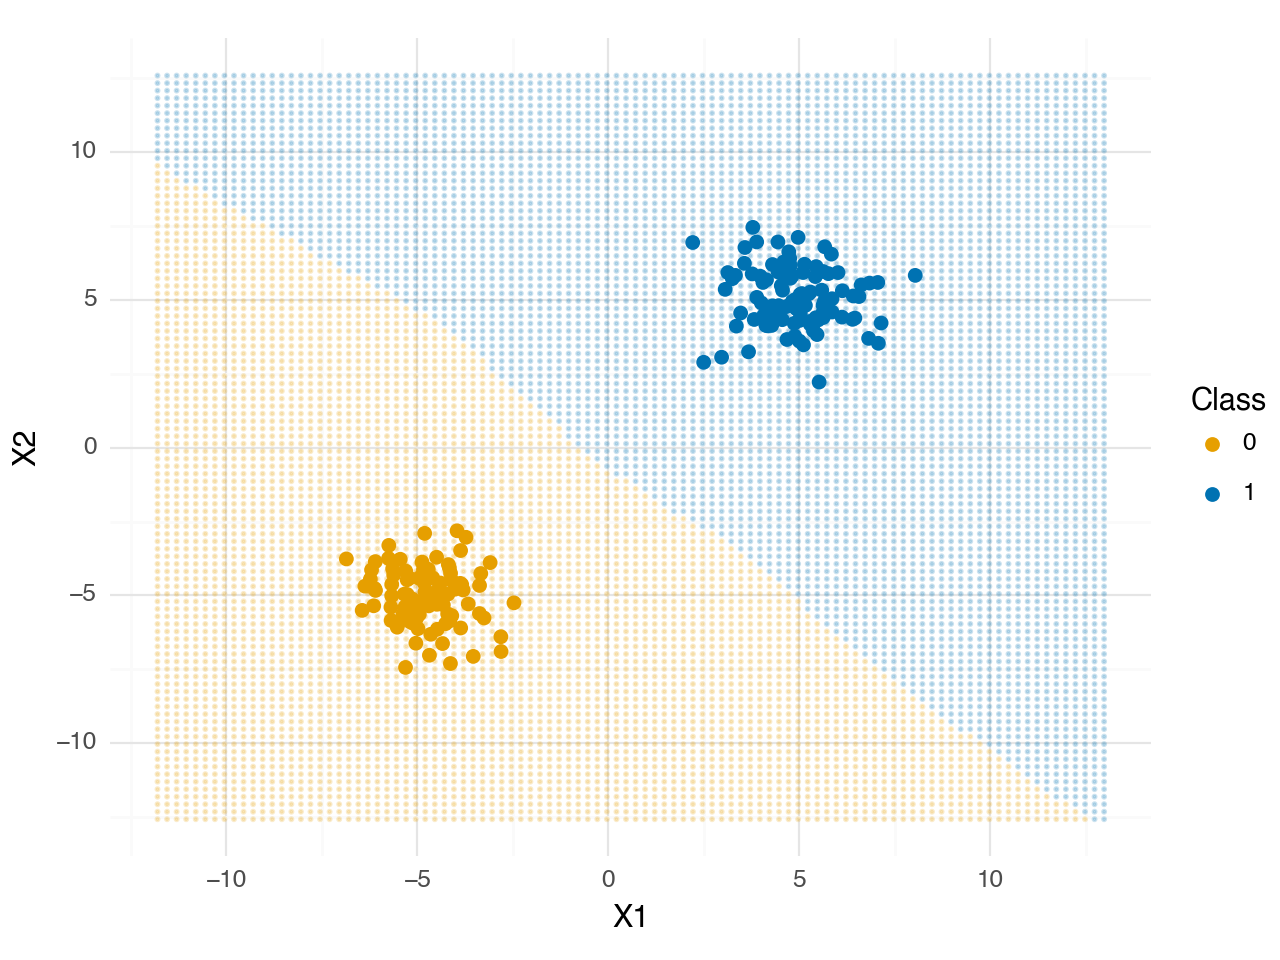

In [5]:
# Generate Fake Data
centers = [(-5, -5),
           (5, 5)]
cluster_std = [1, 1]
n = 200

X, y = make_blobs(n_samples=n, cluster_std=cluster_std,
                  centers=centers, n_features=2, random_state=1)

# make it into a dataframe for ggplot
X = pd.DataFrame(X)
X.columns = ["X1", "X2"] #rename cols so they're not ints

plotKNN2D(X,y,1)

## How does changing K affect the decision boundary?

Using the dataframe `dd` and using the `plotKNN2d()` function build KNN models with K = 1, 3, 5, 20, 50, 100.

**How does the decision boundary change as K changes?**

In [6]:
dd = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/knnclasswork.csv")
dd.head()

,X1,X2,y
0,-1.710595,-5.593345,0
1,-14.912877,-3.722297,0
2,-8.533054,-5.908033,0
3,6.188479,-3.813313,0
4,-6.062674,-3.809560,0


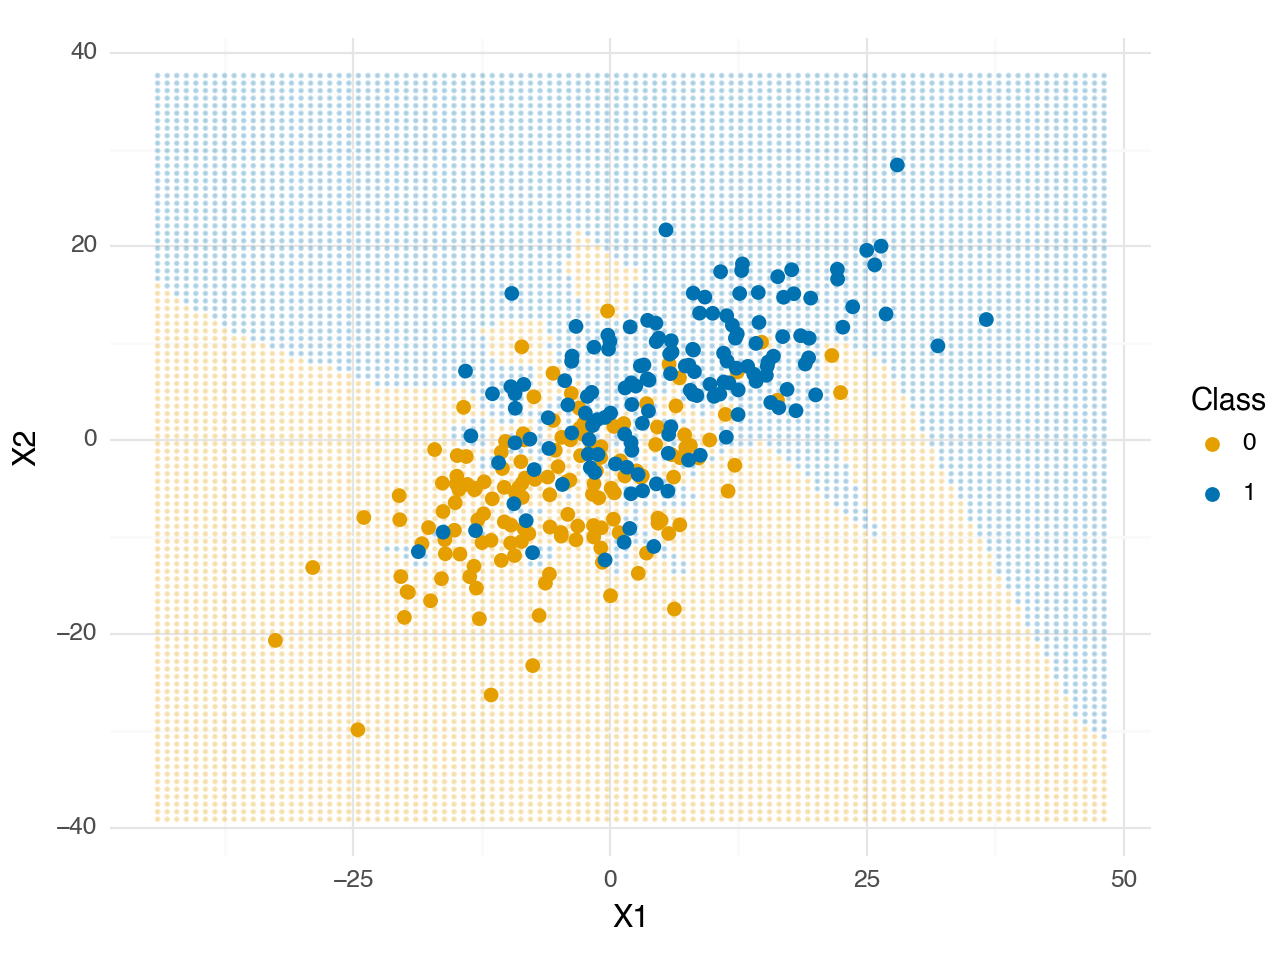

In [7]:
### YOUR CODE HERE ###

# k = 1
plotKNN2D(dd[["X1", "X2"]],dd["y"],1)
# k = 3

# k = 5

# k = 20

# k = 50

# k = 100

##  How does changing k affect the decision boundary (imbalanced classes)?

Now let's see how changing k affects the boundary when the groups have different numbers of samples. Using the `plotKNN2d()` function, and the data loaded below (`dd2`), examine what happens to the decision boundaries as you try different k's (try 1,3,5,10, 25, 50, and **100**).

**How does changing k affect the decision boundary when the groups are imbalanced?**

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [8]:
dd2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/knnclasswork2.csv")
dd2.head()
### MAKE A SCATTER PLOT OF THE DATA ### 


,X1,X2,y
0,3.033900,3.586612,0
1,4.787792,17.663630,1
2,7.954019,0.915931,1
3,5.804289,12.212329,1
4,-6.659940,7.114966,1


In [9]:
### YOUR CODE HERE ###

# k = 1

# k = 3

# k = 5

# k = 20

# k = 50

# k = 100

# `KNearestNeighbors()` and `GaussianNB()`

Download [this Wine data](https://www.kaggle.com/datasets/ruthgn/wine-quality-data-set-red-white-wine) from Kaggle, upload to colab, and use both KNN and Gaussian Naive Bayes to predict `type` (red vs. white) in this dataset (your predictors should be ALL variables except `type` and `quality`). Use 80/20 TTS, z score your continuous interval variables, and use `GridSearchCV()` to choose `n_neighbors` in your KNN Model.


### Question

How well did your models do?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = “200”/>


In [10]:
### YOUR CODE HERE ###


In [11]:
### YOUR CODE HERE ###


## Recommendation Systems

"If you like _________________ you should listen to ___________________ by Taylor Swift."

We're going to build a **Recommendation System** to recommend Taylor Swift songs for people by letting users select a song, and then recommending the most similar songs (according to `danceability`, `energy`, `instrumentalness`, `valence`, `loudness`, `liveness`, `speechiness`, `acousticness`).

To do this, we're going to load in our [training data](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/TaylorSwiftSpotify.csv), fit a `NearestNeighbors()` model, and then for each song in our [new data](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KNNCompareSpotify.csv) we'll find the 10 most similar songs and recommend them!

Then, we'll send these recommendations to be put "into production" through [an interactive web-app](https://shinylive.io/py/app/#h=0&code=NobwRAdghgtgpmAXGKAHVA6VBPMAaMAYwHsIAXOcpMAMwCdiYACVKCAEygGcmBLGVMTpkmdOFHYB9QlwBueJgBEoZKADE6sOAB0I9Rky4ALXhGx8BQkQEF0CsRzh0FAV173xhMr1k69DZlYyIwAbXgAjC0FhJgAFFSNdXQBiJhDiCUNSAHMuXVMaXhC4JgBeOISACklJQuKagEosKAcRAHombTBVbHS6DBlZLt0evrLRcSlByoKiuAbdGnHgLrJNQgBrSWh4LoUulu8uMm2tPYOQ8JcYU92wAF0kiFTsuBEwgC8P4hYxdl4vLxSHlHEtXidUH8uJUGAB3CDXLgKUZCPAQcYAFgaiF0TDxTAAHuMUf0isRCMA4QiYFxgAAGRAQe73YA0R7o-FiMguOgQSoEhYQXRoVCSNzjNzNV61EJudiVXH4yVGACMCrAAGUckwAEpwEgweAcFRAoVgBp4RV4yWodWKfpMADCRjgIS44gqdGKZDIAFpYq7inReN4uharUxJSEoNhiC4TlxeOw4OEWgqOfilbxmhBXZJE8nU3R05nS1mMEYAEzqgCqqHSmVjPKYAGkAHJtphqOZhy0Zsvl0yoeO1ObqsSEOo6fBpKDhV3jLrtzt6g1GzjeUhdnvmvsD0uSgASABUALIAGXVAB5UAA+Y8mHgipgwKAbOA8CeMdcm4FMYhLMeMZjBqsK8DQIhcDkPBNi+vDZEY7y8O+Cipu67D-uiTZ0EwNBQLIQghiUUEQNkGC9hG+7KtWXQam83ikXku6UQOkpDiO7rFF46qHLwxx7J0mquvqNjCHxZACYQRjEACH7jCAtHCdATAAOKMHAHxdIggl0cUylqfAmn4Cx+6mWZ5kWaZXQAPJhLIvBQLqxDsMG2TEFpgm2T4DlOS58HucZ-aWcFIWhfiXT2m+07aRFmjvucQVhUlyVlhFLiOeevCsB5aUZVlUAJSlRXFXiXQPiUABC4hkMUTExWA5VMFVKi1YVJXtWFXTOkU-zGKpsDhKYAX1d1IS9UY-UwINEABXuHXzZZXQVcGZC5uYGqoOIdB1YJy0hmtTAbVtTFzQtZ37ktcCxhAhAAJddEw9VVddd1ted72Zl0sTSSmlXBuwrzbQ9OJgN9xC-U1-2A0xAC+p3tZxIlwOw5Q2XZPk6s5rkBeGiVlmxEDDgmwncas6wbAJilcSIaj4YRFCHTkknSbJPDlApYBtqQ0WCVzuZdDDuMWQTROSFAgKkJIVw+qQ6puZTYAqZQTgqCUq7fpQG6mkxQsDrr+PZqwuYhJIr6mCWIXUeq6uGprv4QDr8PC9mcZkKLG5QLUmjwOqXAuNkrzHNrFF40w+th32gpPMmSzunQvjFuxZAKK7RMKO6XCJqQ2IRuwSzlGI4veL4GAAGpQLKcCVMoqgaFolQNIKmYiAXnjF3AZcVy4Vcc7plCOQZGkeRzfM810o8C07SVo95jmY358tgI9TAj9zOWc2vYBwyZoWxVFw-j5v9UT1vU+dWAijpUwmXZUgK+H-zd8P9O2+hyFZUuk11WtXfq+P8fm9X4lS6iYMafEJoqQGkNA+G9-680AWfXeYA9qrSuodTaLQdp-zHrAl+iD37IKuqQV6v9n7rxPkA4qX0frzkhkmaGMCT4AMfjDQWEYIypELoCXwTA4A0BoCJXCQhcJzEjPWDI-xSIRgAAJcPbhgAAovwkSMi5E+A7nAXw5AZiE3jBgCcU4m74hjkwSQDccShzzhgd0ZAYSTGkHIHRRN9H6inA3ekLIugeyCIkB4jcd4kVyOMKx4IG471SIQQuDN-heACfJGGO8aDCLhHwdEmhSJVzpHgQJXBrFGDQHADxOc374lpDkjAZIKRwk8SgMSxxbjTmZOMXJoTymVMpMQWENTeL1J2I0vAIA2ElLxGU6CFT0hVM6d0upJw+ldGZMANpEyOldJWN0cmDT5n3GaWM9p1S1lrHFlsOZDwd5kGsW8SoXAjGpX7LItu6jFHKNiXctRJdNGUFsUnFxk45gKG+T0sgNymAmLMcU-cOTJBkAEMSDAoTgWZkhdC1AOzGJQoEMAAFMyG7siotmFwqANxwHzCTbwHwq5kyOczGShA5LlCRQIKOocngXTuaneMqjNZOAwB7L29dgX3KLo8j52jvluWBSYv2AcPybgduYgJ0Fgk0DhZchF+IpLEHdOicoYRjhXLGcsnJByNknO2aUco3zDmbAbpaSAcB4JGHCEIJi9wGgeJ3iEcY4JJCQmRtCDVWqXH1nFhSsAaz9hgDDEG6MtL1SPGMpG801j6whhtUwEkaq8QhAGMQWUMAHbLDKuTBW1gZklsuNceZLKBxch5HyEITKnjCnQOMWwtoRRincIYJwCdBSn3AH06gJIBhyHwEQUgFAqDIAODMzZCbAWSCTOcFAFabhLvnauqF2BNrLorlcG4YhijcGJUS3dm7D3iHdJIbAW0z37skBe49kgiU+onHxU0y7OA3XEINMIZBsDLuVnQbIAGE3vlA7a9ILh2C5kzsumAzlpy2q4JtfUJhYMnQOCQFwQdCAYeXaYY4dBrifIrvhhNdllZwYTbICulBaXLooJYRjGz122rYBXbAiYuBii9Ix-gxLEzZGgNyMQn6+KEG2NcecdBP08ntqbTDYA4AEhTYQEMLGjmSCMGIGgBGeMTIrppzYc7bVWq2L6+ycBYS8ZCMZ450mnCMe3UhylJmeS8EAwSCgvIK62dySh4g3gaAQYuPek5trwOma6Ah5M0WwBRdi9OJIDVgLCNAuBCSCa6QADZDzngxB8OkjpZBqGsASbAhBKwAHYVIAA1UA0DpJWZdABWawCjFAqXCGEY8x4aAACtrIVQABzHg1DAFUXBvN3srQmyszWADMvo6TVZW9VvYC3KyLdtZwCDdIMA5YxDlvAB3qsjZ29VvAvpKwYBG8dvAKpTsYDpIt1rJ2Dt0jpBiH7j2MCLZG3AFbH2MAqmq09g7GIACcj3KwqheyN21tW6TZAqi4HLEBzzsCMGoRQsQdTnkIHSQ87AuvLsQm7LgiA2htDQNmQLwXsA5pgG0WQKpafQaBL6DjIQuN8TaMj1H6PMfY9x-jwnxPScqT2BiR7eBttg9y3gMr54NQKNtRT1AVOad0+TUF8CTODSs-Z+ZrgAuVIo7RxjrHOO8cE6JyTsn+AVdq9taeUwJRKhAV6EIAA5DwUuTgs4QAWPgNs1g5duYpgmhnBvEDmcQILq3Ivbfi4d1L8nPotfU7aMQTaEA9eM+Z20cz5vLfC5t2L+3kune2qOm+JgXNYRMC92lug-umCB+2qaUPtrpcJtfANoQy6VIvigEP2TkazTe5AmBCCy7cv5cK8V0r5XKs1fq415rbWOtdZ67wPrg3htjYm1NmbG793Lq28t1b63NtLd2zGPYB3WsjcR2d1-eBWvXdu4tjEV2IcXtFs6Rv9PtKxWsIdnsVRFtACAcACVQMQMAococnsuhFtTxsAyAAB1NsEbc8arYwNsAATQ+BUhCAxDIGsBbB1FQEz0pxz111jxC2LzZw53+GIG52gF524zaHQMwJwLwIIKMGINIPIMoOoNoPwFlye0rByxVG2yyRd3Vy6E1211p1QHp0ECLyN1YNN14IwOwNwPwMIJILIIoKoJoL2CULr1YDoA2B4DUF5xbxnyEEAEwCAPIPHvPYcPeXMzYtGPLQuPBPPgwwwQkw0Q8wiQug7PGnPPSgQvA3YvUvEIgQ4w4Q0wsQiwyQmw8QDYRvTpZwtvDvLvYPXvLoNQeDcfYfBNNQMfCfYYafNvQ6OfLLW1RfArIrErMrCrKrWrBrJrFrBNdrTrbrXrfrIbUbcbSbabVosLObW1a-dbO-fAa-R-fbDAaHK7A7HLN7Xw30RbJAmrOXMA6rHbT7XLOHU7KAsHZ7BbHbBA27XLHbLoarKHFwRQayIrD4FwFwLAjUarQ8LAgkD4U8GAICQYjXLPNQxgwI5gnQ9nKATnDgnnPnM3V494z4ukb434-4wE4E0E8EmXOXSsKHDEFUEbGHawlQqEhgjQhIuExgY3EvcmNEt4j4r4n4v4gEoEkEsEqACEqk5BI5JgY8H4RQfUOAKaJwQon3dvDw7vbObwiPZ49ZKlAI-XELePcmRPNkzE7ErkvE3kwkhNVQnPOIgvJgw3Rk0vdE9krEzk3Enkgk-k5devPIpvGUvoYozwxUhNRQSo+ov0uo6olLFwnCDLefbLPLDolfbo9fPorfCEroYYvfMYo-SY0-GY2bGAK-JbJY1be-bbNY5-DAarI47Y6rK7K7G7O7cHY4oA8A24jEd-KAjEM4w7RbGHFUckpAqHb-ZMgkOrAAR2wAG0ykIFkAUVQCkjLKHIUToGwDUGPGiOhLpMtJYIRKRM4M4x4Na0HJHLHIBEnOnKMFnPnMXOXKkOJIxErH-x20FNNJ1zXNhKtJZ10JZLaD3OHNHPHOPJnMrDnIXKXKsOsFV2UM1AwXdIKNb1lO9IVJDyVLwFlyj2XUtK1KOUQC-IPN-KnP-MAovJXLNPz3pNfOZKOU-P3J-KPNwtPIAvPOAoTTdPyObxgq9PlNKJHwDOqL72DMn1DKaIjNmLAHaOXy6LX16M3wGJ3xGP30PwmJP2mPP3Y1XVzO23zI2xWIfy8Sf3wEhxVBh0hyu1l19FaxexVBO0AOayhxByWw+ygJ2KgMW3uP0owBJOQrABVA+BrBGwGxVAJEW2wF4ChwJArlPDUGstQA+BbGyOpPoKfM0I1NItYMRPYO3O4P508u8t8v8sCuCtCvCpy0iuir2HuKQpAKhyVwfJpPipIo3LIs2DN0yp8r8oCqCpCpCDCoiqiuyMFPFJaCYAACliAjB0RWK-d2KvCw8I9+zVTNhUKXz0LNhEAmrsrWq8qOqCqiqYqwBHzc9iL1yjdS8VqWrcr2rOrCrurXTILmLPTxrO8fSEKE0FEuLJ9bUFFeKGiyoBKWiF9ozRLV8eiN9+jt8hjd9RiD9xjj8piz8hK915iuhFjb8CzNKiztL1jWtbznscsodKwkLrsDiRscsLLntXtsbnsYDICDt9LcbtjLjzKCbqt3LgCiCMRHRS5qtrAcsiChyyAABFMgPrYgarGsOADEAbQimqg6xk5KrclEng5m1m9mzm7mvmgW0U4W0W8Wq8mQgHbG+80C13WKmI9QhK7Q6Wk3D8hWtmjmrmnm-mwWjWsWkCsCt3cQUasMuCjiqavAE7FC9UxnRajYRAK2pW221Wh2kWp2k06qva+IqWlnZIukFm625Wu2tWoWyOrWnIhvD0sauU+6+CsosAZ6gfKo16rod6wfEMxo2U5ozLX6pfTogG+MySkG21FM8GuSqGzMpSuYnM+bPMpGjS+XLSsAPbEsiA0A0skbJ7Yy27HLOkRHSy1rXY846mq4z7VrWXF-AAzsu7B7LoHLdgY8Tm7AYrSsPUXmjYEIcgD4AALRCBGxCEWwlpNtqvhLYK5zlv5yPpPpyzPsdAvrgCvpvrIHvsfufqJJkJy2qxyxXuVwNvAt2phMSrqr0N-tPvPsvuvtvofqfpfud0QdtUag1DICEHMGsiWBrB4Dzs9smrwB8Kuz9uQwWoTwwf-qweAZwbAbwcgejritjotJfKSPJjaHYYAaAZAdwYgYIezqgpYo9omt9LepeuXUrrLs+tS1rsEobpjLEsBoTKktBpkrTPkuhqzIv3hrAERrW2RpHtRrHp0qxpGynsWyLNxt9Gq1B1e3rOawpOexccptByh3fwwHey7PAJe0-wRoUTUDvqh0lLIBbCwIUWyBCCwJrF5pUgUV5sW1iCh1fpQbNrfM3NSu-rN0rFificSeSdSfScyeydyfyagflxxpxsUKIaNtXNNsSI-r0MqbiYSZgCSZSbSYyayZybyYKcIZdvHg+RwhUhSTrFuvzpKPoZ8MR2Ya6DQoTwGeqeGdqbGYacmeaf4eNvNPfutNEb2aGZGbqfGcaamautyJutoaUcettX9NLsDM+Y+qny+u0Z+qjMbtjPEqBsTOktTIhvTIUphuzNUpv1seHtWLRonpAOexXtxsR32LCdkN8dkKnrpHkI3tB2h1uPMrwBnqQNW1tUWy4CwMW2IA1HCA+C4AEQnKhzq2IBrHYBUi4Gq18UhIEaKd6fNs-uRK4NRN4PpcZeZdZfZdkE5e5d5f5cFekLwDezcfgaquFefNQb6ctplaZZZbZf1EVa5Z5b5YFedsNuLpunyXIGRhWboeUZ8Jhy2bAB2e1LpYZeNflbNaVctdVdfoufjvqo2Gld9bldNY5YtZVetcYuutzsUYLq9r72SFUYTRUlSCrr4prtn3ruBb0ebokuBqTLAA7tkshozMUthpUoHrUqHsLJVPHt0o2OsoCZcceyexrOsoMpJpGx8fOMXsJpJf0sAKJu-wQNMsJpVLpDbFhBUkdDpFkFey40dCIIAEk2wyBsgMcuBX9Cm9XimmSUqv7JWeD53F3l3V2AquAN3t3d393D3tb5c7jKrOmdqY6RWGSSnw2zcr2l2V21372t2d292HYX2EHZnCEfRpSHw2BdQRVXhnX3ne8fCVQskPWvWMLAOb2QOH3wPn2RsQ39rhHDrRG8PgO73COn3IOSPE2Xnk2ii0Pl0Kp4Mhpy7kE4IZo82AWC3Iy2i-qm64zS2IXjGoWu6a24XLH+6FjB6kXm3iy22MaaawmQm5cTL-tyySbKx7soCiWx2MbWyuynLDsjiuh5CIAKpYg1AMQdQjAMQ6tzw1ABrS4k7zw2xqsXAs6unaSenf3T3ZaL2MrKxrPbP7PHPnPXP3OiDPPvOs71XgD5DLidXjaf2kqLajlGqwubO7OHOnOXO3OPOvOfObXwLN2IAZpaVyBUPU31mI9uy-C1SWHErA7lrcuIuCvoviu4vSvfOv2BHQ3yOrnyKrO8vIvCuYuSuEvnmc7oKU21nlGuoM2B9OPl1HQc31v-mtGBOhKRKROwXDG27kywaq2YXzHe6V1L8G3EXlj7GW2nHIdyykCVRv9v9fR4cKquySa5CDKXtcsYGSXKxLiDs3sp2ctbsFtUCwAKDTwPhN3rAly1B2AhyVIKpeascaBwhYhaUlNkHj3RW-2z2JWdz+c4eEekfjwUe0eMesece8eWnbyt7oDoPbWCeAvMv-22gKfEfkfUf0fMe84GePxyvbVDxETHWMI3n6vXXGvcbsPWHtTeeqeafBf6fcfRezm1Dhv9XRvNgeeyB4e+fqeBe6fhfNelMmLmPYLWOajM3bVajc3NGwy67BOugDvQWDHW7y3K3THu7a34Xbv1KlPUWVPXGibHsslfQRsNjiaTiQcfsjKNjFsgclcqbDOqaTtXiNjDPkyocWxrJiBDw1BCBYRWs6saBN3HQIBrJWsBXc0XAj3Oe6qSe0qpXWsC+i+S+y+K+q+a+6+G-ZQSq5dFtsb5COmYOOfLm-29DO-C-i-S-y-K-q-a-6-pJh+ZnbXzxuARAWw+IaHFuHr0PGuVTzN5q2uE95-u+l++-V-B+N+m-teiK46RuE7RHr-F-e+V+B-1-G+5v5GdXJbh8y6DWBVutqZ3gmjAF-N+KgLQtkJxBb6MW6ZbSFp3WrawsLGylG7vJ0baKcUaj3dYotmqxT04GVxX0IgVexPZLKGIZrCTRS5jt-Gn2YgbjTuJ3Z3WsPIwEOQGoYhwgGoEIEQQGrWQ6s4QHLHfQxAagdQMAD4ASHx7ftCegXGWmUxC5m4MQnA7gbwP4GCDhBog8QZIOkEnQkuYOaypP3Z5yCW+BrbLjzzUE8C+BAgoQSILEESCpBMgsXl0HPDahMoPCGXsAJP6PZ3K5-f2kEWV7WCNBdg7QY4L0EuDn+sRMjnr3f7kVVBXAmwZoPsE6CnB+ggAa8yP6F0NuDvLqDAPzbpYgWCA4tqJ3BZGN26Z3f3tJ0wF90EWIffAcpwxar0Nib+MgbH1kJUDdO52Z7D9n7ZU0muYPZso9k753ZWeaBbAG2AGobBgwsQD4FgQGwbANgigawFgUPCI9S4NYIcs3xn5BclBZPM3AFSmEzDeAcwhYUsJWFrCNhWwpnm9kHb60p+Zg3Ye+UsFHDphsw+YYsOWGrD1h1gTYdsK37gVrIPIQ-m3ncKy8PmGHGagENa4B1gikw94acM+EXCfh1wgEUK3OaxCT2yRBEScLOFfDLhvw-4ZkJt5sUIRRdR0HkLACOgCh-HIofAI97CcveyA8TpUJMbQszGPdOttgIRoKd7uKLRxujScrPZGauNasgcTvK+NgC7ZL7DATHaL1ya72R7DASQIqkMQmic8NgCIKtYRaKoLAh+EIByEyAlYFsHVmsA1gdhYbRQeewOE88NRWonUXAD1EGijRJos0RaNfY1ZocGIb-Gl26bPCsuDVO0bIE1HajdR+orgIaJVDGjTR5o1wZqAJROBXw7tMEXbwYaNdfas1aPLCKCEYV1RIYh0eGJdHRi3RcY6IYI12Gl58xoYx0c6MjGujYxHouRlkJY7kjOK3zbil0FHyQDYBe3XRv9TKHHdfeVQjkQHxk5YCrGNjfkaPVbYYt-8ATVrN-mrKIEACJNTvlsTMpHYx2v2A7Hp1xrQF4cq2NUXAEWx302wJ9UuDlliCOg6A7AIgqeBrB0AawHVVALzUtFv89hNo9KioJPFniLxV4m8XeIfFPiXxb4z0UTWOwnY-R-nAMdz3VGnjzxfwgCbePvGPjnxp4V8fGIUTUxgwhAEUnGCkgt4BEKgDAF2AriepgRIgCqMQGwANAVm4InwS3g0AGBGo5cFwCECBSIUbiivS-sr1-GITLx14lCcBPQmYTyxuvbEaI3gl-ikJQkoCWhNAkkiFurYnwe2IgEaMs2tI3bvSPd7CUmRSAsThUNO7sipOGAq7nDTk68jcB04hxrOMMrb1SyDlDxogR2L7i1x6LKmp3zHYA5bico87KDmFEe9vgUOYgQSFfyKAQgwgh+uk1kA0AiCRgbIO+LiGfjSe34toFiWIAhS9y4UyKeEGilYFYp8UxKZ6IxoA5fRn7aflaMDH2F0pwU0KTlKikhAYpcUhKfGKwIuh0QCiQ0I5FphNSeApga+MQC8FhkGJx-JiQEBFKfw2JHE3weSWa5zVAhmpBPBlKylhSRsEUxqc1KKmkdX+yU0vCtPqnrTcp+Uwqa1MY7zcFGKk4-sui+bqSfmEULSa7x0ZFsBxR3H3qgPO6cjA+sneoU20aFh8sapJEUVuJOzkC2BpVT7E5Q3EgFR2WST7AvVCYz0ImBxb7O5VawbBDwp4GgB8GyDng76+TVrNZChxtgKoZ9DYC4AxBDByxGXVvsF1tHozMZ2M3GfjL7JEySZZMimVTLxoyFTi5JKCRVKeFVTueDMrGTjLxkEy2ZpMukOTMpnxjN2ToRDnRBKBEE4w9EtDuNJYlTTESM0riewJhHbMleGFEWUzPFmsziZUsmWVzL84xDdpkk8isbLFkszCZ5sjmbLPOmADvB10mouAJiwaTHeObDSb2J0n7d9JJbcoSdwrYjjTJl3bkZOL5F2MBRdksJrAwxZVlrsXjHGlOxJptkHJY-Gmr9xyyhMiBS9f-Hdh8ZdAMQ1gCqEQQJCXAcaWBCqJuwGyHgXA1WY8JuxbCGg7M1M+QVzzb7lMeeVcmuXXMrANym5LctuR3K7ktNgCC9SHmzyQaCyPxLwoMZXOrm1zwg9cxuc3NbntzO5MAbuQvNtSOhd+tUJ0MRimhhBSIRE6qKRIl69A0EWBIoGEFgDXI1Z5IjWcwFYnazOJ3tBbPNOzEGzeJeYoeRvK3njzd5U8g+TtKEZ7SpJoCkeWPJ3mTz95h82iEm2Um282xWbKkd2MDmFDwyxQxkYgLDlDiPp1QsybHMsnWN45yLGcU90Ox1kX8bQ5cYwqzlgFkCWNG4nDNByDCwmbZPANZSQKkCK5XAEbI3JbAEgMQd9IwDlgXIdYPgI2HUMeGjBNjrZb9IWf3OUE88xFEiqRTIrkXYAFFSilRVACbGGCwcpA6CZLWXnVSVBuijufotkXyKFEii5RaovjFqBiAuacBEwGsi5h35jEyoMxK-laz2Jv89MfLhh76zPWhspahiAcWSLpFzioxa4pMUeLxJWIonuGx0XiLHFySwxcYvcVmKlJl0rBapJwUdiuOeCwMkHMIUMi9JJCwce9Ik5oCLuXIoPjgLu4Jz6F6xSHg5Nfzf4dsWne7KuMhl6dyaJLOkCgRBykCHid2C7LahVCHhHQyYGkNVliC8076OoAbDeV5qKAsC54awHSGsBJST21o1KVK2WWrLJS-LTZdst2WVh9lhy45actfZuNoCHbaxRotsXc9rlayu5Vsp2V7KDlRyk5fGOPACZaooI2UqNMLqfzJpJQaaREp8Ig8AFF-OEdqX+W3KNlQKx5c8rBVvKMROvLJYFyOorKAVuKh5SCpeXgr3ZLY8pV7M+Y+ywAkA5lY9O+oNLPeBk8OeWxVA0AIAA1arBsDpA9YQgbYGgOeBVAbBS47ANsKXCwIqgiVdQ4PiARuw5ZQ+goksqcSno+jZc1ZTDmEwpY8LF6Kc3cWPxJpEtWeVNYUUwIgKCKvG32FUreUlIuA6Wc4FsJuw1ADYdQMwrjHpwGzoj1FNMj+lottEuqYAbqrgB6q9U+q-VXAANeiPVbX4+yeAY8DqBrCLzdW5gsVv03VGRr3V4QT1d6t9ULkE1PldEYKR35aJkwOECXuSi4norFp2AdrhGqjUxqS18axNTAsrHXN817aotbGtLX+qK1y6d3DBgdRkBD+n8SFZ6mUDwgmACif4LKiLr94IB23HijAG251K3eIcppW9JQEJp+Vgq4VaKqakSqpVMquVQqqVWdKrJN+VrOqs1VJzSBYPEKXgGrIdCiBUo19S9gXpdkNiafGyowKAIjZ9xi9KJjNRyxDkCQsgbAFDgDD2cBqm7Icq1gGoVRS44QcILCF4FnLslFy9vjwWg2wb4NiGnUMhtQ3obMN2G3DZ6PJI1Ysk6azNcSpglCz0GMGuDQhtFrkaUNaGjDVhpw0ah4xp4FoN4rNCRKFeWYjFbmKWrEbONZGijXxuo2Cae1YbUvHJtI3cbFNVGgTbRrdxJgIAk66dSUFnVKAoAC6pdSGHoZdjcFHKuAbpO5WkKWlSygVUKpFViqL10q2VfKsVXKrruccxto+tkLPqGFOxDcUdhhzGUcs6nXxq-gcndkp2rlSsEBtbIbjNigi6LVDl2LJkhym7EvuwA2BYFCqRgU8FwGPAP02wlYbIHgUIB4aFBpTL8R31y35bCtxW0reVvFVVaatTPL7NjRMFZr0uvctBh+VazNaUerW1ACVrK0VauthOeMdYHIC8BfQh4JwLNB8Jn9-COYpadqVG15bxtRWybe1pm3Va5tmS22dktLy7aWtB2qbR1sq0nbatCacdYZoQhTrnCM6ooGZos3LrrNxdKkeo1qUELd1-Yw7t70PUuaT17m89ZKq83XrfNd6mhYFqfX-StVbbOBu2ScpPYYcn3A4ivXVaQz-u1WDyQD2tW8KQc5lCyoaqJbuVas1gQmjWGICVgBsRBcIANhGyyBN2dWOAGF2wBYF2AdWvuXTLSm076djO5nazvZ2c7udZgPnUz3ezyFZcTGgbf6LY0fkRdOWBnUzpZ1s6OdXOnnbLsBF14ZozefxYiq-jiwJolQYiecmvgcYlAC4PULRMQr+DNtQCzFRhXV2a7xdOuqXfrv51nbYFdsg3p7rF3a7JdeumXf7v00TrXtxmkUp9vnWdSfty3MAH5rZWgC7NfYl6aDpZFGSPKrm09R5ph1XqfNt6n6aqqC0aqUdL6oGWD1HYeNDVMBNyZvXfXPd7iUTNPlPXkIg5OysOT7L9kPqbLrINYL7ASBwJ0AVIsIR0HfQ+BOpgwdWULIN0G05rieQuqVleN5rD7R94+yfdPtn2EQF9LTfSjeQ-aPDs1sE9BkPpH10gx9bYCfVPpn1z7eAh+w3V0BVkuBfcYgPxeiHf04RrI8IBQPvyj0+FoRru2JcAtk1X7t9d+3fY-oP2L7dqEki7aIw31b6b9O+h-fvvn2L7ntRm97SZoT3mak9VmlPbdN9n3SL4me4OSDuZGGSI5x6tzWevFXF7vNN6vzRZN+mV6QtfSreuTTLJkDuypZb7L4yJobiid3+aLedk73XF4tGnBAp5NtTqiWwp4IcjQChx31TwGoQgCEEUB1ZqspcBDbu2qwEgBdtM-YWlKUMqG1DGhrQzob0MGHYgRhkw6+zBz-4wNR84NUNosGry4Ayh1Q+oc0PaHdD+hww9kGMPCaDNk63UFAFMCIVMxMSnDvEt8NWGAjth4Iw4acOqaPxVY5I-4ZsNBH7DoR8I09siOx78D8eudUQcXXJ6QB1IqkTSJ7FA7npJQ16WDtZGWcC9UO5g5etYPw7y9XSlbFwer0MLGagBVrNMo-XXZY+jNMZcE1uIeTbi88gYfcQg0hTNmYAarN4pgAbBeaGoIgjQBVAORKwpcCAKXAURYEaAagTdmoqX0q7flYa4XVsZ2N7GDjRxk42cYuNXHzFxJTDouJOxK6WNNi5KSvJqmbHGAzx-Y4cf5LvHzjlx64-GN5rdwg4pADAKiYAD8iFJhlJubXtcwT2x3Y5CbeOnHYTXxrI3AvIp4mITrx6E8Sc+PwmSjMexCHHtM2J7qjJB2o2uvIOdjFYVB+pQ5tDnNLwdHRyHUwc80l62DCOxGkMYe5NCDshNDcTVlxrGVBD1OklmP3bJvcrsEo5LYMeuKhNNTH6qHMIsk10gVILYRQJwNEHhAYAzLHUCTlT7YAyCFUYep4ZX0pTCN-OU0+actN31rTtp+01dCdPD11W5lZsoZwBOumL9H5L0xaaHJWmbT4QO0+wAdNBn4xpceCEUDYAMwNQJgVohsybVbaW1y0s07GfjP+nkzgZkIM6bJNB6I2MZn036cTMBnHTVZl02AFwNlGvcH2yo99vZNF0S6663jmox47V06RfJvdaUIPXtH89IpovT0bh1l6Jx1CqU8jplMAztiqal-A9mrJGnyS+Ov9TZSOyhMvsRLCZZ9jfztkbyEPdynSFLioA1AOWAnOwEdA0BYgm7OAEQR1CwhTwFMsgHfRbCmHQ1a+y9neYfNPmXzb5j81+Z-MUF-zR+0kuZXKln7l9UZywbefvOPmscEF985+e-O-m4Lr+whANmszCRgDEePWWAcSNB10LYFrC6+ZwvQX8LAFgPb2vIo0XMLz5+i1BbwuwXmL0el7UyfKMsmqjlmldWpK5PVLeTwO7PbQd5XLoGDhe6HfOdL3sH62AxtVcFuGPrFocGOhUdHze6tCfu-ei1XKeENg8zzoOIsjaqj5GnkCao8IBVEUAbBYQJoiqKeDqx0gyAhAbINYCgB1ZHQF2MCYCZ+XAmGtlyngjwMcvOXXL7lzy95d8v+XArTPf-NZVxrfKQ1uaj8pFacsuWWwbljy15Z8t+WAri2IK1WrnDYBgw5AQVhhyw7YnCz7XbK9FbyuxXCrCVkq0FfUVIGyVUkhyzlZisFX4rxVpKwyYEtvauzBBns8QbEsJpKRVSjblJeaPELJzbRvPQpa6Nineji5lVepelOJzQt847YggUpbpyXsKBEQ-aqYHuGeFchSyn2ROwVUgC7lH0TqG7KVgBqHwVrEYF5q+Hsgm7Y8HVmyAag6srLQC2KweNSsXrb1j619Z+stg-rANoGyDYMHElvsLjXGhGduOsbflehKG-IRhvfXfr-1wG8DdBuEWWwLQV8FxOiWUW4lQdPG+9c+uE34bxNpG2TeCvdXSKVY1rK9fxtM24bCNkm8jbHWlHBLE1io19umu-bs2uCgOYDrHPSWWjOeug3ys6OimWDC51SzyMR0PrVz+1wgS0Ip0CHECfZJetnNCbWVoZX2YlgMNcbnWwcplFAlicrDnhplOoIgrCEPCtZYgA2D4IQCgBXipoNYawLCFkaRnNFwF-nC7bdse2vbPtv2wHdiBB2Q7sjEM2-mhz8zkLdx0K9z2jtQ53bnt7277f9uB3wgwd0O-GNAhwA3g+RYIKYGKmRLiWPE93UtTzsF247xdxO8nYrssW1N1zV2-ndjtF2E7pd8u2HfbOi3xrjUYS72ZmvHz6ji1ohY0pWu576Datuc7DpUuSnB6e13pSWSJqwEfReNT7hQO-WAEECAyo+8OxQKEsRsTCyyxZUiYhSsTKoXmrzV4C8BFsrAVrDABGyngl1UAOkBAHCAbABsNAWEGDdX3mGrlb9j+1-agA-2-7ADoByA7AcQOXDKBV7JSQFnn7Vdlg1++-c-vf3f7-9zgCg9AfgPhNu-JMaYDIvKiCzbumTUHQIdwPiHSDsh8A4ofoOObpKrm6IxYdEOEHJD5B5w7Qci3GTU97s5LbZNz2K6-2xe1yoFNTm1r69pS5vYlP9H71gxvW3vZU6nERR36j7kaa+zN6gCxnXcT41uxSHdT55y6+p1xpCKvs7A44y4CHKngBsbkCm9ZEPBthTwI2Q8KgG8x1ZJFkD90wPJcduOPHxALxz478cBOgnITz0TQPB4eGsbQJ85XYraARP3HnjqAN498f+PAnZAYJ84dSeNRFm1UJgFgRaBcSXdLXRh9towrZOonMTgp-E+KeJOeH52nq+RWae5P8ncTopyU-EdjXmThB2e79oqLzWaiCj-k-utWtr3Zzaj8U30aXOcGdHtkhhcMN3G41QZ8hOPkZZexXmAm3684rIX+7dlDzwosDUgXtUvEVQjoRyzqE7lqBjjcAZ5-eJUgqhFAagCqIK3Dv3HI7aJB5085edvOPnp4L5z87+dM9yS4xtKzg5Qt4Ogx4OR54oGecwBXngeCF1C9+eCtBSFUeCIDEmmIdGo7U3NCUA1AbAIMUIhh+AZbtB1UXoLzF+C5bCfPvneLms8gYpMgv0XYL7F2y8hccuYXo1vA+LZntS2U9agFlenrADSvZnE51o6vdVtLPuj6j1Zzta0caWq9a51HYDMALQ5EcBql-PpXrKYdz7FLFGdVmkM2rE+vB7sgdmsoqlWs2BAkMkyHLfONQsQKbFDiwK81vbWBVx0-2CsZWoHjW3cq6-deevvXXAX1-69iCBuhywbkM6lc-zpWvDmVywS66BJRvFAXrn1364DdBv4x8QYMCdAw7xHabEBoOtm7ddYEPXebmN3G6LdJuuXPTg3rW9zf5vY3hbhN8W9Fednp74zyVxyds2NGFbS15e0q5VvyXVHarlZ9tf83Lmd7GzggRPS3Fbmp2+lqmrMcw4OSyydlc8z0LOyR9LFCOSTSqA1AfAyAbYJdrCAUSHgBqCiUuGoAJAVUFErWMI2QbSchWMn4rD041Svc3u73D7p9y+7fd0gP3X724QgWIGpPKpONj8pe+ve3vHQ97x98+9ffvvP31WW6YKUPAOomAlXQoMmD-Q0vGuWJhI3TeWpAfUP6HsD1h8g84fv3iB3hyIzG60eQPGH8D9h+g8DuxbQ7qazI9+1gCqR0A8d9pPHM0GeVZCo9XO82ua3t7SOzS7q5fWVleh9qprr6CNOM1t6UBf7jARbIDDyanC+Q-vRmrVZl2LlkbAoi4AeWawMASsBoDvqxvcgjO0JwRoHmWe6Q1n2z-Z8c-OfXPUECEiGebLnYns6bt0yCbRJWe9OfnukA56c90AXPUONzwKU-ZkEQwUkLiesao-VvE8sXmz3Z4S8BfkvQX9z73eyOiNvPvn4r4l8C+pfgvIzsV4J+keiXft7HNbkOYTQVQRzfHST4reWvTu5Lcn1Vwp63uaOdb2jlT-rZLLNk1OF2LYtdmi3jGuhVNNTm2UJbU6Nx8hdsnjpGEZzMxFBAkMQAGy1QwqWylSECVhAfBKmcAIcp15DcZuw34V8nmQBO9nePwF3u+ld4JA3e7vD3pngvTH4RfEX2dv97jfe+nfzvagS79d9u8KJ7vj3wUlgTjBjRfcvgBQI6DR-sAMfcABQDmZx94-dZdLqi4gGO-Q+vvsPn7-D4B+PeurbHijgkKh+feuA3337-98R+A-+Pkjya215qMUiF7Enp6Uvcc2Cnpz619W8pY0drOK9q72UxsTg9167Kn3R4j5MsqnE0treknWZd4UXP55mHLxgvRh6YcVIOoHUI6B1CtYaAXgFwNZDs4qQ1AMAawMeGQ0eewrAHtoKb-N+W-rftv+3xiEd-O-Xfm7JnuAWP3wel5OdvQt74t9W+bf3IAP0H5d9u-CLfVHCHqAkBOY-5dVvLwy+Wqmmff8f-3w76d8p-Q-lX8kwb1j+++E-dv0v8H9T-8WWvUj1k+15T1zW7p3Jho-gonei+lHCzlV4wY3sLutbAW3WzN90dY1+DZ2dwx92i3Q5Dn32UHqS0RwrjU+wOW4h23NVdlcsL2PFmgQJACCtDpcGgASFJkiCVQd4k8GBHCAIGo-f7iG-LSP8DUT-Z-i-3IWv-Hhb-EGZNX-kglpqGasrrY20fpbQv+b-uf7YAl-l-4-+8YgR5vaigOBACIrQIhSXEzdkw7B04AYQCn+kAdAFEEN-hED3+Q3Iz768EbIthYBOAR-5X++Ad-6EBzXoO6t+IlgL7LoUzl35ccTvL34Dek7mL7KOizsP7LOW1mP7Luynjq6zeaOhu658T2Hs6Ouf+FMr-+ATEri46KWhnxFyb3DZb70R3h8AwALYHyx0AdWGOQHyA2OEDW+QEBVCikQlAh452T-uTxaBOgVwB6BBgSEBGBJgVABmBQWGH7IEN5IAHMaALqAGWChWNoG6B+geeCGBxgTQCmB5gZXbG63+mbrNQhElbq3yTAKeBCAJQDvzKQ4pJ6iO6vgmiroBjTvEq2BQQY4HOB4Qa4GRBlfrWY88BQfYHBBoQS4FuBQlB2YCejARM5SuMrhurlEW3N147q3AQP7Kus7mN4a2E3rL67W8vuuaHYagUdYnY2LCt5FkllJDxqcFxGcSpy-3EeKy4FJEgTqeFcrwA5YZfMQQ5YxANcY1glYHVh30BIG+awgYGkQTu+-7gPIYg2wbsFEE+wYcHHBpwecGXBPWggRZa3gcAHpO+Gpk53BOwbCB7BBwTWBHBJwWcGbsFwZWBXB5NpTaOQCQSRJEetKOgiyQ2QRtr1O9LhgEAhDwU8GghLwRCFQhMIV06B63LgbzYhQIY8EghYIa8GQh7wTz5jOQnu34cmMrn7JdictqOZcB-fvM59BCaItghAGoCqDYA4BFgTWARgIQBcCKwq74tgROioZKelYJ9x0gN2BCRbYkmknI6qvQr9iYc12IaoQES-oXIOSC2A5LW2anNwpnW+nCFKgaihtkCVghANVhcwx4CKHWQexooDYAP2CEBQ4CIOEDXB1gSoLWhtofaGOhzoa6EYg7oZ6E9a22KmqY2lgRD5ZWfoXaHEADodYBOhRBC6FuhHoS4BehhFtWpcodalAANq3tDTYYhZPhiBxhAYUmFBhaYWGHlBpIRGwlhNofGGJhyYamEhh6YZmHN+nZotiwAwninqie0zrajienASL6KO3ITO68h-IYKHChooeKEDUkoQNTShdILKGTeKoQqFKhhZKqGhan+GDw9Cn6v9hSirxGuJfBJqiFI2UAOOBqx8r2O5T6UUOAogqg5vnQClwMAKXDHgvNA951YvAEYCjaFvt6FAuXvsgQ3hd4Q+FPhL4RVBvhH4UORfhdGmBpE63wU95RemTleH-hOoPeGPhz4a+Hvhn4Z36CkImgwCkAqAaT7UeCEbeFIRgEahEgR6EeBGd+DPt058OY3H+FERyEUBFoRYERBHthYtp2HMATIaupjug4ZypzOK9qOG0s44UKGtYIoWKEShKfvOGLhwwVZLyhmHKuEo064X0o+S2xLIFRaYTO4bUC9fI5Tt622MoGg45jkaow4Qin2RzslYHfRLCNAJWAgkzljqAqQvNANh30bchiCoAI2Hpg9ycETcHaKzWOZEbAlkdZGwgtkfZGORx4M5GuRPWrlgVUkfrg6IeaFmZEWRVkaeA2RdkQ5FORLkW5GpOC2t4DLaq2ohTohC0g1bLScUb5EJRSUUFGpRYUdWHtudZkVF+RiUQFHJRwUaFHpRXQI0HjW7Ed2G1GA5hJbDmwvrxGKuytiN6CRAocJGiR04bOGSRQaku6qUskYqEg8a4Qr5wMBnkWTY60BBsSNk1AiZalkLQrKIr+lzlAT2uVOjSyH01gIoCKAm7ANQEgBIEOQgkUOOeAYSMAOdjYAHwFkzfh0DkRonRZ0RdFXRN0XdGoAD0SNhPRL0SVJyEmNFGEP+fwdzw5YH0edGXR10aeC3R90Y9HPRa6oKQag0QabqNQcQZbrW6pEmkGOQGQUhxO63tHU75RDTkWbakUMadEwx30fDG-R-0YDGcmP7pzbseBvJTGfRsMT9GIxAMcjH0BbEV2GcRy6Gnqshqegq7SeTmkKZgAfIcNGThYkTOESRMoZNEcGDbDNHyR9jIpH72tev9iI4DemDw0scwcdZ6UUwYr56R3enwaP2-ejTrZACqnlaTgm7FgRZaNciTKf2tgJuxdRP7qG5hO2itVhWxWBDbFV89sYtiOxhLotguxA5im4n6mdqYLRRfgSi4+xfsXbEOxBIE7EhxqAK7Hxi7+p-olApur-p+KABq2BsYIBvhH5e3sdbEVQtsQHFBxzsanFuxrHtREsxEbCXG+xZcf7GJxycaHG8xbUfzHMBfpFSKKAosTJYyezmmgRCRMsWNHyxC4YrFqWMkSuFzRCkQtGbRRAkt6fc8OGWRreL2ETqhMdZCt4qgNrrwpT0swXvTWUmYjlhtgIQNVgtg2ALICLCagDdB8sA2BVDQ4GoASDngaCu7HPensbaInxZ8RfFXxGwDfGEAd8Q-FQ4T8S-FH6Mxu4aReqFkGJfx58ZfHXxt8VwD3xj8c-GHyWEZPbRGsRt7SVuRYdR4wJP8fAkAJiCUAkgJr8bXEkhVUWIynxsCb-H-xgCcgmgJ9IS3jtRAsbNZC+PEfZr9RslrJ5DRE4SJFTh4kVKEKxcoTPHKhzWOrFtsxAmMa0CO4ZWS7uSxklqHurlNr5vWUfLHwhM7AjliOg1WPb4qgA1BXDVYRBNS6+22ADWAqQ7OhsB8WvgY-4-hmidolqAuifomGJo5B8AmJZibIAWJsLiARKiYMdHExhlgrYk6JeiWfFOJxiaYnmJfFoKSImMqKaComGABibe0lHlW75+ASfYlBJBiUYkuJYSe4mWJTMSQHxCrMVomBJjiRkmuJ4SR3E0MzCd3F943EfLachw4fxGDRw8dLF8JsseNFCJS4WIkiJ80WMF32txPuHKm8ONAR6eYPBIEUsK8eqI2OllufbZ8tlh2zJkN6C4B1Y5MjKoqQbgP5SyAMAOeAuAlYDZwDUr0eG784rWAslLJLgCslrJi2BslbJOybEB7JLhkebhmQAbBFQJNUkclwAiycsmlwqybwDrJmydsm7JaZhmbRgjrIdC5miFLl5JJGAa8nvJpyZ8nnJlyX8k3JbbjREduxyR8lfJPyVcn-JjCZUCVJfZmowcc3Xm9R9eLvH1Fix4vnnpSxvCaNECJc4e0nSRiOirGzxasQr4bii4pMbaeAUhdYyiB9papEstAp9jnWelPuJHYAPHOwDYBEFDiOgA2MA46gdIPwI1gigONjni7uMG5WJEMT6HpS4qZlJSpMqXKlEECqUqlngvAMm5y4x+ohZRRSLjFFBidIFqmSp0qYmZ6pBqRqDKpxqfGJVQxFrCCkWiFBRY4J+XjakSpOqQ6nypiqc6lGpqqbkl1xTPgbz+p2qfamypwaYakqp5SUwldxeKZUpsBI+P3FK2XCUPGSxI8S0ljxgiRPHCJckUykqhCvmF7k01qtqGmUOcr4yVpZ2IKn-Y2zpZbxaZJN2wE6ihotioahNLICxAI2NkAqQGwEQTboLYEyzsA2OKQngx9Wp5G2ibZD2k5YfaQOlDpI6agBjpGoBOmhAyVq8TzykCci41S86a-iLp-aYOnDpo6eOmTp8Yjvx3+VVsEBcSufhCl5B9Nt2lHpS6aemrp66ZulTpxAZGmkBPPC+m9pJ6SunnpG6ZenYpuKbI51GfYfkK9RHCWSm8B5bJSkjR-CXLFFpUkZq4MpXSXPFjBEWljRoq2LI6r2ua4tdbrxwyepzxaSuI9bNYaMsQBDkigNkDl8nyRVA30rWOwAagm7NZAJu2ABVCTR0Yeqk-hrWLRn0ZjGejwsZbGRxlcZPGT1rNkxnD4mWpMcS8lCZDGa1hMZYmexmcZWBNxmVqn7BTZ0AVNgWGFhpMZiFPpmFEpkiZzGRACsZ6mZJm8ZMdMzFRpEbIJl0ZymapmWZ4mRplaZyaTimppkGTLbQZisOyH9eQ4XxHDe3CU0lUpKGW0nFpHSSDxYZzKWMFOU8WnITG2tZOwpRM6fMIrJ84OLvEJaJnhZSwMpZPOJoEWgbCDWQbYDIKwgFUNYCkE97mcH+wGoJ5z7Jr3ocIlZZWRVlVZNWQoh1ZQNo1kuG6dl8pg+IAX4lBii2K1nlZXAJVnVZk+l1mxA9Wb1mpOVdjXZcwddlIgFhkmnn4YBo2TAClZ42ZNmdZ3WQ1ltgSKfXG8EY2e1lTZtWbNk9ZR2eBk+Zv2pRGsqwsT361JwWZwmDxEsUhmjxNKRNElps0aIk5BertsTJZYPMZzKmFAup4WurKffbW2h1gjj6c1lvISO2sgcmQ5YJgMQBqAA2LzR0guhreIQA32EYB30hAGoCDpTWZ77vYaORjlY5OOTBj45hOcTlrqKbphy96e6VakvJqOUCCU52OXVi45tOUTkk5hFiJrHANDhwBcSeUYArGZ5MUbLs56OZjlc5POaoJ05-OcSGsWHbtLmc51OXjkK5fOYzGtRFSXdkp6bsbK4A6HIa9nwZg-suifZBad9l0pGGcuGlp-2eImpy7ZKMZf4UxkgS9JllJqzksMOFDwb+xOovReBL+LwaOOFLGgQ1gp4MBghAA1HAADYLgEcmaZW7EVqZSUOG2FqpM6RqmLY4eZHnR5sefHlaidsfsHIEbYcmrJObKSzkKZhwlnlpMOeXHm86+eUnlF5EKp-AVOKgFU41OBYSTHi5ZPpnkR51eTHm15CeQXnJ5qeRGnkJyKWQFV5Uef3l55ieYXkp5XmRBmTOVIhwEvZpKQPHix05pbnUpqGbSnRZ9KXbl-Z3SYDlrRanNtgSG2ob-j7hy9IXIBMeLOcRHm1xISw35iFqWQw8dIIS5Dk2xtwAfuKPHQDOgsIC2A0Ad5iNh1YpOQPLv5vAJ-kbA3+a1i-5-+YAXAFoBZBHwuFqeD4QxehBAVQFMBXAVGAABUAUuRSBak6Eu0qDhAIc6IGS4b8lLtS5cSoBr6n5+mBV-lcAP+S5DwF+BSAXHZDmelIf5jBcwV-5uBQgUEFC+frm1G0rsvmBZJKXBnr55KRHJb5kWePHoZU0crFxZ5aWMGspExsa78KsxqtggaKiQcQ1YOWac7NpU7IaqkkWJpWTyE2QEPjvhGILzTEAigOEANYTgQogbAcOGAVex4OFVpWFjnLYX2FjhQNjOFrhRg6Q8aboNm-BM6XoTmFnhTJDeFdhQ4X1g-hS4UqgJbi0B8QXEtglGZZPpEWWF0RTYWxFfhQEVJFlUePkC4HhdkXWFPhXEVOFiRUIUcRVSTZr+ZNSiblr52ae9mb5+advlRZChUrE4CjKQ7kLRD2C-gkkUfNqE7uS-oTT7uVlgOxdsH+N-h32d2PPLJkGwLwA-eT8dkBDksQOwCyAciuEBDk54FDjHgJOFHpp5gum9GHJSxSsUEgaxRsVbFdADsV7FBxROkwe-+EhZRx8mcNkvJ5xSpCrF6xZsXbFuxfsWHFcAYR7EeSYK6Ahg5Ho9iJJdBZCmfF3xdcV-F9xYCVFFJ2ejLLFXxZcU-FNxXcUAljxbdm1Faaf2EshFBgOGr5khS0Ub5FKe0VyFaGZPHa2B+arEqFx+TAy6qp7j2w6eykfMawEwOdcTk084mZ7jFtqDliwgSPLIADUsQKgDla6ZnQAVQOgWIIKIEAKeBYEbhZ-HClagKKXilkpbwDSlspRiDylipUfpheM9KgVDZ6BR+RClIpWKUSld9FKUylKkHKUKlSpYRaZeXljVaNc4KdCUmZ5pWqWWlmpdqV2lupQ6UcFf6V6XqlVpTaU6lepY6WsRncfiWQZ9PqyrtB3HFupdBTRlyENJYWXmnNJHRfIW0lAWr0VH5Scs2Ttk+nNWQreCoha7-cAisOz18XegMVhMU7PXwbB7AnSBQApcK1guA1gDqDWAGwBAC802QPFIVQUAC2CkkGIGoCxAypWlItlbZR2VdlPZX2UDlQ5SOVjlQPqTSg+WdiaXhF0Zq2XtlnZd2W9l-ZUYCDlw5T9jLlhFqj7sSuPpj5OgRPleWE+F5cT4FhPqRkXUeU5TuWzl+5QuXHlo5eOXIlnBa+Uzle5fOWHli5SeU-l0ZXrmxl0tjUlNFZJUN4DRGZbIWtJOZb9kMlYiQr7vYanADgtkqvnDm+M4hr0JGla9Ffa8KO3l5KG+hWVialWagDzb0sUVCqAhAJWJZGM6hAI8He2E5VKxUVNFVgR0VDFbFKVgzFaxVgVyauH5Ay5ee8WHCvNNRU6gtFS2D0VjFfxU2hglfGLp+SHFn6vUqKg+kelkuUtScV0ldxWyVvFUxWKVcDGBVURY+Sdm6VMlXJV8VAlSZU1FHUYL7+Zz2TBVZ65JdIV8qEBLCAqgxOTqB30Aqi2B301gFDhqACiN5bqG49t0XTxpaYUXxZx+acSXmFqlqEKhhlr4yhM4BMeZfY9fBqZaRAqSnLGRXbMmSY5m7JWB0At4QDDcgx4CNgagi2LwBmJHwGoAPZfGenkCZRVSVVlV2QBVVVVNVXVUNV4YZ2Tf4cmWgWblWbq1WlVOoOVUuAlVdVW1VI2PVWYRn7NmGOAuYfmGN2Rcfn6tYo1e1WdV01T1WNVdmXkk5KG1bzTFVY1RNVTV3VbNW9V9IYLFEl3JiSUuV1BlIUIZ8lp5XeV2QL5X+VgVcFWhV2QOFUoVgRbFUvqhhZ2RGubuW5SxaEgSAT6Oh4n7nk6mfEASM0qievEzUqfB5ZtgfleeBkAKkN8DngNYGcFtgsgDqA0An+exXy0cAGjUY1WNTjV41sQATVE1JNZBEMaMEccXDarwuTXzslNdjXEAuNfjWE1xNXJxYRomrhF-ya1Ztns16NZKpU13NTTV01-NUGX5JZAeLWc11NbzX011CrrniWj2RQaNFQWc0VwVOaRLFvcKoF5U+VflRAABVQVSFVhVd9BFVTxmGdFUFloWoYVHYO2GpH18a8SASmuCOXdgmxgeWEzCiFoV9jrGt5otiwgsQMDZQ42AKjgQAjoL-Za4Z0XADZA4aU1UnFByQBylwodeHV1YkddHWx1I2PHXvmSdeFF9axpWEVc8GBRnVh1EdVHUVQMdXHVcACdUXWEWmUUtoraDALlGi1JmSHVV12dTXV11+dQ3WF1ydftW-pCtelKV1WdTnW11edQXWJ14aRrVPU8jrBmuV+ta0VrWr1abWfVltT9V-VMWYykxVjJS+oOUYPKa4rREokaWe5SvodgrBTjoeEkV+nisa2WWkZZywgZANZAEgSxa6Btk2AVwBJ0LgGFK80qgqTUZUr9e-Wf15BItg-1f9QA1ANwMQrrM1b8R5Ex+oDR-W8AX9ZA2lwv9UQT-1rWIA34un7GjEFEGMZ-BYxN8oiF4x9upkFXQvgp3nSaJmcbVv1qDeg1QN2DTA3-Oo+SrkRsDDWA1oNEDSw04NeDeUmCxYnlmmr1FJfQYb171WbUW131dbW21dJZ0kO12GUyXb+-2B2w6xrlP4xzBSopDiGcplDqYZZiOeTRL0C2Ec4w8GIIoDVYFUI6AuAsgNkDsAA1PwKyAkUiJHiqW9BYHTpqdc1k88ljdY22N9jY41EEzjXViuNbYO43wWEcaXW-uppf4G+NNjXY0ONTjS41YEbjRQTpxcYJnExBOcf-oQAgBgXHTUnddpX02cTf42JNQTck2pNHjT+nmVnBRY1WN8TQE1JNITSk1hNaTddU9x-mX3HL1j1W5XPVR6pI0fV5tV9VW1v1TbX-VB9WhU4ZVZf9jH12oSvHq+JNLAzhaMOKZRg4OWRMGuU9xHvSE0KNXQBYEigKgBQ4ZADZy80OoFDgfAGuq1gjpOoBqAtgGIMA2HCezQc1HNJzWc0XNNYFc3YANzXc1gJbhgi7rlZdazUjZTzYc3HNmym82XN1zbc33NAuegk6gMRuJo+E6RV3nUei2CC0vN4Lec2QtXzdC3y1OSmi37NoLa81YtHzVC0-N7TfPZOVojVO7wVuaUbUm1UjVvWyNozfI15lM8RM0A5aoXY4oFMiQ5TTJCpsDyqNmHBZSrGAih7wugcAMQQhApWask1gdEG3LZACqTVjxlKdWYZp16UhK1StMrS4BytcAAq1KtVjZ4l-GCDaq3eGNUnSCatRBNK3WQsrfK3HgirYoDKtCJkiayosSfEmRKUJc+V+plrda22terfa0GtKrSPU1Nf6Ra3V2WrTa06tdrQ61OtFLfUUZpmkt01SeT1ebn9NxtW9WDNMjSM271++Yo2zRHLY7mNpaVep4DJZ1oom96O7jtj6NrWDlm7RDlDnz3YmYn5TClGTJuw5YigANh0gWBEuyLY+-DWC01dINZAPNXvn96rCNYG20dtXbT219tA7UO13JYZk9iDVG5eXVIeo7a23ttnbd22OgvbbwD9tbYIO0Ap2QJmbApOZhpje07pV635+zbWO0Ttm7dO27ts7Xi1HUa7eO0btU7du0zt+7XO3gV+KV17cmldNuqpl9SaFl0tAzdI3DNO9WM1717LY7V9KqjYuIw4O5nMZzBd9blhzSplK-i7xI7GlrCi9NL2TsC3aQBBeWNYHfRmK-ihOSbsRBANhqAXruwA1xnjWq3eNhHRBCEAJHWR03QHOlR00dGxWHGmpCFlYqhF0TcNUjZQ5ER2sdpHTWDkdnHdR20dA5gS4x5JFsUB0OT5Si35ezHcR0SdUnZR0ydPHU+2iM6neJ3sdFHVx2ydQjemndRibewkr1NLQbUS+YHUy3ZtUHbm2xZSjYDVbOGWbPICGtaWbab0poedi6qbQut4mhaKg65mUN5tYC6JuNSEAbA5kagADMDAFBBtg79nSDDtJypF3PiMXRsBxdsTAl3EASXbwApdSTjun-NrxUNUrtaFhF0DUUXZl3ZdzEol3JdV6RVa3prpcMW5BRTYgBpdVXRl2xd8XZqh5dDXb+WhtlXdV09dOXX135dhXT+2sJVLUm2DeNnWvUSN6bZvVDN29XI3jNsHfvZ+188gRlnWHtUTQ2UpxGRlFlJNH2yCKYBEjhjpw6b-aEAp4JzqOgXACpAPhNYLIAtgZAKobDt58cQBXdI2Dd13dD3U90vdb3elHJqaNrJmPJLNWa1okl3UQTXdt3f5b-dMAM92vd73bCF6ZBUAZmFNuJtD2w9f3Y92I9gPSj3K5fdhSbY9P3XD33dePUj1A9Znemyy21LTwGptSyvZ0rdzLTm225ebTdgFtCvlDL7RKvggSvcS-hAQW2W4l4xlk6zXbaQl0WnAwzUPnvhBm+Y0IeAnKmmdskfAsgMeCKKs+ql2wgcvTqAK9SvdgAq9avRr3F5pqf1mRxPwUJ3ld1qdr2yA8vewCK9qwgb1WRRvbNVthqMZ6lLZQWOhgN2GHOtmPp7XbL229uvfb369hver2u9enWxY29dvQ73K9zveH2a9cbVBkJtx8vT29BAkZZzM9WbZB2stwgfvUbd4gZhVaRYOX+r7mb3AMrwMa9EMXnmhhfA2I5wipmLVYTvkQQQACTOfGYydWIQBXRXxQNi3Rzch93N9rfXq0tgHfV31o83qn32Hg8FkznYOALZb1AtoJoP1t9I-e5Zj9PfZP1UOQuXpm0OouZj0J4TfTAAt9y-aP3d9E-eeD99g3WPUH9R-cP0n94-b33n9U-Un2G5wscbm61sFfN3iN5bDlgxdN5OBF0A3wLIBb0hON2UYgpAPbFKeKoMvGq+hZDDxJynfPu6s82OqZQwE+5iARDsAPK9hnmMhuTQTK8hE-XrGOWCEB+2JyiEBYkNAHfTWQm7GoBcAapRVAChSxcO1EDJA9YBkDHwBQNUDNA3QMMDnmJ6J9kZJA8Kldy7Qv1m4zA0TisD5A5QPUDtA7ID0D0qrwMLZqgAzCUMqkOsCe42QmmwYce-RTHED4g2wMcD0g9wPyDkfazG6DpA5IOcDMg3IOMDCaHqDS8GgyJ4iNs3T0EjhjSWAA-9YggBRIRgA8AOEAoA+APTMznVAPdkMAyjRwDDChAQg4siZpwm2eliTRECW3phxL05nHpGrYwObnwmNplN9hYmGINZDWAtjYeALkm7KXCyAGIBsCngigG2ANZLgI4Y6uEPeDY-huQ-kOyAhQ9gDFDpQ+UOVD1Q7UNh+wBF8FiVMTavJ5DBQ0UMlDZQxUNVDWyT0OEWdg0AJMqqKtoN5iwwy0OjDHQxMPdDZAHUMcNxPWSHLDrQ+0PjDXQ1MObDy6LMOeyOQrNZtBhKStzEpO3KbkptPIYKW-9XgwANDSvg-4MQAEAzFnBDwQ-9nhDfSsRWd8O2B4xll8fPv6BdT1kaHGhO3u2Qkku-rZb6caBLiRtgLYPEAbA7AECEKIFUFcZPh54EfR30w7YtjIjqI2+AYjbYFiM4jx4HiPsABI0k6Km-Wk8n7phwsSNojZIxSPFDVI-iMQqXCC6AMAOGHMMXDkSmLl0N7XUSMAkKI6yOYj2IxyPUjtI0T1Ve5FGKM+OJI+iNSjlI7KOnDTrOcNpsEUL3Fp9rgxmUeDf-d4NvDGICAMbAYA58OBD7PXDjQD8hLAPoV8OfWVXYoMtFpECHtX-gLB+A1Mr18UQ0Dzl9APIQPWAf5ueCbsXlNuyTkBINcauhvNEYDsAA2KZWINsEhqlQxIY2GPjtBNV1nRjNhXGMJjsLseEMj9Q7PxmlwY3fShj4Y5mNRjNYDGO5jYFYKTyyLYLmDN47+lU5OAJmnyM9Y6g1dKCjPhLQ04mbDKWPljGY5GPZjsY-GOJjZCZw1iMg4+mMRjWY9WM5j445qP2D3YzqNyut1ewHiFdw3rWf97lcuhGjLwz4NmjfgxaMBDkA3aN-DFaQMrYDnjGXJL+MBNDJg4llM1gYD22PFpuMj2C4wbBkmotgOwNABVAqgsgDhgAUFcMqyEAFUHfSyAl8ISN-jAE0BMJqQ5KBM8s4E5BPQT7yiSTmUhY0mNMjvBLBOATwE4hPpAyExBNQTwboKSsDnqKKQ-A+ok1ICjmgwU1td7XL+NsscEwRNIT7AChOkTJg2QF4T8EyBNETHEyRNoTtqGcMODHfmwmkl1nQz2PDh9M8P-9R4+aOWjXw0EMXjDo1M1qc2NEuLXYplAb66chFZgM-Y7es1hYdxAu2RHY4GgcQhMTNG0ObswtLCC4yD5i2CtY8wuQESA6BBOMMdQFqcWHCNk3ZMOTOWE5MuTIVMmangQlcSR9DC9FE0ex0XrwS+TNYPZMucAU85MMswU+5PxiIPHRMNcPtIsM6VcUwlOOTyU65MhTHk9U1TjAVJuy2T8U-5OBTKU25OhTy45lMp6jMbK461EhVJPp9bgwePyTpo4pNnj3w6pNhD6FXwoIdx9it4e5unJDXmUS3ssZNkJcjOzrGJVZKms6RBNkBqAiENYAwAROWziEAGoEm5BtvifxneTWTnQBLTzOqtPrTm02qUqgO03tPJWPoqOwDDwnTVKLTjoMtPnTlBJdPbTu0y4DI+n7PLKsDCGMcBKAPwNqNZTnrap35+L029NrTH01tPXT30-tOYio9TkpQzZ0zDMbTcMzdM-TDU6DMG5S9VZ09NYjXuMJoXUyaNADx4x8PKTNoz8OhD9jP8Pru4WqOyllAUoc4O28QzcTw4hNKkOnEanODj5ZjxMdbJk3NBxLngiCajxqAZALIBzkdoWWqyAsggdPNVR01c1DkIs2LNDkEs1LMKIMs1xhyz8FqgPm9jI6zlm4ys6rMDY4s5LPSzd+jrMnQKPiUCloJQG2DzMi6gnCqQ9EPXZNQwpKKTggvI41OQiEeBe0QzkKcLNkAos2bPqzFs1rNWzcgPLNIzIbWPUmzIc2rMazls7LNKYok6uNQVDRfqPpluaaTOvD5M71NWj54yEP2jg0zhl31hcpAS3jWDviy322zos035QOSsbndLxMAwDYcit7absd4i2AKIm7HfSx54E6eDihH3W3Mdzb5t3O9z-cy4CDzw856JQ1D04J3RTmTta72RY813NEEPc33MDzblrPOKDMYIdA9AB8-vO4zfs4Io5TjLqPN0AncxPNbz08zvO2ZpUzsMNxl89fMbzk89vNDzk0enOMqgo11ASTD1cm29NjPbJOeD3UwXMnjSk9aOKFOAjTOlzdM+hX8p-tbLgeMjtkRknEx5p2T9CZ1up6eS3+KSRRMbRNgA-9bGRb6lwsYxqBcAh4BtAFSx4A55tmprQ0NHTdIEQvojEgmzTkLlC9Qtq9dC0zzIEi9FhMMLxY2hYsLJC+wtGAFC1QuoANCzwuEWjUDvxAzkKvABkNNupAgLk18JOpOo7AOYAAQh0NEHxAawLmh0SedHCr0TrXfVZkx7XMwvELbC2QviLnC1IvcLD0dxPpSIizYscLki9ItOLtg1qNiTtRt+6yuXTQTOALRM301PDoC2TPvDp40XP9TJc5eM4ZaKqZZGR2k+ZwQyf6spHgjGVXDj6mExia5UC72GwI066gotjngpcI6CbsKkNZCs0p4I5ZqA54LEDEAsQFsOCLH8cLpFLJS2UsVLVSzUt1LDSzq4g9JJJFOPTVvaCZtLpS+UuVLjoNUs-OPS40twBuaOYCLMcYBwC+zs0oZmBzJmdVijLHSxMtTLtS-UuzLl-TkqbLPAsUtjLnS5MvdL+y1sPfzZIhUr9hTg0Etzd0kxn3uDckxEsUzUS1TPQLVkrAtxLTJfDU0C2fHM13YRxJZQ1YJAmiq7mCTJMnQEsIx+PQELekjjdpp4G2Ap5C+tViaGsQLCCLsNAIeCh1vNFxzNLnnl7HIrqKw4XYAGK167YrKkLiv4rr1KVR6c-+Po5DLIgwLikraKxSuYr1K7SuwgBK5XaZAzUPGDgQ7EiKSaAR7XhInzs0n71aVuJuyvkrlK1is4reK7yuErwbVOOnEbjmSvorXK0qt0rOM74tcRWc84NplIHRLF5zCkxAt9TKk7EtqTTJbDLJys9KdbQEPnQQvwyiiblh6W-tUvRg4CyuwLqirWDGCHgXANZDngA1G2Dngx4DSsDYiJJWAwACiNw5FjLS5DZwAAa9gBBrIa2GsRrUazGtxr3DiXnfYkfCyuQ9doqmvproa+GuRrg2DmvxrTeakHTz1Lt-pdjP86YvjC5ixLmNWKa4GvBr5a1mtVr2ybmvOL-q12sZrFa9mv9rNa94srjza79ov9FBm-1tThM7uOhLIC8aP5zkS5AvFzvw7auFlGnEdbZTWnNMourpNLCNMKtxFZaK++qrZZzSLxHOQ1gagNZClwXfTqCbs+lGQDhAx4IXIDULFTklErHvl563r964+sEgz66+vvrn69+vJWW9HixFrmbii4AbD60+svrRzWBsjYX6xvNYSCcJgTe9TABLw8AzoGwCvA0vDjHVGIKdXbpIRiyNJpiGHH2MFR2pNVjwbQGyBvIbH66hsQbhyzaQMbiG6BssbaGzkk3Ld1HcsdBYhdnOmr05uas9Tlq9EvWrW62XNMlFloXLf4xlDOxbinuZuGipmNDwpzS2xOizd6YXUjjWANoeGvKKSdF+uChA2ASCHgIQPvxGAMc2V2MdnvhzSGb54MZsCChAGZsWbVm++Eo2MhIaGs8MG0IsouBm4QBGbx4CZtubo5B5vWbNswQ2qAXoFEaSrNBefOJ4QWyFthb7m5ZtRbzi45vBbzm6Fuub6W55s2b+qxnN4z-mfOvbjH-c8udTby2usfLG6zEsyb8C2MG6hGLEcTVkRvtDXdCRoUr6OUp+UDz+SN9m0StYfLG2DTzQ5OIqkQ7AFDgCq7ABiA0A8LZN2JrxK7aIgEI22NsTb9jdNscAc2wtu3Cb+IWuLz78TFOrbXAKNvihG21NszbO24A5upidQNLWA2QAi0rLaRUlsnbZ2+Nu11m21dvzbN2+xuUcw26dvrbn25dvbbP24ttgA-G6sxMq8bRZ2bqjyy4M5zZqzVsWrlM1AuRViOr8vbrTtYnzSJp1i4xpZlAtnK16BnAqbllT9sZwe8bYHaZs6RgIoDYrNpvEDWAZJMQBECUOKqsKzXjZ77zs1OyNi079O165QATOyqAs7rxK9TJq6NoOxRTR25k7c7h4DTt07sIAzuC7zO6zuvUgpI1DJBRoCIANjTY89sFh4MyKOWLVO3Lu87Cu0rtC7Iu2zvOLsu-Lv87jOyrui7xW9OtNT0Fe-3tTBo7nPI7Em6jubrtM1tj0zbbHWWuSo00AQejiC0SybhA7AktqNiHUaaNtihqgDh4qANAA1gIoeeDvWGIIXzJaonRsAPzbxYdPqtzkUnsp7aexntZ793l91JqxJNthOUggxb1LzcEonu2AJe6BRl71kNnuV78Ytj5KLg5ZsCxJVUDhttjeu43YBzhuwnhF7ze2Yql73AuXs57eeySrIzVYk3vJ7U+63sz77exXu57Tu7cvQ7f2mVsibtLUjvhLtW4XNfL6O-7sDTTWyo2AEpxCdjz+GwWgNuMNlNMpspnM4Dgwr8NSDGw4WQ-4we8igKeClwXoA+J45KoKeB0gm7IQCoA9hfZOtyqXf-uAHHVDWAgHYBxAdQH2GknXBm1eyAT-y-m0yQYF8B0AdIHRLCgeQH0BxgfxiKkFqWeowYzhvqQw+xhwqdY+9qTY5AB4QfIH4B6QfoHsB39tsWBB4gfsHqB2QfcHIkz4slbIhcvkH7tnXnrib4Cz7sNbfu81gB7GoV3p+S2oQcSVkR6+9gOSRNO3r18JsZ6vmuI9GonXrFbANjWAm7HGAVQCiBqB4EWBO7jBgLgG2AeuROsO0bV5h5YfWHth-YfGpTh4rgj8T2B8pHYAi55OwbLyWYcWHP054fngdh1qU+Hzh5N2oxSg1nFLAizCGgt41gNhi4YH8gls5+SW24cRHVhzYfRH3h44fxHzi-kceHRRzEcOHvhy4eTrw+zDta13Jq1MVb7u4jtibXu7IefLaO3bUX7Nq7Jsvq56zVj9syVYOymOhO0DlBM+lBjrer0WsIYvEnw24A5YA2LwCngp4LGtQ46s3GvHgoB2QADcv67OnC6ix9sErHaxxsdbHCiDsengex0D5Xmde4bMV5AuMcfLHqx+scwAmx076XHux1nSCkmMNAApizu6fNoBba5kXPHpx28cfH2x98dZbYJ68fnHnx1cc3H9RzkeUtKfTBnw7Jq4fsdHx+yjvdHvu3Av+7Fafo470kWsktgaj+06Nw4ZGaaoKmbKacRIEXgRXLWQmLnGt0g2Mjd0qQOWNkBJ0+deqIagLHiEcvenvrkMsnCiGyd+2kLlyc8nqAHye3SyaiFJEs9x0tv-BzJ58finHJ1KdEEvJ3AD8nt23Bw4QImgCc778KsEoTS38uErZB0q5e1Yhqp6yfsnkp9ydanMpzqcCnj8wqO7Dop+qcOn0p7Kfb7Am7vuzr-7ZIcLd3-Z0frrVq9TOX7hJzhkedOC9dhGmPogTvgrATNwr7RDkj9gitX3JmJEsdzVFQ1ge7pqIDUA6aeDhAZZLG0PH1iUwsqguZy2D5n32IWfFnpZyDyGtJUm-jEsuB8dvVnhWLWcFn2AEWfZAJZ2WctnqTstnYbjsyxTEbYMBDB7QAMEHgUbqYtkchKZusipohr212d5nvZ-2eDnzZ4jML7cczko5n3Z3WdmjfZ42dDn8ZZDsustRg9myuzlW7uLrVW4aNhndWxGffLGO1GeKHjo-u4CKxlI6pwed1nKKb0PkrdgXYJsSv6M0FlDAz70N5qUMfA0Yi4CQTEADljngQ6TNDvHvNASDVYRxdhOAuTC7BfwXiF8heoXjAFDgYXWF2H43kNAlLtIN0ZvhfcghFyhc9lJF2RdR6BLnOBNrxp6UQIq5pzrJ-yNGxYvLSdFwheyASF4xdoXpF5hfYXk40-PpSQlwxfEX6F5Jd+nUO7-N77aJ8XTBnX-fuPPnp+z0cKNto-0dX7gx7zPnWzM8K2xa20USxtC6hwY3Aal5kDIJar3CjUXNdWAzqGgKYVgSxAK2mtMwARgEYAfr+x4KdJr8tC5duXh-QcpeXcAD5d+XAV2H6d8gy4ds0XrwqFffgHl5FfRX-l8sfCaH4NGooclXEwDWATUEFg1QHF-6cmnS5zxcoqEeI2SMTwRClfuXEV95dGAvl5leBXbp1X5kB9V+FeeXTVy1exXyJwaua1LU5pfEzYS6uu4n9W9JsKHwJ0nKdkN+xMHXYiBJEP1pm5qDhA8mm4sqGU9xNDiHYvBhXKOgGwAOerHQ5HfRoa8wlDi8ARBHVgagZ4FSPDtrNIdfu4KhqdcfW9sZdfXXt1+eD+H8uIExK4S7YC3FrD10dfPXZ129dXXN16eB3XhFvLJVQIgC2MPgpgHkTWATqPGBJBnuMRvOgZbkfP1gbwNnCBKY0qaeaySKj-LZByLUwd5iB18DcnXoNxdfg3n14OuU3T19TevXtNx9eQ3X1wNdiHjlepd3nC68EtLrwC68s4n3u3ifyHBJ5+c4Zw08ZzVkM7HgPsztxDo2OU6Z1QLmUZlD+PEAj3W+46gFUFupEEKkEAN30joPqCHKGwKU7KnhxxxUa3pcFrc63l1-retYht8bfngpt0D6asSpzhePHjLJrf52tt3rcG3Rt4QAm3pToKReKYgC7NPyjrDhCSr3F2Eq8XEmgbv9j3rFbc23ut-beO3gd87dm32w+6dkBydz7ep3-t07cu3nN4CeGr6ly0fdBmJ1IcRyMh+GdSbkZ4ZfRnTJQa7WXy3q9xHrJJMWWpnJ9Rt4CK9fTXMVym7FfQ0A1DHQCwgXLM-QjYpcBnU1g1WGQBty910Pe+Ro9+Pe5oAONPeZ5c9wvdJOYiQbPm3uNkvcj39gaveT3G97Pfz3l5Kk46gLgKNTEbS6qRsqwIePjflXZp7HdVXP10lsYgh9yvcT369zPdb3l92ZVTjX98Pc-3a91Pf-3F98pdXnRdIoAbjN0luOV3wHVifSHOl5Jtn7vR4ocfnM16FrHuW0ZdjJLzWEmf6T1tgtcZ8AyhfVw4APBomoARBE4d0gd9LCCoAsQOXBRUrLEORb4ZiUwO0P9D4w-MPrDy2DsPnDwxzcyI9H4zBHHO6yuFUdD0OQMPTDyw95hgj1wAcPTWFw+yLU0k4DmA3YNtAiAbYPFsGrMd8TcWnqAYweJ3GFNI+8P8jwI9CPqjyI9APMlxY+yPfDwo9sPyj8I-QPaYo0fDXxq8g-V3oZ8LddHk1w3eNbTd0DVjGWm27nmFUoq+OI1JqhCMLYeCyjIOMNbRACjtI2ILvYavpjQCjajoIeDWQOoG+GuHlAGk8ZPsIFk85PeTwU8KD6rHITAEeLP9fz9xayk8lPyN2U-hA2T0OS5P+T4U-N1tE1ROtjtE5UCYcSQaYDxgSKgTcGPhN6EpGPcd+tqaV1pyZnNPwpek+tP5T50+VPPT-KMdXn5MU-LPpT2s9dPVTx4-YKqJ7Dvonkkw+cdTGZaoKKAX3YO3WAA1OwD18GoCpD-WI2ASC-EA1E-0qT32CtiBDoTxENk0Z2O2kfcJtny16TXowkvk0tqinxR8AwusaVkbPpuyng4qlAAagNYBmrWAw5K1gkAjoASD0dkj15PqtiL7d0ovbYGi8Yvwdti+4v+L8lZvc51h2fLzBBKS+ov6L5i-UvxAHi9ydn7GoBbQ0Ks-ctrSWyS-IvrL5S9YvqGjS8Evsc+qvMvIr+S9svVLxK+cvtLzUR8vOVw0dyuEhz48hZKDxHI3Pdz3kOPPzz68+VVHz1gRfP5478-TKWO+jReS2xNuaLX4wfiwz+ZOmqan5-jH2Rx8mYmFxDkQIHSAagNAFgR7sCEMlqOgZADQAuAImq1jDtPr368BvQb1ydVgcAGG8RvUb7ws-Yproy+52EAL6-EA-r4G-BvSbym+RvCDp4qZY1dkaduEVG9VdJbsb3m-xvhb6G-hvJb9G88HBvHW-5vCbyG-Jvzb2m+qvLQPy8onXj8LEV3QHTq9+Py6Pq8iqhr08-VYLz289mvFr-1NWv-zxLdybYhjjR7EiBBTRSi59jtiWT1rpv7nmxFWSTGFxjntfuDQTUOQLCRgCpCKAI2DAAVQuDZ33hArHa91Z3BxymNXvN73e8PvT77zQvvb7+963Cvo3vce34lWIzfvA2Le-3vj78++EAr7zWDvvV6UNKUuZDGovGL1bxqxJbXNFLM-vsH-++AfSH8B9tvEbLh-Xv0H7+9wfAHwh9AfWd7y8Dv6r0O8Xweo9q9vZWlwmhTv9z0a9zvJr+8+fP3z5GcrvNr9qoQj7tfuvRa0BEmdCt6fCd2yBjafASO27AouJ0gTgCpCEApOB6FXiEALCAEg8cNzR30gD+B8F73jSp9qfGn4oBafsQDp96fsgAZ+X3yalBu8GWb3PzjG5n5p9IX1n7p-6fJ15ff4eaCKQxwAk2pQACvWU-xftrV-G58T6Fn1Z82fPn4Z-lHUX+p8ef2n9592fvnywFqvmcBq+iF-mfK5sfZuTJMcCtz9O8PPs7-O+mvAn5a8YgfzyJ+B756xARLxXjIvH1p9q2PxYLYOBuJj8FlF+OyEkmlc3ngi4uQEjYlC7Wra3EUjACLYvjuPafvAmXFxDfBICN8k4TgON8hAk39N+3CPomoEufI2vN8r0i36N8rfjlmt9Tfp4LIwo+uZiUCHgzqKVd0AJi1lO0FCz+10DfC30t9jfx3+t9nf5R3t-Dfh33QCrfn3+PYMfXoEx+DX03TzcjXy68V8GvZX8a8LvVX8u81f1rwMdO1vM-o6gyiBC4xgjF4YeaTF55tMUXryopDIqkKoEOR0AggNYDuWzkI8EUkX1mabcsqAH5qzfR06T-k-xAJT9csd4oXJ9kt72Ol1gRKn-5vWsuDt-4OZPxT9U-XP7T+8-DP0SqCkLY1VDpA18k-LBAaN6F9y82U7VdYqYv+z8S-NPzz-0--P84us-4v5z96-dP3z+M-mX4x-ZfzH7l-qX+Xxie+PIZ5O+07MPzx8Vf-H+a+Cfb5xfvCfKP+jQZZkPMTS+gcx6e56TpFYokg8RcnTTNkZjkjgrK1WDqCVg97wsJ1Yj6zWCPu2AAogqQPqrZvCDRL940AkWiUn8p-A2Gn+sdmf9n+5-rty18i-KLgn8l-I2Kn-p-lfzn-SVbqVEifwCITbrY+lwGg0Kyz8ioDznsKlh8J3tGx7oN-yf039l-LfwNRZ-bf3n82y+5zaST-pf+X8Z-c-1X-t--byD82-YP8fLwPlw5D+C3XHzO9w-lX17-VftX-78T0eD99zspBxETR6hFlmIn5yYPDC8s8cL-v5zsIqqVjiw+Th2U6AMUdeAIeAF6KgB6FkFdltpOVf-rTBCAAADS0MADQAXSBwAeFEaytRdnkgBwYAf-8fHIADEAWADh6OrtAwKr92pOYBMPic98zJr9cOFgC4ATgCEATEckASgDSPulJqAfACgAfQD8AVb9d-jCpOLpnNy7sf8ivqf9Yfrx94fpf9Eftf8jLhEMMsj9hZcBj9eyPiwCfiAQOSut5YRu2lYVrWQVSDlgP7NYAkkBiBYQCfRKwGzRt2vFM33C4AjAHY9jPorN1WpoDeANoDiALoD9AYYDM8rp83iGYCgfHuYSuvXtpdpDEtAToC9AQZtHAcYCXASI85fnGBXCF-plsozA6ABh9KNuQDyLDh8fAXYC-AQYDSlk4CTAa4CmAdYDbAfYD-ASkDAgaYDzAcD9B3vv8hNnl9EHmO92PqNcK5K79Svu78+Pou9vfufssHn78JAdpZEFjzNXcmDJJ2K18oRraoDOKEx-8MKkYapJoQeDjwuALEAmdI6BsgOEBcarIAzAZWAR9DbVTwDG9KwKMDxgQNhJgdMDnunMCFgegRkrDAQLVHX9npisDYgGMCJgVMCZgdsCGHrsD1HiUBqnOYB5ZO4JfABhAWxmQC7lrVZa3scDTgesDzgVsCwNDsClgUwCRgScC1gRsCLgX8CrgQCDHeFl9uAWVc1xqwEznnK5+AS8tBAbUCRAUu8fnkj9V3jg90aLusQVlQJo+IgQ2yKktUZNDIFcNuIzJtDU9OEAQllDSAFEC4BYQBqBa6nAAZSqgBSlnfReaETljwFwAbjMz91WiqBaQfSDGQbmAWQWyCOQUuRuQXFc3GIjhDgY1QBQQyCmQSKDp9GKCuQU2IQ7ikEXZgAAyAq7StGMAwgu75YfJriUApaj8gpgqCghUHRUUUGcgiUFMAk0F0g+UHCgi0FKgq0E3GQoGg-Lm43VMTxlAvvxO-Dj6KGaoHcfcr51AhH4Yg8QEAvAEZqcX0aacWPgY0NAZ7iAipGefSKVlMmhGNQ+hlZKHA1gFwAoaaHCDkIghQ4FSBJ2dYSfmbai8g7xo5YNMEZgrMHBUOrC5g-MEwAQsGWEJJwY0SKIygsRjlgzMFDkbMHVgvMEFgyjoNgspwkNGVBmaUgExAt4Hy8HD5tgysE5g7sF1g3sHFgtVYOPCcEdgqsE1gnsFFgzgFFA90GXDeoxegupLjvZ36cff0Fn-YQEX-dEFCfTEF1fXoScKOUxqBUF5pLKUTtpYdjjsBgSH2WXCevZAgEdLrKepQ8ABVcKjOmDGh44XmikyHUBPhQkafguADfgu+i-g5gQAQoCEgQz0SvEN7Cz9IQYA3UI6HCMCEQQqCH-gzZSwQvz6fsfDYZINX6nzVtYbZEzKLYdCE-gqHB-g5P7YQr5pwQrZ4VBMiF-ecCEUQqiEwQ2iFGfV0F7-TcGO8LV6O-PcG+gqoElfAMHn-T36ngn35NA88E3-PRwaTH3Jt3aHhSiNTbZDak4UkcLSY0TCa8KGHixrRbDWQcICWfH0QtgWQCoAD9zwaCLpwAVPbUKEsGe+LSE6QvSGtYAyFGQo5JQ4UyHmQ24TECSXYtg6yG6Q0kh2QwyHGQpyE7xFyGEWAajXAFFDlQdEC9ST1CvA+YaNccL5k+TyG2Q+yF+Q5yFYECyHzgnO5ZOSb42Q7yGJQxyHJQ6hScQvUEwPG6SsfPiEVAqH4ogwMFoghoGYPW0bNAsMElkTsh7eOUT37FRKe5avpmUQir2Uf7gg8ZBZfYNRpv5PmhQ4WQZEEesDPmNwAbAE4HhAbIAPrFsBM-SAF-rLyKDQ4aGjQmxrIQSaHTQ0uCzQmeTyEQ3zoAnCaeWXmhDQ6uQrQ8aHrQmaGy-T9hIHMhjTzfJCdjQiGzSR77rLAPpLQ46FjQVaETQrgBTQ86HW7F6EjQt6GnQz6EbQraE7-DcGl3FgK8Qi5783R865pCqEiQ+oFX-ZH4tAieh1lGrA7YbHRGmBbBHrYAiIyL2qOUBUx1kbsjTGeBge8V+x0dAkA-9DQDnYO+gx5b6zYEK3ypQwl6MLdVpEsXmhkwimF0AKmE0w-mhYEemFA+c7DCiFsEswtmF-xDmEjYamHQfbmG8wwiyh3J2Zag1gba9LjAt4WIAOQGaDZHEcHRQx7Bk3Mx5LUIWFdZdmGcwiWF0wn+zW7UmF6wkWEGw2mE8w42Egwt0FgwqAQPLSGFPLK54www8FCAj37wwsQGIw+qGB7M1RhMLcQoLRhRaFc5zZyWT4Z8E0L+jNsiHEdgQqgCACVgWEBcALQJz-UuDOWHLBqAQ8Ajkc8C9lLgBEhc24apGOFxwhOEwAJOEpwtOEZwrOFEhP-zxVaUGJXDAFe+WOHxwxOHYAZOGwgVOHpw7ACZw3mjZwrvZ0HfK7K-CaCNQeFoDSKKE9jCjxJbfOENwouFNwkuFtwjuFdwm0H1wwuHFwluGlw9uHlw9cG2wngGkGEqGOwhHaibPPSww48GiQ6qH6XKAZ1Qtd6FlXgxB5b-Agja+ryA7KrTTZtIamAmHg4eYr9fJVSA4AyGyAGfRvEbACbFPubGGG5qlwVw7vw3wyyAL+EfAH+F-wxyLAbDUBAI8CS60F4qeApK5BiCAh06UBHgIyBEc6aBGAIyuyJiHR79UYeEtrUfbawmtwgIz+HfwlwC-wrBEAI2BHlHMhFgIihFUI-+EwIuBFQg636FQzx4sfTppIgtwYHw92HBgs8Ghg8+FbOD8ZymfRzGUbd7+jNcQ4Lffz7hTTbrXczhdkHYiqiJto7TRwiMg9gASlUcqtYWQDhAflR0AXmgK4YdrwzdREVQTREhRaiq6I-RGGImAh7bQyZ7Qo2Ze+NRH8hMxFaIyxF6I+gA2ImKrq7T+DWQYIDSkDUCglPxSAQT+C3PYRCEIrKamuI0HMOZxEaItxE6IjxEGIoxE2g2JGuIixEJI6xHJIthFcAjV6BnLjjlbJB78QyoHQ-GoGVQk8HHwgLSnwySFIwwPYkZSsiIdQh7rREOErBKT6CtHvR4DV-BrXYYFDUAajbQZ9xvcT4iDQAbAagf-BhAdgCL-Rp5Mw7xrvWYgC9IpgqlwAZGz6XgDDI0ZFJgbzby4MkhgaDwEVnQYbPTHpF9IhZGEyJZErI6rBjI6LYwcUUh7YNvI8AQq60wLUqYEOjD3Q1ALzPJ6GtqfZHzIxZFDIkZGnItZHOLGZFzI-pFHIr5GrI8ZHrwriF2w6pJGrUqGFfZEGuw1EHlIhGFYgpQ4v4K8HtsZBanWZLKX1BbzGqAzgGuaQg3kcGSKGXJ6sgmgCihf+pTCGqrhALrJwAH-oEgb9q5wxobEo0-xkopOIDUSlHUo2lHftYSqL0ZnI1wnCas0AJzMoowDkotlERADlGm3b9ohAlwDagiiQuzU8Do3RILYREL7JBKIF8QYf59Ae7543KZ7LnEm6oBNZbk3eJRMo0lHCo1lHsogkA0oiVEM3QVHGokVFmoi1F0osFEcIk566jbhEFfB4awooSFHg-hGiAkMFew4RF9KEHAz0eAhyQoF5riOtpv-A8xiGY6xSfBk7DAjdhnGY8AQAErRQ4GMBvdTQAfAIgge2OgA-reaEW3HggGAoggJopNHwxVNFk-PMKZo2EDZopniVkTvhrlZCGTIgLbPTeNGXHYtEpozAhlojNFZoiJKfsCPKkSAMB0Adlg1QLR4e4e6GGPTvC6ov+RWnV5G7MZtGJo5NGlo9NEVoqtGAg2dGtohdHlortGOojV7xlZMrcmXry7o+85Qw52ESxPhFBgn1GCIv1HYg-ew5Lf7DEnN3JIyfFjH1fehYLVbByIzlLCtAHiUVDEAGGHUC8ABRABgP+xtgdgA1gNxhcCLgB6JGKoMoo6Z-4H9F-ogDEorYDGgYgajgYqAAxVEvI3kA4F8oxxEwY-OxwYuACAYxDEAUZDEQYtqS3AofYS8dADDghc5BKCq5v3Vc7RI4Ojfo3DH-o-DEIYkDFEYlDGQY7O7bPHDG-oljEEY9jFgYkjE2w8FGbw687-zQ9FOwj3YnouFFlIo+GIoi8HMKUJgIyDoGOqXSaQyX9Qg8UAgndCMEKiR6zyQ1uZ6gKCBzkAagDUP4THgHYxEEXaayAayB5MEeZGY2jIKIUzHmYyzHWY2zFhTKgQUkaHCIInZFPTNEjvOD8COY5zFPhVzFDkGzF2Y9R4qAcETtSEL7d-UiQtge1Aq-R8SpgJ+4RIrVG0YmZ7v3TGgMY61wOYkzFmYkLG80KzFhY9zFZbALHGYpzEFYizFFYtzERY7JGgwsTFF0eEFNHdgI8I656yYuGECI8SG1Q6pHewjFhPoyUTDKQQxb0TQ4YDCAjSEVyg5ZG9E0CLdxfcZHKw8H4jZ-L2ywIlwAfAJYQagDHKM6RQAKIS673XRbEqQZbGlwVbHrYzbHJ-HbEVw1GyE0BUQtgjED7Yw7HHYjYAbYofBnY3bFp+UgCuEOG6qyNLGpYjLHjo4x5-yR6EGo+mx3Y1rArYtbGPY07HbY17H0QmsI88EHFg4k7HPYqHE5wuVzQgjV5wPXuI7g+4ZALAQEdYw+Eew31FIohaIabcziy4D7heMUdjL0Ctr-YeT4ndVa4Y0K7CDsAKSSaDEBDkGsDLIuKTeUBRAHBJ+SUhDUCVWbIBGfSyG3BNnEc4-VI2eHnGXXfYL844DAOfa8hw4LSI3Y0XFgOcXHc4u2JS4plgC43CEwcUmSVQG9AezO-yjo7VGVXUm6f3ZXGc4iXHq4vnFa4wdbm41XGS463Gy4rdG2-CGEALKTHtHaQ5JhHUBkADtrsASN5nfK4CoADUDcVd9YvPS16nwuhRXottidkCMGI1JDr6UNLKmhC7AyiIlhvo6ditbGHBUsFRII0K2JGAGgB1YSsAqQbAAqgY8BQ4ZYQuADUApoj4B0ANQAQAxmFCncJy54-PGF44vGl48vGV4vMI14zA4yEWDyn6etEN7fphN4gvFF4kvFl4y+Ad46vG14+MRgQJqSdIRtQMYqrSlwPPHD41vFj4ivFV4rvF-IofEt40fHt4jfFT4hNDzMBDBf6SoCkef+olABOBrjZqYjvNrG5zL3E+4s2b+4xbCB44PGz6cbCMxRoG1QiPGKYuPin5PTw4VV9F7hDcSbvTTak6eFYvwmAjRw7ICEANNa80VAAY8eir54lSDY4O+gwALAh0AQ8AlTfPaWA7xoqgaAmwE+Am80RAl1YZAkE5NAkYEjzEbImgRfYE1q5omPz4Ew8BwEhAkhAJAkoE8gmYE+MRSQWACsAYTAlASEDEATsY0gPCIMYvAkwExgmEE4gmkE1AnoEjgk2ghglMEogksEkglsEmQmJjI-EpBFvBn481FMAS-H3ZCTF83d3F7wmu73433FP4l-Eh49-Hh4myTIoo1QbeeeQrRSHD22EOGIyDUyR8dbywEeBhvWAhZoEewrYAL+z8gnLAcZO+ixwv6woaBRCTAnNH144K784RbC+E-wkwAQInWQYIlVaCqZzkCIlH6FxhuMRjTg9CwHDLQ4RxE1AABEoIkhE1InhE7IDdomDhuQMaCiAHDAtdYUYkI4OgFEoolJEkolhE9IlMA2Il3+eImJE5ImhEtInlEwDAJwY-Ge4LQkX43fZCxYkq34s1YmEx-FrHZ-EEoV-Gh4j-E1Q0+Hf4qSGpyXVSyBD7ix8aY67vXma7EFbzQrYnS-GXkpzTV7jHxLgAcg9EaniEbBtgWIAEgae61naAB2fbypMDS4mbAZMx30W4n3Ex4lIHfCBEEV4meiEkj3YCR7YEvIliMd4nXEr4l3Eh4mbQv4kvE1gKCkQAAYBEcB00J-BOAPmhu0NwBhapEpYobglISZ8TvibCSnif8TASTDiKEjlgCSTcSYSb8TniQCTmseoST8aMSdCbvtmsbK4V8m7jd4bq9v+jMS-cXMTzCW-iw8cu81iTUiq0j3pksg4StYh7VmyIjIehPPRD3v7lXiAqZLiIzRbnJJoiBiVgWwJWBOypWA7fC2AZVA1VS4CEBqsloEmBrxUtSTqS9SQaS2aMaSvgHJws5MzwfsNkSfArkSpHuaTtSUn8rSS+4bSSaSBap+wyGEGBVYHwA8zAxMQTrgl3SZaTrIPqTvSUaTfSc4sNSS90PSbqSoydaTYyXaTBiUmINCafjXQOfiWSapcJiXdUpiWJteSWYSFiRYShST88RSX1itzLMpWeO1t1Ii+jZCMrcEwUzlmhEuJjHGoFD6PSCgCtAVrIKeB+QTd0-4jaYIAG9hvkkwNuycnC8nP2TNpolEnfGjFRyaU5k1G9wg-g4jHjjlgJyb2TpyYOS5ySOTWsGOTCLKrDNFtgAFAKrDIkAJhlFnfJzDqeBfBFrDx-rJoNyVOSBybOThyQuT4yQ+S+yU+ShyfOS9yVndGSSMScydoTdCS7s-2pJYD0QYSuSRO8SZiWT+SWWTBScsST4Stgqyf6iJ6Ha8acdIQe2Iap4qnuFA0Q-DuyAaEmuClx14sp8VMjQAeBPwA3Nt7iaANydYgNYBTmtYAKvL5jOdgPJFxKf4yKZtNbwuG9qKbRSuygxTDBONj-jDkSDjq59WKYNB2KZRSuKXRSGKQ+QRQB7hqMB608jiRS2KRRTOKXSAaKZJTy2NJd0oSxTSKaJTlKVRTVKdxT6KeWw-yZoSAKWMTVLjujhYvujoUe6jOptBSA8bBSliVYSelFHisaMToZScfZY+G4xxjk2TAZIolvRiDl0KbZZI+IfQcsG-VcVqXA8VmYptoN5Z2dF1lgITC1GKfZsB5ETRwqYeBIqZ2FHxJGJqtJGMEqXFc38KCS7NsWtUqZQx0qVFSsqbFTcqaXBEqYKR2AEIAveuIAwUjh8wqaVSMqdFTsqXFTgNtVT4yS1SIqeVSYqTlT4qd1TD8UMSsycySgKZ1F8ZjvCq7vuDBSvZT5iUHjyyfBTKkYhTrCehVDCivRGccCtZCNj85CBuIH0dfZdfA8Qt-OBoKcamoEaOZpb3OdFrvnnA8ZBqBHQFWY8mPFIjIElSC-lZDLqa88vns5BJVHfR7qY9TYgM9Tq0ZixCqfn9UIVk4PqddTvqXdSHqRVAnqUYAXqYKQSAAdA+IECkiNokFGoOS9ZUBXBfBKY87yUHRKwBDSvqbdTfqTDS4aS9T7HulCCaUCFPqTdSfqX9TYaQDT4aRmS9MmNSzKXmSr8Yf902EWTPcfk8H8XySHKYtS4Kc5TI8TYTJ6HOJr4fGdXKBDl4hpX07sK-sNglh0caGMZdiG-g5aUd5A4uTJ3jseAyyJJ1voBVA2wDARsgOT8bsq9SpkcKcNadcB9ijrTOMoeUDaXgTjaSuUnSbQSoiTFM2yIYlLadrT5gTbT9aYbSHaYRYfABCUtQgxi3aZrSraV7S9aXbSjaYntB1hbStadbSI6b7To6SNTMyUyS2aRNTYHtvDOSTNSBIe4N5qQKSnKcKS1qTGcBlKmcOUqqZPcrDlYGBlUI9l3oGvgRSasJll26JWBrIFl1FANyCcsKCR7iUqpF2DpCoYnOCXaQtD6ZM3TW6e3TO6QSBu6RUsRBLYAgad9hnSUgja4RjQW6VAdR6TAAu6SHZJ6X3TOCZ0gnUOYAwgO+AXwEhgMOPqiGiYvSR6TWAO6avTx6evTe6dPSmAafTl6efSx6RPSb6dtQTKdmTZQIBTd9jecnstzTjCbzTTCTBTBaQXTKyUXTj8lvQohksFbxkTo0BmSRwtOTo30dMoXXllUDvGwIZqCpkiCECRXLoE5-6l1JHQG45zwIoBctNj5XDqXAMGYOQ6wB898XjAA8GReBCGdXxZoEuTO+DgcsMY8d0GZgyKGTgzqGfgy6GcQzCLIr9sgIYB0PuYBjAFYAuJFOigcZhRSGewzsGVQyaGQQyiGbNAKads82GeQyZGbgzuGQozmacMTTKR-TzKWuNv6RQZebq0dLntJjiyf-TZiQLTFiZYTC6S5TRaS0J5dB0DBDP+pugQExfYSeZoCOToNmnpwrsEIpWycmRMwY6AUoYZ9nbkZDMNFqTKwLEAbODlhXMK6S3qcxSAmUEyqRll1n3EWoQeJEzGlkhhHPrIl3bkJSRtAkyYAMEzkmWEy0mVEykMIKRXwHQAJ8Gg1d+gxj2ytXxEmSEyUmeEz0mdEzyjvkzCmaEzUmREzSmVozWaboz2aUvk8vr-SeSeYz+aQtSrGRWShPkhTXKdsQQNNAyz5qMdWeIARmeCc5FNndhYakrdnsJu8jagsp3KDlgoAOk8awEYAWdFABAIeO0RsLjwBqA7cYALzQmlrmiUxgcyzFMczUwGczN2BczCAFczUCbcy9gFnJySLlhtWCwyIPvszDmc8zTmRVBzmZczrmd8zCLNoZNUDyBD6TFCcPo8yjmSczXme8zPmTcy7me1cKgsCynmaizwWW8zIWV8ythm-TxqeMSHYVnSfQcUioYqMzSyUAzrGSAzbGdz1uoauJkqjAxiQdjCtmYYUTHC9xuyLAR9xJExOvoKUUmkOQ2dkORTbnQAhyANg7IW6BM9l5UMQN79hcdoocsCKyxWRKypWTKyuAHKyECN88s5MAQySH3j56ThMVWSEBRWZKz1WdKyWwLKyWwPKzvnoKQ36cRtqJOiBN2L2hEtgxiTWWazxWXp8NWVaytWTaydWfGTVWeazvWZazrWbazemanT+menSNuJzSbhm6iccS8saWd7iAGZYylqcLSf8a-gJ2Ka4kqjMFYwXUigXpgNzLgMJwtEfZoCBnJOyZLEPgN+YShhsAqoABQO5B8RwgEG86sLCAMQCbSoMeq1RstWz3EnWzctOaYdIc2zW2SbSS8vC4wPrkzkrt2za2dzo+2Y2zB2W2z4xK5BEIEwBYQLyMSgLBBigBBAD6UwBfQEwAnUAiAeADCIK3Elsu2QAce2dOyG2QOzsgC2z52R0Sq2aeyp2fWz+2U2yr2UOyI2f+So2eMTY2anoscTuNoYdMTaWYAyJmctThAqsTQGfAMQCRsQq5vs4byNj9OyPtTDOPDhOyIrTehGMkICIcQSfuiMsCLCBKyHfRaHi3SjAOajTAV5QVQO3NjEZhzsOdVhcOUQR8OYRz4afmdSOSVJjsFRcWwdKp2AFhycOXhyNgARy3knRySOTq5BSCGBwRN4AlFmQwmAG5Bt2buzSAPyND2aPCRCeRyOOdRyuObRziOQxzyScUVWOexzKOZxzuOURz6OSSzRqZGzcydGzwfgiCjGYUiyoYLdjgkFg4AKeQXAFORxABiBRSCVoCQANhVALmVhAoqF5CMvFCyHVZZrhBz6+PqpJaQnizXPtSYXtbY08YCMhilnim7MJQQgASAbQljg-EV-ZeAANRX3n5ZihozRmorEyzaeAU4uQlz2AElyNCKlz-bHVgMuXNtYXP-hDWabTG0QBw8uYQBEuWQBkucVz0uezRyuYRYZ8ekBuHFoMGMXKl4ufVyCuY1yiuWlzSua1ysuZpTtnr1z8uYVyUucNyyuVly-yUNcb8fGyQlpZyuWBQBbOfZyoAI5zhqKeAXOW5ylPJ5zZIhy1fOVs55EhpsL8uvEtCi19HXBGjuyBjp9xBASokcJRs4aIIawA+AMQLGAvAPe9S4JzoPgE5QoFkqyVti9y76G9zHOJ9yfcVPdfuf9y7pieZnaWCTWVnSBgeaDyPueSAIeT9yQbNDyYWfkgBAFABeCb8ABCcUAhCSLUeuUjz3ueDzvuVDzOyNbtSeWDzUeRTyMeVTzk6SzSxMCZyWsQtZluQLcivlZz1ud5xNudtznOa5yoAO5zVKIdzvOSjQTuejQbbL-iFmYapocNKTPVptc1ruToV-F7kvCeixkyDKU6QK45YQLmDKhhQMdiP68T6Aoghea4dNedrzdeRKo76Abybrh1gTeX1lgaXDyiqWDTWsGbyhyDryocHryrecAQbecbztMpUTc0BhBiMMYAO6rUzXee7zPedbyjeXby1OSiUw+Rbz9ed7yo+ZNEFufbD-MoVcOeX+zpzNzybObzyMEPzzduYLzheQ2xRed2QfOehUr6nWlticEwOWVLz1QocSpsa4xhhNOxziUjg2Ofdg0CZhyP3AHYQgGoAgSANRHnIzFAecLo2+RiAO+Wxyu+UQNe+QSB++RVAGctXsrJiDSUITVyBcCPyx+SkwA1pPy++QPz4xCiS+IGiSSgBiT0QO6BsSYi0I8HiTi4qvysCJ3yN+T3yt+bPystpfzr+d3yp+TPzGYinyeIUMyM+ceis+Wtyc+XZy8+U5yC+ftyYsiXzjudz1jVDM0sdCMUpSa19ZSdrFGFCZNtfCDwnsKqS+yCaZZsnQAmdm5wizkQQ+yrAi88FqcBVFiz4eXEyvIhgKsBaXAcBXgLS4AQLXIkhcfmdeQt6FRcGngPjozOQKMQNgKRsLgKgbDQLaHnQL+Of6SKXJoAGYGe1IlIDiGiapSeQBQKqBTwLaBUQLrduwLOBdwL8BXwL5BUzzhicI00+cMyr8L-yNuQAKduXtzo+TaNQBWXzmtkHs6yadZX8I2SJApsj5RE1D2yWZQUavC1jwCDx76NNhSGZdFqCG3JfLEQRmsUPyOKs4LXBS54HiTXI3XDqBvBVABfBbC4MKmOy6CZbRAhVZFghR4KwhREKohQeSfgEeSTyT8AzyUos4sThsryTeTj2QkK3BSELPBeEKT6JEK-BWlCeMcUKkhaEKvBRUK0hbah3+V49Eyt2JAOt6CikVD9s+XoKHOYALDBUXycBCYLxeehVUKYllu2NAKsKZfUcKWOwDYq5R66Y8R9wi8RA4hi97UIglwgCHEnIV4B2AOeBz+gNROrNlyG8SSt9UnqA+IEYFNhRkcyADsK9hUFY+KQgQBKS6Tx2Si4VhacL1hRcLthbsKBsPsL4xPkh0ALJTy3BHgx-gJc6Ni8K1hecKgqpcLrhV8KDheNyKgqcQThWCKNhRCKPhTcK32WxwqRNZTpqVSzuhboLc+X0KDBYXyDuar4xefYwJedeiAumv43ct5TH0dodt-FAR2oW9ggqQ31BSkToR7jABK+JnsfrBsBZ9Kkw-LNgAaKUwNWRQ54ORS2AuRTyLHtgvoBRUCTX8O5DAWbsjRBkKL2RaRTRRXABuRVSiJRfyKLoTBw6qQwB-Eej1IlMQi8aYgAYGGydhRcqKxReqK+RVKKY+ZwUTRWyKRRRaLeRZKK-NC0K1LgiCCkeUCYUW4MehXiKtuf0LCRSALiRaXyRhc1sNqd+psWIIYdqSIYk8V7VMBhVQ20qfltmathUGbSwNgNVhcwPoY6wW2R8ZECRrirEAawO9VCRmmKMxQ+FDwNmKE3GcFNivmLCxfBCHeS2DFsMWK9WqWLyxbmKqxQWKdQFvTkaVwBUaReSzdJjTTQNjTvUsezGxZmKyxaeIKxXmL2xc4sGxemKmxVmLxxa2K+0lOL1BSkER8F+zs2NoL5sLiL-+fiKBecALnOsMLSRUNMp6FvQJaRykasFdzZafjs-sCFJFaSv4V6LMVY+Fj8llJKkNQHQARsGPcsCCARKBentwqNWc1ACiNjEa+L3xZ+LvxVV0nPCgQWwABK+LMmoF6E7SWBV4CY-MBKPxbCAvxSplwJX+KoJYBL-aXBp70mPDkJaBL0Jb+LIJdBKjfgRLUJWBLiJf+LsJc0KDOTEz-FsLFAlliKuhatzrOb0K-RQSL9xcYKgxWALi6RixS6R2TH9pXTG5oWy2UsoD+JVQIG6ZbYllPoFDwJjAQgJzp09v2SFEAohh9A90zfIlSO2bgTZJfJLFJZWBlJapLqGCpANJTPTmBYJS4hfg4dJbmg9JQZK1JcZKdQDVTP2CQAcNDRI0gMhASgHcBG7MfSjRSqArJQpLnOPpKVQCpK7JSZKbQX5KbJUFLDJepKHJWiLWebedNxQsRtxXzz-RVxLusYeKtsGSKVOHWU70VAzhDNQJTQm4TQcAgyQpLHj7iI2VafgsRGdFwArYshpVpkskRsMlEsCPa022jyD7mT+EFKtVLKBZuw6pRsAGpfZEmpX9YNdNEL2mKuSIPh1Kapd1K1APVLGpc1KhpXwztQMcByGIYBpIMIAxGbW8qpRNKepX1KBsANKWpX8iNpV1KtpTNLBpTcZXRQYzu-AlKEaElL9BXuKjBWlKeJaYKwGfYzksh9wnGRMZqBE6M77M-tFTp4z94r0lfGeXIPKGFwBaPd5EfPa1adHeZWMUYB6wMYjgZceBQZXABwZSpA-hJtA-7NDLD5FkzKyDkyLJUGIrOCDK5yIjKwjMjLIZWjKYZYRYKmVUyEWfQ4RCXDKEZUjKUZVDKyZTaK-0njL4ZQTL6ZSTLTwOjLYpR-z7fpdLrGNdLdxUAK7pZ-j0pS+MFonMzhDJKSZ6KksVmXKZdiJj8NmTaoHJNsy0OenZaWK1hbxKXAhyGPw7oowSPLBqB6QSmiwqZESSBTlztFG9gtZTrLkLqeB9Zf68jZQHYkmAwLPMf8zsZQPTueJbL2ANrLdZbbKAPvbLYQMbKnZTCz0gH7AWeY3Zz+fn5PZd7KbZXbLDZQHLHZabK9zmVNNZV7LrZXrK-ZXHLA5TklXRQWSuOOnybKQmzvRYLKOJbdLBhVZIxZf-IEsiyzNOIap2WdE8LbNyyxEjt4+FPCtBWZsFJYnXxNUBcYVQHQAtQMoZPUjlgFEOoY-LFgSneUcLbRNpDBMvSwDjL3LonKeAB5UPLSOnVgwKnqzvsOZd6xZ3Lp5T3K+5fPKaUYvKR5fGIHWYkEnWUR5XWQWFxBUaLJ5V3KZ5TvKF5cPLl5dOLN5d3LZ5f3K95ffK1CXRKY2duD+ZapTHIsaTiMLAUfnC3ItShZj9ROoYiRSENwCI9K1QkXJuSiH9Y0a18RREuJSWPod9THy1D4rQIPePkxYQC5weQCEAk6psk6sK44QqqgBy+BpS2pUwtsFbgqvQAQrzwEQr1ZlOQyFZ4lbyHPTquXgc2BVDgcFWoA8FbQr6FSQqmFYRZ-EUwAYqt1ywyX6kqFdwqaFdcA6FcQrGFRjQFBZwrqFfgrpFXwq5FeWwkkNF0+gHABtIEIr+GSwBSABhBjgEiRu0JnBtYERIJpEIrEAlwA1oAABqQwCbQdTDY0pgDAAZknIwdkzxoU55s82aw-y2IB-y0tBx5XHBpwtwB0AUBVwAcBWBiyBWtvI8WS3CMHYVaMEz+bOSxijGhbeNeUGhEHD7eBFZHOCzx+2CACmsgHD3eNsCaZO9bRM8l5PvOUZaShzY5KvJWA4IciFKkxIPmSVquBB263Ce6yL8htHsKywTVYKpU6ympV1K4pWNKspWcEloD-AR7an83wg5Y7pX5K2pVFKhpWlK5pVMArpV4YapUFKmZUlKppXlK2gC5oa+gpBHRWfwPRWCAZZZGK9ggmK4PA0MfQDMASxV8QWxX2K-UAOQBtDOK1xU1GDxV-zECns8joW7gizlFfX+WnI-xWAKoJUgKwrRhKjZWiy6AZQKkMV2rZTHwMHcKLiI9bJOAirPjMkgUZKIYIc0uTIEcxqneAkAy4+chQALzizbHLBuWGzgPgDZX+CiKwYqrFWaAXFXHYAlWxAIlUweWHkIS5BEHpMlWVWbFWUq-FXVLGlUE5eMS6K3fhicqJBMALQC4SRDhaLaADHACEr1Eo0VgDczbkqnFVYXKlUcq2lVMAqVWYqllUUquVXsqwlVcqhNAaK7ZViAXZUlAfZUGKwRnGKjOCnK8xUGAS5XWKq6B2KlDC3KpxUuKtmluK2VDPKxWCu7cCnZ04pHfK-+UBKoBXBK0JXhKg8WgqqJUZS8AV8GGQFu5JjnOvKeiwMGQhx8dZr2UD9RI5QgbciysBGAXPZ+UXmhQTdYqsdbjLOWCqJsKqAHr6FNVpqj1wEgTNWEM3HjVjCqB5q4HrEkLH7McuUV+YsRjFq9NVlqrNWVq3NUXBdKL2sgkCiIPIUnyl1lOAGho4fFtWlq8tXZqqtU1q+MmjqjNXtqnNXVqrtXLoHVVaK-VVpAbUAHKwxXcgY5WmqsxVW6CxWhIq5XWqm5WOK+5UOq-plOq00Auqu34Igh37MSz5UvLL1W-KwJXAKkJWAqgNXcSyJXQKrZw6NVyivqaAU6HKUQWWGejUnGBgXOYlj4DBk5YmQdqx5FUBEEBD7XiYKGZMXmio+M8QONROWg08eWTlayAwauDU48R0CIat+woaoDFzhOXRWCt2Vmy5fnQalwCwa+DX4anVqEa4gCoakjXky8wAUATBCiAAEDkgF0Ahk13I9c7DXUa3DUIa+jXIaxjXEa9DVL-KcZUamjV4agjUiapjU5JZdU7K-flrq6+Qbq41XbqnK67q85XKaqxXXK21UnquiRnq3MkXq0gAuq86VccMzmei2ykZlR9UAK59V+qt9XAqmqGecqAZgq6JVgMslh6UNOTJVXLCP7EgSU4pAipDOCW8leAg2qLExHVR0x+2WEBDkcrB6A3Brjtd3AEQQgoVK5imY5SLVl8GLV-eY8Dxa5F4+AYgCEFEHoqQ8jVjyjpUoItLXY1DLWxa7LW80BLV5awgrlMrUoMAW4rkSOIx5HcrVRazLVxamrW5apLXlHdrWVarLU5axLX5apdVbKldXKaw1WHKrdVAgE5Vaa-dUlAXTVHq-TV3KwzWPK9xWLc7Wo+KvxV2a31UAqsBVOa-S4uam7DBq8WUxnDbxAyZUzXg4kEXiztjwCzviK0xBZECV8Em2NlII0UUrVYTNXYAR0C8AByXKAQ8B-eOvgjYXgAfAOaHuyjVKVgd7Wfa77W-aqAD-a0rKv4YHUC-S7EVUWIXuy-piQ6uDTQ6ixqw6gHUI6kHXxid0BaITEy1vDHVfan7XY6uHWA6xHV-I0nVY6v7W46oHX467VVjapTW6K9dVGqo5UzandV-gPdUWqg9VWq7AA2qhxUrah5WOqp5W-tdS4eizoX3qtwa2an1X-K19X7aiBWuak7WVy4-JwELGhbEyWkg8cY7qmDFjwMTLR+5QlhZaA1xYsI0zvYF+wZ-dHJQ4cAGtYYoZyAGsCbDPnTHgeKTiaFLXaKFUBW68Ki26+3WyAR3Uqs4+iu6twEjSljle6m3XECX3X+653VB6wiyIkJOr8Qc9pjwsPU+6zBp+6p3WB6kahG-ZPUR61PVR6jPVu6zZWaK1nV7K9nVTak1WaannXaay1V6a4XX2qtbXOq8GGf8guUrcr5W+Kn5U7ahXX+qg7UBaI7VuakNXNbPhRuGBZlx7M+zxDaPZN6eXD-YHLKw5GgRL0N7ALKfr6KACACKAauQDotSAEgGDCMAOcjdlK4xWyQ4XRE42ZL6lfVEENfXEADfVoXbfV-xF1nwWCAhVc-e4jaI-Wr6mgDr6zfUwAS-W767lWPgPgA8AETkLkeuxDi2pmP6k-XP6s-Wv69-XX6u+lAG0-Xn6rfUKIHfUQG21CKavVUTa0vWbq8vWmKyvXzapQCHqwXXHqkXVGa7QkmapkCaC9S75yu9VeimzVt671V-Kl9Vd65XXHar9Xo0BkV5S7dx+wy8WBopYx9AjULdsc3UIvNmiikAAqoAfMEGbUrSbsEBwqKfiqPaAtWD04XT8GzpDRUYQ36SrgBiGjYASG8kDwWRej9DRtXgkyzxPheQ1CGmilKGlQ1qGqQ0CcpqQAgEMACq-hAxGIGAFhF5ESM3Q0CGhQ2GG0Q3iGkICSGrLZyGwQ2KG1w2qG9w3qG5nVF65A1s61TUc66bU-AbnUFoXnUXK-nU16u1Wnq+vWXqj0Fp8n9mVbb-l56OXU0GhzVK6iJUq6xg372Oxw+iUk7LxSywJg9Ab7UryRS9I3UGcXVS8GC7AbEV7Ww8K4RDkHTDhATYoIOWQC7GP-LdwRrnfpCjUH6nnjNG1o3tGnRFdGmxpvAPkJy6PTiyiufqsC-wJDG24ojGzo1vi8Y29G+MSmAeyCJgO6FEYf-UY9YOkLGto20YUY0rGno2TGpVUHGpY1jG042vxJA3aKlA2hGsvUaajA1RGqvWxGpbW16hI1i69bWL1V5VPUW4bmcig25pTI32avbVAq+g19607VgMu+pamSWlEsbH7Q4DSYujUsgKkzxl2uKgRkkNgQIva+h1YNsCPmR0BhNHZS3mD8x18VHBeUD7rYm3E0W+Ak2dtQPDUcz9wVQMk2eiIgRRihlW1w4VSRSSk34mnmw0m4k30mxk2pOV8AYQWECMANgBrSnLEUmvE3Umok10m0k2tS7Fmw49k04myU3cm6U0kmhk03GW42rqybVoGp41mq6I06anA1C6+I2rar40N6v0hfsuB5ba9vXy62g2Oa8E2q6zKVVpWk7qsHHSMKJfx6cKIYvcE8xP7AdgKI1slZaVUTOuMKjNyCACk-ebZOQ+liUIj4BVdDYCeUVw7Bmw8Chm1QxnNawCRmp6IxmuM2eiFSEPYFsGtYBM1Jm8M2pmwNzpm526Zm1JxBfLKAOsQOkSq4EVGyfM1hmlM1pm6M2lm8mncYioJ5mjHKJmhs0Rm4s3Nm2M2tmzU33GgRlqaznURGivUvGrA2La3A3LauvWmmpI1bgpyqpGto5GE8tjAm3bWK6sE25Ghg3gq8DmuMM1SRPKRFgEH9VWCqZTqJXoR5VR2wH0axjQfGgBcAHLAIYOA2yVVPh3RHLC9qmAAhhGN43mu80PmqgjQEOAAvmt80fmvgY+if+SsmnCZM6PPHfm4gCPmv80AW-gBAW1JzzgH0CB0iOUYBCC23m+83QW383Pm08Cvm+C19GpOUyXdC1QWmC04WvC3vmm40s64I0l6h406mrnXjms5WTmw014G2c3nq8XVxSn+lf80xkZGqg1Pq9c10Grc0QmtXUvqHcSaNMnEXcu+xjFFfwzKP7A1tSZLTKG9FSgkYRMCE0xEyE442bcCZZ-ZDGHGHABfWCmSpdNS3LHDS2kyJzFcAHS3YAPS2JUv-zUE1hX36tCyGW6D6RiEy3aWrKAWW4VGOSmDgYIBjDny17YOW4y1aWsy2uWyy3W7Py1OWgK3mW4K2BG3VV3GkI3DmsI3oGvU2vGhbXMWmc2fGti3fG3mU3qq03UGkE0bm99X3Sz9U7m3B7wMxHARirIYejTWLWUfVSBao94BSXVR5SnsiIjWHj+WGHqtyTHjYADdKbsKAAJSKrLngFsDMa6Q15o8ngtWyNQfazUSdW7q2o4UCj9WmCVYHWemjS+UU88Ea1tW8a3sALq09W6a0DWh8gZAUpxHs4OnLWsa0dWta2TW3q0zWwdYHW9q0TWja19Wga1dAQc2xW-RWPG+i3PGxi1865K0C6o00Ga0XXpWs0209BopLmkxke4iORrmzvV2mwS0Om8AWwjT-AN6eHCYsKUSK8+7D7iKfW1W6ZQtpWQhL0HPimFNogfAKcjZooghvJCpZ9zYvgG9MsFBS8hVg6n8JYkXG1suAm1UDO+jE29HDWQMm2wuckh+bbQ0I8nG2QgGm0uAQm302w8Ak2pm0KIdLwwcHlXvgHgA7svdnSczbQYcIEURfZg6c2vG202om382xm3M2pgFU2rm342nm102hm2k2oW2jaoI0xWmi1xWp61jml63mqmI3vWuI1fWgg0lAIg0uqhiUUGJiWUsliWt67bU2m7I2bmwNWFW9zVqhT1aNkVg28yH9SAECkjHmO-LeME0JKiT5RlyOdiobHgS2y8ICbsZ24MgzdiOoNYATkAbDts-fWFqy9hx28IAJ2pO3OWdjJp2ugAZ24dm+EOHDqJHbBgWxxGL0dQQF25O3F28IDp2q+Im0wUhCKlUASch60jm8I2za4EDz4sRX0FPO0N2ou2p25u2l21u3W7Ye2HgRO2N2se0t2zO0G26K1am1A3qa562JWpi0fWli1pW4zXsWzxXxSri1A21c28WjvW2mnI3e2vI1FWwgSrXN8ZkCHTxmWeIYkZQLok7JsiM4hfw9CNAj-o7IB2HTyjhBK9yhVLEiVyVCVngUCGxAb+39k9gbjYHG1E4D4BAOpqWQg4Eby4WeQzG-vGISy2hf2n+2QO-+0wOuB0gOmFnDK+CCIcHdnd2+K26m4ODE8we2bZDB0QOv+3QOwB0h2eB3Ti6h2-2qB0AO2B0MOvB2IGqi1G2g1Wr20c192ic1vW7A1b21K0mmn63zm-e2JlBozvK7HEt6h9Un2j22gm-K0gqn2396pkraHOaQGqFeJqBS+qE6aZpfYI0IBcrhT4ojOTDCBGgjYMgDIvKADWYO+g82nUAjYHkAbAUrDfWIxQxvCx1WOmx12Ohx12EZx280Vx1XkFgRuMP-Co6-o0xTPTiWOkTSeOs3zeOpx1rTPx1ai21g8qoGZG0ypyCqgEDCq7ACiq-9Bd2422PWui1m205Uh8yh0mZcJ0eOsp5eOxx2+O-x3MyseqlOyJ3lO6J2VOuJ3VOu63cOle20Wte0FOubVCOqc2fW-A2JG0zUba5o7ZWvi2g28+0fqy+2+2hhSIQ8mjosaQJKJAnaedOUzDCSQwTJY4l8KJIYjCL7hKiF4j7tN7jniO2I5-fZQTpQ8A8sTAnEAelHZ2mQ1SsO0IR7A53dtTHKKAE51nO+pZcoiu2vECkjFajDWla0Ex7O1rD3Oo51PO+3ovOi52Hy3tXFAXsUDq3tA5O3h0dO-h2RGgEV40HLF-OgF2PO55329V51ZbFF3tyB53HO4F0Yu0F1RW8bUkO020CO162W24R3W2-p1zmwZ3eyYTaH2lc0L4BR1ZGpR3d6jzlBq-I0qcQC5FS-OQ4VWQKqbQAikkCyhmULDpyELvTP5Ekifo9ugwAOVRfa-4g+gR9bWAJuHUc6gYKIAbATIhvYapH+yyux0DyusgCKu5V2cDNV0o2FgR9kMHBfOpfk-O42YyutsByuue76uvwaGu1V3qu+MQwAVjXHQDjUkAKSA12Yh25Onu0JW8h1iCvI42uu10Kux12kMo10uuu+khu3V32ug10Ru511KYe61+u0h3r27p0Uu3p3b2sR272jK0vKiH4Mu7klMu920suvK1sukXkcuq+1osAzz16CNX8u7oS8zRHASiOS3rO7JbwjXsjOqSrBwAR1oEc1rCHgIwAhrbIAbASbBlLY8DfamN6du7t1hSPt0Duod0POf6xjugJ1IOzXwWu9pVhOid2pqqd39u88CDu4d3zuhQYNaqIFCAVMC0TX12wuk235Osl2tahfHrunt3Tu7d2zukd0Lump0ozG92bumd27u0d0KDVp2G29p3nuzp1kui20GmkR0fG7N2EGve0uo9S7O2yTEQU2alYK4t25WgS0X27c1TOuDrpnMliltMlie5eGooEKEanmcnTk0Byj4LJ1yKGOAH1uOkA-1FsDmbU5moAHUAlnW56HgLjEkq8nike2R4Ueqj1wE2j26Q4vhoYiu2aGheazGtB3+BFj3kezBqUekKgceuj3cegnUioGF0qav93wuhi3E64OnCetj3iemj2Sehj2DrFT2ie9j3qerj2aeol3F6s915O-90IuwD3V6943Gm7605u361yOffYFuyCltEZl0IesG1IeoS2OmoPLaHByhV86ygejEnFrMysi7xV4hjGI+zrBZ+yKGSFwqYRjVubSsCmssU7HM3PZQ4TNEfvChWF7SL0neQnLyEOL0WtQxKis5L1EkFgQL0WHk3Y9L3RerL1zkHL2Je-L2x6-2A4YEQCnuuT0mehT0vWpqnB00r2Ze2L0VehL15emuSDrdr0xe7L3depL29ewz3UW4z3+ush2YGnp0pWkD3WesD25uzV5N68g3WaoE3Oe-i2ueiZ3IetR2FlFoROUBxzArW6y7vLZkv-IOq4gxeh+mrSKFybBZLKR7Z4yBMZ0AJfWME817jI96zZATPZC41L24E2739zWIAPeiABPex54JqAahvelsCX3RB0LYNpgruuY24y7733ex73IawH2ve972f6vfl783-WBUa+QNe7U2mexT3e0XGm1m40Gw+373w+571A+kH0fe+U0UJPAlQAO73E+-70I+l73A+5H2jenh2Neib1puqb0Zumb1We2228IcD2p6ClnQej1VQ-EG1n2r22be9z0VpEDRn5YYrJVL0QKQwNGbXa4gJVYwpG+ThQo5LXl+Ov7moAYba+uGDDuWTsgEgQ0SuHBeguALX1f2XX186BUp1YQ33G+xd3kkZk1tK6H1s5TX1PRC30qQPX3W+230CCmDjPyCw0iAKADWGrUri2oc1Ne3u0IuvCW1M033m+nX0e+q30G+4Kh2+592XaaP1u+2P2e+hP1G+rYbJu8b2purp2c+oD1Uu1i02eiR2gCL9n3VIX3YiwW6i+z23KO5zUVulD0T0bqHuGDQpQbeQGCurwKY-Zt2eMxURPYeo1tkdYx2Q0mQqQWR4DUZZEagfk4wEukDXRTMFtgDV1eArV15WR0yj+8f2T+s+gz+7dgmu+XBZVLyS5mpf0j+ukBj+4ZFr+6f3fETf3rGiACbGiIAQunY2Y+0P3s+-P0Owamx5Hff0r+4-2KAKf0b+uf3lHV-2H+1f0f+9f1n+7-0s+391h+gN0F+iz3Tm2b28++21DO0CnN6znnyO+D3re8Z0FWyZ3be0LQDY0gRDYyHDgvfvQK83pKPgkSWYcAzwPYBAiczebHfYPT607JJFYEayBYEBqXngWECtyDYCvvcHZMegDgYgagP2gQxF0BhgMqQJgMsBtgMFepB3J46u3mStHXRmLgN0AGgO8B+gOMB5gPCqYQPkyzIDCm5MSye7H3Newp1rZV7bSB2QOjyeQMCBxQOsBonDW7PQM8BgwP8BwQNKB0wMgB+-15+gD36myAN9O4v3ze2z0XwC00A2o9HcW4G1resZ3i+tANbeyE3wDEnFuSV00GO514qyiAXemiDm5YfUxIDBmiKGbADYAaKioAOrAuMcyIHyCpaAMMhgQTUHWhO650RWZIOpB9IMO3Id0hAbIOVgXIOBVEQNeiAqkLWptUfclIPoAUoOZBioPWQHIPEAPIOHyjQiTaNgDmALH18O8P24+xuw1muW15iYoMtBjIPlByoPVB-IOEW9KFNBkoPTBrIMdBqoNdBmoN2Bkl0Xusz1OBt41QBnn0DO4g0Lmnm5eBwwmFu7LB+BsX11+w7UN+jANCiVQIPWSWnaYjhT-ce7BTHJJVzST1435Szi+XVjI6QrmDWQWQAvmQ8DsipNFQTBRDia1d2FBjKh-BgrnhAQEPAh3FZghowAQh2a2mugx22Wq51-KOEMAhi51Ih0EN1YcEPbYiom2sJC3ZOwYNwu4YMtejvJjw3EMIh-EMghlENoho370hxENMhokOohkkNL24l0pu0l27BpK2Uuyz022o4MuqtPSJldPkyO39npG3wPIB-wM3BnvV3B4IOhaWMXyBV6Xw4AYEiGWHJfBI3w7xeS2HdfiXbXOPbvqCuT4BQ8B-c9HnZANsBdYOql7FAkCOgaMQpeim1HTDEBmhi0Oc6K0M2h7mrBUB0MkfPGgsCBAhECcQOPCnGUHpN0OLYS0PWh5Aneh+0OOh+MReWkoCUh+T3Uh7QON2C+UE++mzhhyMNehu0O+hp0PSvGS6uhw8DmhiMMehqMO2hn0NxhrYN8hnYMMW8z37BlwM72twOl+xb18yhz2we4ShXB2v1lu4vlKh4S2haEjJvcWYpqHBHAcsyq2cGqmj9AxZSEw9ZkmmXmjHgCqBcAOqkDUbHlEEEOJJgRbA0AayDBrKS6fernbzhxcPLh1cPrh5MxbhncO1BrJY0EwWEHhpcOzI48PWADcNnh6yCsXCqQ7WjQNDB8ANP+gsK3kjMMddG8NHh2ABrhh8Onh7cPPh63b-hu8OARk8Obh0CPYXHP1s+hwMChze1F+psN22-n1+Zcu5nBmD050mv2su+02cutykg4ZAV7EQQxLNetIiS14jKQiEYqJdYL3YPZlv67ADHgUVnNkDIA6+7sqMRpcM5YOrBVC50NWAhiNMR0kgjYViPtYalxcg9gBcR1gLooq8JYUlsH3mkcgCRliNoAESMcR8SPcRz-UGqqKAh+7YM4+mkON2WW1k+OSOMR5iNCRpSPsRsSMSR+Mn8R4yPCRsyOcRtSPVh3P38husN7Bq23Ch6l3iO2l2fMTOmV+120vLFUCRUWQZH+QXFlg0uCwgKrpkAQ8AzCdgC80HJIgqxeifcER73B0T4EequaZaLwIfSpBUfqFBW1WzZ1Z8LZq2WTBWw8RrBRA1EP1gcIADUQKqbsNliaoK7y80UeXfOnO3k8YqMyBwyGXACqPmHaqMPdP1yUEuHDUZLENPCg9LNR0qNtRyqOdR2qN1jf0mfwERWNcT+5DR1qPlR0aNJILqN1RwdZzRsqPtRqqNLR8aM8hvplGcr+n6E4xneBo+3yWAKMVQIKMfrB9ZhRzGqRR28QxRokXxR8kgERo6yxK9oTJyCNFry-7jJK3lKIqxYzNCaQjAELJVtEaghEER5ywgTdhSLXwV36OrDMnYQQmJdhocB9KTAx0GPgxrAiQxvQIwxu-xHMlpXvYJ32Ce61JIxiqBgxiGMAS9GPsizGP4NGDj+2W8SEOsZXiMiQUExomOoxkmPQxsmNwx63YMxlGNoxlmOwxrGMs+nRl7R1S43nKR3-GqzWFyjMr+R1XpnRlaYXR0KPhRm6PRR2KP1+h6OJR5UN9KCEbo6dlLRgz-DUCDAbNkBFVzCotlCGdE0Zyc6wI0XNDAkAiBXGKHDgxq6K8vZ7rVYOgPJa7EPg682Oq9dHKbsa2OBOdWZmQ2QAOxoQR0qmgk12x478VOLluxq2M2x72P2xx2PqR2cDJO-lVpO-2zogEVW78cVXrS0OOWxj2MRxu2O+x6OOAg12MZxz2O2xn2N+xp2O3G-mOf01S7X4zbXthnOkSxwKPSxkKNXRiKNRRu6OBi5WNPR-7CwERGqgyWPiRqsFZX1GNWT647DxqrPiJq1USD+kZGRC3mgPPf-QDUU8C+WZ3yFKhSWOgS50Ix0HEYgKeMzxsKPzx2ADWAJePV8N50yEetW4xxlXGzSeO4CreNzxheN7xlJoHxsF19qx1lbgQdV0AYdW1M8+PTxwQTbx6+P7xlePlHd+OXxneOLx2+O-xvmPv0gWNwgr9m3ql20y68WOnR86ONxuWMtxxWO3B9uOVuwPY-qglgCGJuaAanGEgatPHgayV1Y25MjjA8IArKf-ZVB6qVdWjBlcADQzCoqJXu6+mQkJshPrHKdR-WSIVYEGhNcyuPKkaz50NB8Ene2FYHMJihNsJ6hO0J7hMsa9NAeu3CRcat4CIUdMPjBpagCJ0hOOgchOsJqhMcJsRP0Jts2w4pRNCJtRPsJzhN0JnaOGciuP6Mg6MAmlb2G1OBMNxy6OIJ26PIJxUOoJxv1ZSyso3EDQq+ahSHOMYV1HEw8y6+P-ChagKTO2N5lEEDrARdB8I2Nb1ywgDYBfPDCTf+GN7BJ0JMqgcJM1DY2rRJzGQSlPNbI65lbs24taVgBJNwGpJPUMlJNRJmJMZJ112Nao90tarBK1vfJNhJopORJtJOxJhNbaJihJ5JrgWJJ5JMNJ0pNxJ0BNksyuNuqw6PnBxz2WcaxPBR2xPXRpBP3RkbAJRjuML0c7Wy4S7VjCa7UyIt-B3ao4nG6x7WI1Ij2NG2BgwAENaEAaGNDYBRBGALUSj8sKj0VNFofde837Jw5PWQY5OnJmADnJ5+hi7ZHV367EMRFa5OE4W5P3JlmiPJ+xLPJ6T1E6hJJCvT5MHJ7DV3Jk5O-Jp5OXJhZWgp75OQps5P-JmFNcOw23lxvRkzrKanQJwE1WJyWPwJ8ZPNx+xNTJmZNoJ4xrhaLXXnikLrxDJ9FDfH2iqiRWncurwLrBC3WClc2qVgVOJQSwgA6gQgDW+KIH-mQ8C5AA-BMDVlPsp0vhcpnlPJeEfoCpuXHQMamgnx2uEY4LUkipzlPcp+gASp-lOJgbXG2sOPV1e1r3FO9roKptlMdyUVMqp3lOSpjVPxk4VNGp5VPipvlNSp4xPvs8BODMtsMIBzPlrWUZMyxpuPyx1uOBqpxNJRlTiD6noTow9ZlXc8fXEsX-DT6tLTllefVv4STTVYQgAwAcYxMB17AbAHLAlDeFouAAahkAUSNtXAoNDWtEjxpxNOwgZNOppwmqIkTNPZpm-XrynJNg0uNMJpukBJphsUlp9NPlpxiM-HSaOo+n-UlANYAY+n3pxAnLEFp+tNFpxtNppstNZp1tNZbAdMNplNMjpjNNjp48ADcMuNgJ0xOODLQU1x4pF1xqWNjJ2WMTJwlNtx6ZOPRklODFAzwsG6AXMp1TYcG27merTUIuUaJjuDe0DObPsl5mj33hAMfQrabP41tU1lMDe9M6gR9OQuFPKvpuADvp10BV7KgQVUXhOyR79O-p59MAZoDOfp-2nmG9TAB+oP22Gxuz2GhonttIAE-p08BPp-9NrCQDMqQD9Pz7F-jL-FAyQZ7DN-pl9N4Z2DOTRRdN9Jtca9hUg1YR4X2C3DdN4p7dMEphWNEpg9POJrGiFGrySlteQhlG8YwVGmHBVGhvkaeNYJNumajJaIwAZqIXqbsHL1uOOyIQAC0Y6GFHEIxmTNyZ8kgKZ45lKZ3mgqZkMKKAC7EyEDGj1BjyE2crTMjYHTPc0SFz6Z1TNGZi-1X+7Y1rAXY1eS2t4WZj5raZxTO2ZgzNqZv5EeZ+TPeZ5TP2ZlHG0ZtOkBnAlJBnMCmDJ7CPrp91MIJndOcZvdPEpnjMoo53LYfMuljJInaIm2lOBenKMQCrb5+CTmYacD3g6gb1y57JlixAGVR1YLgD78XmhtgErSCPVhEMJycplZ6VSidL1zVZ2rO8AerONZj4CsIyuEsmiQO5pjAptZirOdZ0uA1ZurMNZ08BNZ112qBkU1jKmLkkQgPpjZjrNVZybPdZ3rOzZ-rPW7NbOVZrrPTZvrPNZwvXRWtFMDM0gyeB-mWsZmxPsZr1MOJ9l2+p1WMNQ00LgEF02rRUDXyAz01W2LAbAaP00+MAM1ZaEn4KIOrBQAIgTngIPH2QbSGHQmsC4CvTgPe4xEg5sHPVYCHMagKHPWQGHNw5j8VynOtUhSHM3Vp5flBS0HPg5yHOf2DHPpgrHMI5wiwVmvoNmAGpl6p9rhE55HOo59HOY5wxHY5o35I5knNo5snNs5+HPfuMLMfswWNfszbjXZ+LP4p+7NcZlWP9hnEF7mlXzTGQ837+Y82MCE7ogaf-APWS82ZiRbCp2sgAKIObbUuK4XCAJRAZ1DEA1gNbGunXNMZ5HXN65mgAG5lyC65oAp-4M3PLCdN4Y0fqOhhw4TW5-XOYEe3PG5p3Pm5+MTkhlC3Hsr3O25n3NG5x3Om5gPMdE0PN25iPMm553MC57h3nZ4zn72zi0upmUN8qcXN3ZyZPJZ7jN+prGiiWxlaOMkC5X5KPaCusZJhMB7VLRJejjGdeLqkxxpvMpV2Vkd82CqL+EHFWKQ7HW5KDWlMaN5kbDN56rCt5gajt5w8Cd53RKbfelXDZkrUxTHLB95gfND5kfNj57vOCkBMNushnNsMOfMUrQfMYgNvOGfUfPhBcfMZAzfMt5nfPD5vfNL5+1Mp51kmu4nyMwJulrZ5z1O55n1P7p6XMeexhQlWk6yfccq1SiccPVWnxOOUeq3oUp8U3mfG1dYXt3m1CAAqQarADYRn52EVlgC7VLqgFgjOJmxsZQFmAulobkVcABAtAkzEN8JhHlIF8AuoF6AuwFzAvYF+Dw7Wl7Y9cggsoFyAvEFjAvwF+IDW7agsQFtAskFhgv6i791nZpdPoppqbripjNV+or43ZrdOP53dPP5lLMF5k+pQ27WLArOG2e5BG3pR5G0ZZVG1pVZ-KY2orLCUKK7Ia0uBFYXLQEgD4izAiHNiCVSl14y3OU2zQtYEbQvT+zdh6FoENGAQws0CWIDd4qJSs2qH14x81rmFywu6F-Qt2F1ABGFxwsxx6MBi2iTmS2g9nS22Tnr55g4eFnQvWF7wv2F4wvW7KItWFmwsGF3wsOFtsyC5x1Nbw11EZ5nwPlsSsACICAAT+z9YvrRzheKAZYDUZ-VccOKNrYW8gdx6IYg5JeJpR8Y6qcJBVVkTRqoKqAj8GaO0XmNoiONCciyAKzPYAbkUS8CbC7KN4iFK8wEIxw-0hAfouDF4YtovGABjFxw4MB5hX2qIOMQfaYuzFzdhDFj4AjFxYvQ4ZYvBAyaMlAaaOR4CIu4cPotgIuYu7FhYtLFiYvW7S4sDF7YvzF0YsHF+4ss+3IQzdHIvHR+bAFFoouobEoujlRnTWUCouLMe6M1FxKkSF8YJ7eTqEx8dSJlGyi7NCH7N-4feInizTwAx17BqiJP6+RKAA-OGzYhAO+gKIU8ADUGLUASwlC7h3iPeNeziVgHEt4l7sWEl4kukltsDkl7GMJXAT2nxnnjYlvCB0lgktElkktI8Zku4lVJxUxkZWimih0rZxqxcl3EtrTekt8lpksslpVVSlnksMl-ktkloUucFrRWfFwcwXS6LMWJsWO5pfIuUAf4vIaFUClF4Euz5yovglm7CQl57No6e1ZE0MURu5cYwE7AQa9CBREmODUw3oonQWUVFUA5O7w8gBbAPE1QwM6M7680arCxMWzhVNUwtHTf0t0AQMvayke7EAUMvhlscoSzW4TTKThTrFxa2xl+MvBlpMulWFMuRlgIu8qlJ2t5BOMZOrJ2pxhfGI+AMs36BMshlgssRltMuAgmstxlust5l5MtNloSi3GuAOZpNdPdCv4sagYoumloEvlFy0ttxiEsdx4EnGNfda9xvFhgrQgPImxHA6TAxpd6c+zS3HSaFR5yK6IrtrObG7pvrWIAqQYZgx5UzH-0e66oAHcuHKLlPXHHHhHligBfCgahnlrM3vYWQI3Yi8vhAXcvXlg8t3lk8uPliDA9qh+PHyp+Nny3EmzRy8t7lm8uHl48sPlp8vJ+qSTvlz8v7l28vQV08uL6Hst0u0oH8yw0uFFocsAlkctlFkEvjln1OTlw9MNGoiOzNNlkcs0RFlyd1aM0MDWSSuPZNtU8BWxJvrbF8rLlLB2MgkcjRtlFZTGI5ivs0K4yTCKMZQF7iqngbiu9uzvyOfMjV4F4tagHFiuCV9isiVritucCSuuu913sa6RPeunjXyJsnxyVgStsV4SucVsSsqV3is2g-iusVoSscV0SviV0ysop6K1al0zlYVwcvDls0tjlsEsTl60sdxmlN6URB0+a0fXE-bQ69JX-BKyqJiaxVnYdpbxhQas8Qj6BbAUhOxoMBu4JOBKrOxAeqOWuxqMAcaKsvjOKvf2+7BFABMYTQnqOaG9TyCwzKuxV4gjxV3KtJVgqvlJw93NapqRXu84s6w0qs+ecqs5VxKv5VlKvW7ZqvZVhKt5V5KuJjdCteR7IvLe-UsSxbCvGlwEsEVi0vuV4iueV0ivxXeMHH2TCnJgrrZbMyfUKk43UGuNQJEeg-zuDfq0nXGQCcsejKPrNMXbu0i7WQUd1MDfauE5WNx1YY6ubAFHO-VTfSXVueYUkN5MDR0QbXVw6t3Vq2IPVs6vPV+aowcQnWUAJT2NVoOgBTEks3Vo6u-V06tPVi6t7VSn3FFCGsHV26v3V2GvnVl6t2VzUs-GyXVOVo0u4Vk0uuVwiszV7iW34WovzV6iuQ8Ktra68srxDbl0r0I1ztF+S2ZyXoQ+MML3fqNAhGAPGrPRIPE0AUnBu8s76GfWHxEEOkBQhzV0-hRbBc14EhwEgN78178ynianhFY0WvB6tFT1iqWs812WuEM+WtC1pWukh8CjaphPUGi49nq1mWt81rWuC1xWsi1qEP2ZP9KS17mum1uWsW14WvK1j4v28Jb1YpyxNZ85yt4VomvTVqotKxkiupZo1S6qPKqS0+7AcsiyyoDJCiFZHLL32Mkj7iaNOjsF4gbAMgAJMW6I0dRPaeUfmhEEbCT6UYgCMevcNeeFOtp1lzgbQNsBZ1sgA51kIB51nj2gZ8YzvqFsHCqVOthK0uuZ156KV13OtQ4fOso+-qSdp9NB-61bKRKfH0KJxlzF1lusZ18uvt1qus11rLZj19Otl1iuvT1rutcYwaugCQX3uqgQsvLcasE1yavml0Ev+1lBOB1qEsjTE+qy+2XmlsumuIyTqEZ8RPiU6OPZH2BGhtgGkCkQOrAraB0N2RThXoEj4D9urGQxvJ+vWKq9lv1lUAf11CUADH+u1q0DN8emStg0ysD-1l+tANkBtf18BvrGhDOWGwP14QYP2R+sGuIAWBvP1wBvJvYBuHQ0Bvf1vsljc6oUVBXBsAN1+sENxBtgN0hv2p5I2MZvGs4Vlyujl4msH1xxNH120u8Zy8yg5YFaBhn0ZT0C7CM104hTY-oGzFCUSBSdwap61EbcCFzmlwFEapxCB421WhHuRZMY2JGRs3JLgMDYBRvRUN5nT3FRsDZ4kimZlB1GsxxGppuQCyN7Ru6NpRsGNokasIgTmX+99DOZqqy9piYXuszRtyNnRuKN-RulwQxvxkzxvWNnxvKN+xsMNnGsxYRMoAdFMrS67FNe1-GusNqav71q0vk1oOtMMwGQw4YZRqJVNTUCe+zS9P7CFydZoDKJXDkBlvkI0fZRaiGkbYAUIDjAmgDgAgvh30dIOEuGN7lNogiVN6pv5FupsBVRpvVPcKZlkT-BZlptVPKF0KtNu+hVNkIA1NzpsNN8RT7uz9iCm5dmLZsU3YNoZsVN0ZvtN2puvELpvTNv5EtNtpvjNjpsbNqZtNN12vMqTHHMNiav4VvetEV0mtcNmXMNQy+G-q1lkfZ9036TIO3DsGgQLBFxjxBtGGIESu1tEVyJQAdOtE5MwLqYR6mQFZLTak1Lr-NwFu-OY8Agt2Glgt7nRI6o+N45pCFmNx46L0PCDQt4FtFAeFtDkcFsJO8Cg05qs305iUvLSKFsucIFuwtnFs1VPFuItqe2YtilswtuFs0t-FthNg-7fy-suWc72uE1tht+15Js2l25sqcO+rXcg80e1cAhmTU82+wlApvg3vSLFTdjqiR0B1YEGwG9a4z6BAlaAOPF5fu52MCZDYDyt5N5KtlxKZgmsBqtzQDFYXtWu5y4gDN-hO6thVsGtlVvGtzHKmtzVuB5+iDB52pk2t-VvKto1smtjVvmtu+ketxVtet1VuOt31tat1evJ9Ryuctrnnct3etuVjhuPZm5tv5o7D4w3GivS27Ao63xgyWx1xzSeZqK0rTY04rsh151GRI4Es4hRN5lo8cgB1YObangVHingPsrxQNRsR2I6YYrd9Zf3EbAVt4pzVt2tv1tzJnhTGy2O8hqPLzUttttjttVtmgA1ttxw9t+MOeAKmUVs0lt0bYdvltlSCVtrtuTtwd0xM2EUKmxdvtt5dudt8dvdt9dtst8og35jeu+R70Uxti5txt-luzJ+RKs2z-MGWf5n1pDZpHxDVjzFE2IwvG8hdkRq1Pcjumo+b3EhSfNA3XE4LCoxbABwIKgI16MtWAxUrEAf9uD5wosA2GRRuqMDuSpMPwGO7ZF2W6BLQd2DuAdhDsgd5DuA19ngUF78M4fLDup1uDtAdxDugdo9oodjIGkdgDvwd4DtId6jsPZcNsYRhEEbiqNt+R8PBbqRJrG80uA+WdAjTkWzh63MuU0KfSgrYaZPbYe-BPco+q5yClivSoYRpZFra7iDThq+VIYz0CMHtpHGipZLtKYC8HCvvA5NqAO96s0BqXWQVOLiqe65otawD6dwgCGd4zsBWCpbmd8u1UCb0sNq9ku1wtsh6dlUAGd7iP2d0ztOduWRdgIQBuQEQAIcT7HSorrLiQZGAD2+dt5iKzs2duzuKAEzuOdzdgWdpVXxd7zu2d3ztJdhztmd1LtZ2x4HZ+TK1eKx3jXZ7jtJgRxp8dgTsYSQgDCdkf3b2cTvxRqTuaUGTsRDAyJE6fb1acInS7uHKr31R4jRMj-YnilTbY0XsiXhM6MRvWIA6BdKD2tRwtQAMA4VQNo2Vo4xHjdmoZTdqAAzd6rBzd9-KLdl5MudxG0hO6fPwRFbuTd1ZLrd7ICzd+bs7drvbEYBcCGy22DqVGt4iE47trdjbtbdhbsYjdnYFh9KEqgZ7und17uXdj7vLoQrt5y9esxZ5jOCF8ru8d1srVdoTtqAETsNdqHASdm7CyMaHjsCWa6oUregEPW8av4cY4oESsrbM9SLrNcRs7YK737eSzi8sUqqEAEbA3iWhmsg+82xARO02mCvw95n8JX+RZjXTant0AWnuXiVemM99jJh+BFYHdwdt-KCnsc9mnsEMunu89zdhM9lD4JwIp2xd40Gi9qnvi9g5o89hnvS9-ns2gpXuc97nv09vnvM9twSofapQDJvUtyOtwYqgSHuVd6HvWAQTu1duHv1djpKNdyTso9olho9kYwyIuBjYVVZpOEzejdbda4ndT-a4dKnRmOyWLpp59zvVSwoqgTdi-EBxrTbNul1HFnvQYsPv8dnUCR96Pt86Aahx9-liTdFNyk0OVM4TRbDJ9iPu+UdPux9mgDx9hI6fsDXZil0CsMYwvuIkcPup9kvsx9zPvl97PvTiovtN9qPst9rPsJ9w3ty9ji2GMsrsbTCrshAKrs29mrt1d0Tuo9pHvNdkeitd9YgkkWPH-4o0wJDetLw1KXmZVAtmA8VwmP2bd4D6SWKoASKOnkdgBypEEjaksaCO627z+UEwuHdvNO8EI-tccrC5n99Y6sDYDFgMSsA39lm0sK6BvL8r+zH95-vEDV-uX9j-tf9m4EFXUu28jORPHsx-sn9l-sX99-vX9ogTTi2AeAD8-tv9q-uf95AcJoYHsOVkrvnPD2ujViXyW9sfvW923tT9hHuz9l3sL9ksgqQgj3y5-fyC9bfsjsG+qvYWWmrYDZpkkEVrnEZ1QYMryxPyTsIXYQlCpMRbCUHUikbFGN58DwO6f2A5lf2OjrZAUQfgQDEASDlwxVwoXtpVzJzQhLAj8DmQdCD+QeKD8QcvhmDjyyBG4qZwfatgY3SIun8Mj1nBtSDgQeyD4QcKDsQfKDiktfd7Z5aDnQeCDuQciD5wcqD21C4Dwfs6l74uMuo9QkD8fvkD+3vT913tUD6Ttu9gNG8zPko9sTLR35RZqbRPxiWqMV2OUKcMAEItttCBGgIEcgCxV1rClZafkQAFmiQ8a+hMBmN4FD40Q+eYofv1AahlD47A0lkIBVDpk2Iq9QfQh3Ow1DooclDxoflDlodtD1Jzu4bL4bTJwDpO5SBagxqAraQ4DhAQuB5EX72mAby3yUhfE9Duod9DpocVD1ofNJzdutJtYfl8DYcDDyofNJgIe2oHdGJlfdFShtI25F+SxhDsgeT9yIeUDprvUDuIe0DvhTg4JJbwKmlPUCbXynmADRj8EyZ+1HZpR8A95+rCy3hAQmrAiRyy-e63z0g4QSbsCCYdixtu4XQvbgjyEc-TPHBXzCN7j3RO2IjsPwsK-PuOIj7mtYCEc-pjEcwj7EfwjvEeEWeICbQDPz12RF2Gi38PEj0kdQjzEewjnEcIj7ZSDrNEdkj6EdYjuEe4j7kc4Do3skGhEFkGwgdm98WN3D-jsT92Hvw9x3uI954exDhXzknPDIr90shy3c8wvccLy8pckgXOWaZR8AWYXufSXtlGDQMPekFZdCHOaysf2TYDgvatln6mj1xwEgC0dRJ1ADWjugC2jlUD6i8XYHuTofO+nLjYZ50eujq0c6+z0f8Ab0fdw3kBglRyCkMMQCyJvH1jwp0fmj2x1ujj0dej+0e7D9TnJjl0epj0Mc2jiMf2j04d5uyNvBDi4NLKGUcw9u3sKj3NpO95Hsqj1Qq18j8ZqRYgRoDSHiVlS+FVpAzxIDcHKaQgGBqAHmih1YKhD3HZRGARwxAhDYCxEmN79jwccByqManNaD7jjtsCTjnHOgZzImuFjkuVgGceNcuccjjxcdkACcdTjtPzVQCaCkyAq6TSOMDRqZZY2NKdRYNhXv407cdDj+cejjpccrjv5GPj3ccLjsccHj5cdHj-weij8Jv4DjS6cd83uVjuUfVjh3u1jpUfO9hscqNaNVdCeBU7EQXq6cOsruMo6kf-LSKamQ4gzUFUC7Ck4K8vawDfg-OxcBx8SwAMgBIfHYeF1j3V4TyCFwAQifDlByUEgUifDMCicaGn-sscmicEToieMT5ifkTm1kofDgBbgaiSB07yW-h3Cd0K2if0T4idMT72B8TyieI1k7LiT-Cd0T7ickT2SesTkUcD99luLm4fs8dq3uyjiIc1j9np1jufuo9itIwvejQCGW7DvYXakPg6li4U89Y3kGQjJi9XOKGawBEEN7pqARcgOFOkBLJKrCv1GAmC4z7t39jVKVyDyfqzbyceWPydxwryxR1Y8C7d+ftHpX-tWuweThTrydqAHyfRTgKdxTtXYENMTRMAd-SuEWiZKwKiT0QaUh5CxqDdQBqhSrT+7uTzyeRT3ycbAfyexToKeDrOqcRTjKdRTpqcxTwKfxToHsATtPND9kCfSjkftQ9gycPDoyfiQkycvDllLU4+FYYUuUwThzZqE6NIcw5ZuUeElAW2WcLXfWYGx-xKYEuc+m1vENDzsAbshQQVw47TpZLE5F9MORTKQuAY6enThhmo2V7DvVj3OfkC6d7T66eHTu6ewgE6dTYWaAh3CuDugVSDOQElv+9driw2XadXTg6e3T+6d-T8o7vTqGc3To6c-Th6f9TrSdLQSLNccS4fRNj5WxNtaxgTwyeQT4yfQT+sctd14cSJXJt1kAOF7U2LTsD6ZTV9X7iGFcHBrBLIa7Vx8w6gDsDqYLJiElokPisqqqHQy+JaJhGPszzmc9Zu0og5nN69SjUACzoAZgJDxmEjtcnm+UWfcziWd8z6WeR1WWeEWFsaOzJ1iikBWRrfYGbwgWpw4fJWdtgLmfiz3mdSzmWdCz8huw4kWdmzsWc8zyWf8zjWdaJ4sdcIyD26T0fvhDiadEzqackz0yeu9llI-qvoQLM6YxkB+IaiW6tIDCXOSmeFUyGgjyj84uNYI8Y8CLYQ8AjYEjqFAcID3dRbAu6rVsIxy9zYAZOf-WNOcZzvyoRAHOd5z3oad3ZKcxTQufFz1OfpzzOcVzrgC5zoggzNmDjaAnzBpMOfE+WkQlJz1xQlzpuflz7Oetzquc2ggecpz0ufNz0edtzrVvuz3OWCxL2djTqscUDxUcxDsmcLREO2QMxAgnE5ejQ5XoHwvEUR4DG5zmUYYG+qDgXiqKrDHgJOzUwgmlqGKHCzbG2eUlqyEXzxxpmzysA3zgpnc6QP3IEJ+d6zYr0E5lKcX0C0bvz6+e3zn+cPz-+cC5BRAAAQkhdDgDqp6IEfE-fx0W8QEM0hAHgXNB0agVipIAs0msHcULfnV88-nEC-vnf859EfyKIXH86-nd89-nj84oXmk6K7JY6Anlmpibntfxno0-0nq88eH68+VHm89UKtfX-O0fCvW4xxoEgruhysokEXIXqXE5xHWMl7i3UtzL3JGoGRujhmIAXJ1s4VZhh6xiImwPWbgYvAGUXOPDIY6i8cI1cjk4IZnGMTtJY5Oi8UX+i5UXRi-O7Ji60X0NzIA4Ij0eyIT1nEvB4QtyODAmsC4k+kYIi1i70XBi9UXxi80XDMLcHFQXkXui6UXdi7UXDi7CXaM6YX37M9By864X4E7XnUE43n8-fJn+uq18KviNMcyYhqxZU9W7jOJOl3L62U7B2uITBJ+2MnyGNYEw0HwBCABOXoqZmLfcjhkeCxiNqXOrQaXTS7voLS-Kwhhg6XfAxRLG49rh-KhB13S5ZYvS-6XbS8rrPvttYygF6Ak6hy8Y8K6X9S6mXzS6jyAy-aXxAoWD2z3GXdS56Xmy9aXgy62G7s-M17PLLHwybvTart8FGwHRqsigBIjhbOa4dUgme+saBYODtGk3Wh4WJhfUpOlgY6KK+H70scoNlAZxY7G18sDM1hn2ArZlYHbhgDhq1WOAJW0-vMOsgFCjuJqfe47p34dIARX0UboAyK5dZaK-xVUSsK1fMlrnmg7hX2K5rAiK7xXMWoJXQISJX8YliSmfi0WQXZwgm7DIA7rVEV945wbFK5xXSK9pXqK-pXGK8BBvK6pXuK-xXgq-RXWibEARMHtgxUOGrko8QDnU22xzOjUA9y4MUTy8T+CGg1Aby4a7a2BLm3y9Tx-RU+j-jBvh22C0KMKstU92BeD3jH1MmnlGER4gWILo5SaEABgAz+s7ItjsUANIBqgwVHzxMb2dXN9DdXKkA9X7xG9X7oQJAfq6Sc83n9HbhYqYAa9dX7q-UMoa+OA4a8jXqTnlKGEEgQnkoWGC+PjXQa5DXXq5TXvq6djWY5Oyn-a7aga8TXnq7DXxa+XQMq-jAcq46ans+GnucxVXdy4eXMDEwJWq9eXYCL1XXy+k7vy9C0qjUKX0fEk+it08kKwU+zt2G7IortUawBFmK6bd-2sPDkAd9EUAlvlgdHzO5gFUFQAMBcW+igG7zLWchsK67XXOoA3XQ1GFBO68Cc60m7zf-jA0ALPc7-KOPX664xAm64vXu6+vXgXcQCGEC1A8ABWyAjMHKdDjGDxYSfXp65fX56+ZBl673XB65aTxRQSUX8JPXZ663XkG4-XCaHrXSgw-QcUuFjupdFjUo9bXty7VXHa81XLy51Xva8d7+q+CGhq+4kzdxPFsgWx0khlxhkMntW5lxXiA3f9yC9B28XwRjRTtiWUsqX5Iz+muA2QG+1GU4BICiEciirSleIU9Z7vG8rA-G5gAgm94Awm8PAom+9imaluER2DZtD68cRt4RbKMm6IVcm6E3pZyU3Ym9U3b2IgAH2Kag0YCUW8qOd0Y8Ok3sm-k3im+U34m6N+dm703Dm8M3Tm5M3tqDQ3ja-uWvxv7CIsbYXRA+kOba4I3Gq67XxG91XZG-7XLXcHX6xAr5UsugFYODKNhclPy0QdlEvXemUfCm+wnCk9e32Cg0bYC8n+zSAGUqXAcq2M5ezln-wlfCYGhW950igBK3aDnK3B11bZ1WGq3TJq0xoy+NZtW+K3rWFK3zAe+AzW6q33as-YGQXSdFAGgH7rO639W963jW4G3lW9a3ZDYUntoqm3DW7K3c25a3bW+83QXwbXsqDFHCZWuGIsWw3QW9w3Zq1C36q8eXEW+1XUW9rH5G4VCA65ZShUqJ0nw-ftUxyGOeUsg5tbXSVxTapBR0Q8o3riwuDodgAOOA+AqAG5AIGCTC1WFS7xiP+3z5m9HvlzUAIO7B3RimsgkO4xlPxjhcnW603MO8B38O8R3-sGR3qO5Q+X3Sqc+SHC7SQSz8qv1ueDVe5XKoGx3cO+B3oO-x3EO6h3NoLp3QO4R3jO-B3KO5Z3W29lXu29T52pbzlgW9xn7C5ruZ28I3l257X7y8weny4NX92+a2sTydeHjC8YenGJB7QKC6f2D1DhjQx0ceJe14WvuJapUjqT7l+q7AFg0eUgDgQxfbqyI6sCAmQN3irD7OqTEfnZu7voFu5mEj0582rxBenkgazcdu6N3ju9N3uiJd3IGDd3ldh+A7K+BnH4FiSoNe5X3tgJAhu4d3Ju+d3ru6t3cFftkvu4T3Tu8D3ye8UZYAB83-O6Grza6uXHYfba+G-O3na+eXV29I3N25i38-bi3tA7bJ7KSl6+nD3ehLHBwaMNaEekThwvDax0jxAs4HlDvoAJNiAvrwR4Z8QHScABUgp4C4DKTTgNxiIH3tO+H3qXfOwrwAn3U+7H7SLZHo1lFMbg1pj8c+6H3wOsX3Y+5X3Y+jX3FB2C7cAEvHuqZp3u+4X3o++X3k++P3M+5tB1+-33t+-H39++n3fmjz3GG8hRfAJbXp29L3Eu4r3Uu77Xcu9i36FXkS3Pz2IqzsTxXpoLW18M2a6nYhGb2Bc7jxAvet5j1ztbP+9A1ALFRvCawWi3bakgijKh65AsGB9rqj7hwPWMjpA+B-RcaBNuEechjXHJfQPZQzIP2B46qlB+oPhB4oObwHM0+8xPkD3bPmPXLOMzB6wPFB7wPRCxoPRB5g3J2SYPmB-IPbB7EPBB9oPqG+236G5xJEHoRBUHtPbd+f-3qq7L3RG8r30u4Uasu4o38u6ZKA8aHYp1gqouupIyQdXcMUPC13J4SbSUddC6efA2MLckcsT8nJIWrKgAc8YznN8Qaz4EI+67h4OUvAC8PG8d8Pd6wgAAR++eS5LbIzDM03jxwBIGI88PI33CPfjkiP0R-jE+-GvkKgwwIg+0OAd47Bn+-WCPKR+8PER-8PLoEVZts4oSSR48PoR9SPPh-SPFR8CPyh7533++YXB9qL3OdJL3uh8AP3a5I3hh7jkxh7u3YB-iWtItSjh2Fhk+nl8TE2K13KhzSqze4Xo+-hp0tk1S59W52Id9FMxWBd4At5BdCvSNbNCMch3my10hWxVPEWx8CRux77OAAxZt4xgYPbJtWPJx42P5x52PFjSuPCNJG3bAHUwSvxDAE0GBEuYQ4APAEhU0Xb2N2DaOPax9OPmx+QxFx9eP+x6y2Dx-WPZx6hPLx72P1x9aPO2-aPEbf23OpauHy5vLHh9HF34W6APAx5APJh9GPcVVjFx2BGO0xm2Za4jC5bjA6+2-cCYfegRwUGmIA1t2hjgmUAaEpVQA1kCUUaMW5FVe+IPP9DZPg5E7lXJ+PAPJ75PKmdV6XMj-8r2GyTCR6BZIp45PxAHFPkp5ua0p6r3vVDEAclN96OH2VPYp+ciEp95PGp4FPe+tLXtooNPnJ6NP6p-5PMp7rXKh983HR-TzI1ZO3YmwJPF26JP12+Mnt28w4ph-gGCiPOwKzWSWITDBGuWWhX4661iG3nV8yiLmSwlDtCehcUAhxhbAuT3CAb-dpQljUx4qVa6HGqVWw5WVOiyZ9TP6Z67dY1sKrbe8x36LYTPBZ94AKZ5ntxZ8zPdSybye-KqjJO-MA+ogVkEAF9wIgE8XDs1kgk0gZHoM5lWy0irPSZ5rPRZ7GgGZ9LP1uxHPhZ7rPE55LPWZ4dPbR7UPrYaytf+-dPAB8JP-R+9PU099PlG7r3QrdCYFi+H1tZDQGrzdBw9qxPMxEaGECt2FSlkwvewDe-MvNCgAM+ihibqkx49hSMCNbc8lQp8aok+jrbL54ua+Q1KsBDNZ0+dvYAnkpB6b2C93I2aQ8-5+fPr5+AvH57Av357KZeEPIkRHhEA7UlbyLY2qc5AGNnIhPgvgF7fPIF8-P4F5-PUh84Kj54AviF-fPoF6-PEF5iZX+5XPi86gE-Mp6P7a63PkW8FPu55r3Py4Wi6QyNqVk-mKfmpVloPEcovkkEUJtgByTfUEyKdcsy1HK4AZzXecVzVoGb3RHyhx+oqX3VWgVzW3Dyl6t8RBDUvQ5BN6OtHAZdx5wmsl+0vCl70vCTAMvRl7d6n7HHOBU62g4IkWXa+e5Xll-kvul6Uvtl9UvEs2MvWWy0vXl8Uv+l78v6l6XP6J5XPFy+8V657WsoUyxek1VLg6ezVde5EP9BHi9c42xJPQiKo3L6kQWC9G0xt43uE+LFEtqMmrp4wvW8jwcEUKMmSyHvBXYH1igAZ+rO+artQxdVPBZRgA8s2Z-FrTCzqvHwAavBICav0ayv8XQaOZHV5nkGEzZLqDsYPPV76vA15avw1-avqlPm0fT28UAz0PkXK6KPzB2mvjV7Ihg19avI18Wv6tq2v-V52vc17avo17RPqh-RApDAkAxqS-kcYHDIPIEhAfEEpc2oFiA0YCWXhtedPQ066P66fivRCuPASV8qY0rJdHXz30XQ+-MBHy9u3fqJyvbXecYpVtOsXA9Sqvw+xoCwWp0SKrdLU7EPiJoesYBgMP9xQxxw4sHvoFBChwLoHAiCiCztGmdxvyGiXxsAKJvqddJvOoHJvqHcsXQC7CdVN-xvtN7EE9N-u8jN7btn7CfkY0EHB9oHEARPIk0HwOXY1N4JvhADpvJN55vTN8BB7N5pvhN65vst7JvWduYvV19UA-wGuA+EmbAhsvJ+Zbhev18jevwEHEga4rp6sV-oMf18SvyV+BvaV7BvmV+i3IQ2hvB56xoBbJ+wZtjhLNk-kBJAl70FAlY35OjU2AOHuIshD-UCL2sANKsQSBTNZ0bcimlvNDMxP2u8AmkodHxLwjvXIIGw0d4Gwsd7qw8d4fD3uN4AVluvIBvPMvjiI5okd4zvvpizv1PBzvCd-zvHlttYmMSFvTjHW0QrzTvUd8rv2d9zvid4LvWWzbvFd5jv1d67vdd4ivl16Pm2t7uvet8evht8Zgxt-evuqCEom3A5bP16h+oBxop-18BvKV5Bv6V-BvWV5dvC0WJ0FJB+4YMlRhUygwxizQQZxoU2rE7D5Kt5HdyM1CYxo2yMAootY6EsxfXUwMyd6VNeI91wMMj9+fvd6zIAb97v8-3vZogQ2EqfQwrPEHwfvpgL-vr9+8sQD8-vgQ1+OwJ9r72DagfT945B-98AfH95Afg6x-v0D4wfsD-fvwD6-vF1-tgY99uvut4evBt+evM94EZJt4+vC96uG3fk6Ciq9dTVt7XvNt6BvqV9BvGV4hvMu6hvq7xhvfShe4M9BOwakWxoR60rIRoTPnlqkxhJ3V-UD+SwnTqj9B0+hTT5r2xGP1mDXjhY4TmTssd91yMAqj5VZ6Glh84+7yYDsa4Auj+Z7-S2MEZK7gkBj-MiRj40fpj+0fFj-IAzPfw88y1UGSyzocOleo8qgkMf6j5MfWj-Mflj8HW9j7Ufxj80fZj50fbj5HvZD+uv498ofh0CnvND61As99Nvn17dFQE6l1Iu+C37D4SvAN9tv3D+3vjt+r3zt8Efrt9poifFBWo6-bd+LHk+ncaWCNqhULaMKfq7AmtcSsHqXybwUQk5AJWPgEWL7oX0zM3yontog6fZkMDwjoB6fOTGDAGyTO8pFxHJ0mW9Ltj4iK4+-Gf3T96fMz4Gf8z-O+Vfa2gLkDzwPAFN0eR6+SsWwk58LWOVgSNIgELr1AW6l2tEeAIX1HjGfXT8mfGz-6fcz6GfZWM6fEz6mffT9mfgz4WfpD9lQ5D51vopEnv1D6BnaT7ofc97NvUAnL9-BbPb4setvhT64fW94dvfD6MPAj-9PEQ2IqAGoDhOmypTGpgNiuAzGMcyn8kipyRwaPDoAaLR9UI1HYAz63vMwdmt8lYEfcH3Upf1L4c4HAHpfagEZflkRZfc83-8Cs4g+9G0WY7L9pfXL55fzL+Xzn7D+PtD+j3G1490bL8qZHL7pf4Me5f1gCZffL9T3wekVfNL85fqr4lfmr66AGt+BfE96ofT14hfr1+hfmT8dt3Jk0PYPc3r5vaRfG97tvPD53vTt9PhFT4EvBjix7K3hU28Qwvvb2ctU9wuzkZS+fy32GoeCxFiAn7nHbZAEdAhAFRGxWCHdaxTUAGBDAdMbyjf2QBjfcb4TfB1zk36s1TfDdj-8cOHiPk19rhETOjf1x2zfsQETfeb5Tf-IobsgpCZSFAKWbGb6zf8b+rfub+TfBb7+Rrb8rf7b5rfXb-rfcT6BfCT4ofoL7Nf098hfcQCtfQlCrjwzstvfKidfRT9RfvD93vnr9DFt9fDV8CsHj+UtRvrk-lJqQzewcDKXEzXxMOClWKGseXAiGwDOaRgAuiZAB9slBGrfMb0Z0F79ccvqhvfd74ffEd5z7PxhKlgr+zLL79Lgl7-ffJN8-frnO-fgXcbG1mAKnqsn1EX+nincYE7G5EETHC+MA-wH+vfoH+8wX76ffecbyTQH7ffGH9vfWH-A-OH953kV81vN15Bf91+Sf4L6NvUL4yfQlGvVQE6gTt+bxn+T-Xvy7-tvq7-df2V8qfW0TxRBV97jObdpPMoiSnWZ2n1BnEp0GcnC1rWFb6o5DbaQ5CHIdWA-CrzkP6fuqqwRAUg7pn1k-kdQGwCn6U-Kn9jWQTRrAGn+3SmE2WfI2h0-8n+g0Bn9gKRn-U-sK8-X72KwvbAGUgnghKAMsJdmwSkyw60HyQyYB4AygDsIQ6sKPQ5520Vn70-Nn+U-dn7U-Jn8c-d9PC-+n6i-qn+M-pn8BfpoBNfST-1v5r7o-074Y-eA86Prp6VXiL44fyL83vXH7dfZT49fWL-RovsNbHx9ksmGkWzkFlkKzPChB4zuSURBNCTrFbFLth4AqgxohxVACV75X4ujW5oidEHN0T76rU1lhAF6--X7NnjviwIw38F2uonG-t671oFn6zcPX76-BNLm-Q35tSS37G-2Vxr7R9LyOm39m-g34W-e39G-uE-KOp3+2-538W-V3-G-Rr8dPI761vY7+o-WX8nflr7y-gE6Ny12aXfKL-K-pT59P0Az3vqhQUfSohah4GvckPQMhq53uPMKBCPPpbJcoyBEoqaLyIIYggJQtzKdCXMATUXNDgACqie-Kd6Y66P8x-r4jLBzqU1QshHxthP+3SK9Agfi1s7CexjJ-2P8p-eP5p-hyjmWzY1VkJU7N0lBz4wOgbr7pP9ux5P5x-VP-x-tP46Jwv6x-FP9x-1P4J-nP7S-W4FHfVH7Bf2X9ofuX4YfjeudThX7Yfi75K-zr+KfaL7Xf1X9v+Gjr2IKu+nDqQ+C6SNocPEl63C+qj13ihhLx32GwAgfutKlTKcOTnjCxmNS7m91xd-H3Pd-gB0zteLYHHIYksdUemEqnu5LvjxzJIoW0D-FA2D-Xv7D-vv6MHtrC1AmF4j3uSFRMg56e+jVgD-bv8T-nv9D-Pv4j-g6wL-Qf+L-3v-D-fv6V-FH8Sf475o-6v6nf9D-nv8q8L3uv8zz8lgB-ZX9dfwP94v5T9N-4fDwyoNTBkbZCDh2-fBwuFPSWcOCx0qzQByxOHmBigHrTNAHupP2qvmSXshcDFQrxqXUPAS-5X-a-6QinfE+c2-6E0fAzrFrN5l2e-4VSB-+h1G-5P-NjTP-qTm7AEEAreBF+wbi-5v-54FX-d-+P-W-8f-1uzX-sv+3-6H-vf+--47-nX+GX6N-p9+qT7fflr+5nRATqO8x25FfnS0Pf4uviU+6L5DHpi+ZJ6DHDfs+4TVkOm2fdzxDPDUsoi0CHoUtlxQEIuW-oxUPBeEgpRO+HOEEOZfagA+YXDjAhxkZxiPrOTaWn6e+KnCRcItgIwBYbw3kBAArAEPrM+4VWAweITQMf5AsvQBfAE4AAIBLAF5JiIBHAERGI-AaYY4fNIB-AHMAUIBCgHsAWIBGQLqAbIBmgHCAToB5bDGvir+pr5N-l9+6T7wAT-u7Hb-fgb+nH59-pgBy7jDHmD+zdwiiHP4P+Du5NE8KwQPggmqb6hftibY7cpfWJWAXACExqgAcrQLaPGMOkIj3Itg3gAlVOdOIQFhAREBHABDYO08IGJxAQlOfXwh6pf+wshVgKEBTDzJAVEBaQGxATseuU4wcBtALQD2EF2AvOCUFtg2wQH5AeEByi4pAdEB6QGlAfDOiQEFAU0BRQExARkBw77pfmYBmX4pPha+VgFt-m7WOv6sPl3+R6hoAUb+3H6Vfrx+6FRNpGBolIojKNk2dNYp4lZcUIx3cgOwb6LB3rDgwVImmJ+YKkDHgHnARcI0UhDmaTC+WJoA+qTBTsL2uZ6HAccBNACnAaBQqAAXAS0AkQqPiLws9fAlvmi2Gxb3AScBYpTPAa8BVwEfAYRY117KDCkcagx+Lq9sfwGPAQCB5wHGkm8B1wFMFrZEDwFPAfCBlwHvAVxwpgFvfqr+E76wASMBML4qMPZ6y94sZtMBK74VfiD+g-44ASIiHfrBnjWQ8wQiGGxu9czwyFLyZ9iQ8GrcgpSPOLh40t56BOoY6Gi+uKA4idSvgERmGg739pokzpgf+tXi2dSbHhVAAoHEWNkAwoGQbK6WskZcgZKBvIEygXKBQoHR8vh4kvAUAHQ4JhzcruKB3IFSgXyBsoFX8vKBioEZAqqBPIHSgfyB5oFagZNE2IGUfuYBMAHDAfR+1gHHtu7WrH6i7vr+BT6G-uSB-f6Q3qD+677knrnIExgeME+KWo5AEIgsao6abJtEp4qw4Jj8QMiWcP20igDE1FwAP3JljDti1MI-mNQwhmicAZJuLPypgemBmYHngNmBcAC5gdYqOx68LEv2-75Nqp7qsQBpgUOQGYF9zGWByxQVgTq0VYHC2rawjswuzIsszeB1gCT4IhLFgc2BpYHlgZWB+YFZ6o2BJYGtgeOBnYGTgZABAwHQAUMBOX6t-oSB6h5ATna+pvYoAYbUZIFA-k4BuZAuASGBftraHJcQEYEI4LByDT6GHNu8vtQmeFu4syQy9FS+s9wagNZAJAC7KGdECiCTCD9gmNTOTKl0T4FzvK+Bp3gWNK7EX4FmjGQAv4F0jLAwdYHgknSA-4EvgW+BwEGfgW2A34HgQe8eFyI8jKtoOGDPIq9scEGAQe+BIEHIQWBBEEFavnWYuEEIQR+BoEE-ga2aToEN-h9+K4Ea-muB1r7eRloebH6+gRx+gP6OASb+1IE1fmIYze740L+q-lIkAdee9IokCH3cL8LBeooYqlJ1YKpKtSxfrMLQ4MZ3RDIG8bwF1i-OtwRSQTJBoay2hOO07o4R5OIsgby11lEot+qSAYtaDhbSQfb4mkHyQTpBSkH6QW6k7Fx6op-c6kHmQXJB2kGKQXpBiqiDrI5BskFaQQpBukHKQX0Byv44gS6B9EEt-jO+X8r+bnGyOJ6A2iEOSyh7gZxBPH6uATAq-3A7EIFyYMiwMLrq56wXhMkMR2B6RHU8vGazHL2QP4xxcDb2bYDZAPVU5vhQACjmIALXHGOUd-iEjEVBU3ylQWoA5UGVQZjIZAA1Qb-4PxiyEFeGOQF6EIHERygNQWVB8LQtQdVBDPb-lvzeroAGgCZoPwBOXirIdhCoBHTGl8r1QSVBg0EVQZlArUHtQdOKS0GNQc1Ba0EjQbVBi4GBQYMBtH4MQaFBCAHePCSBghaxQRgBXEG17vvezuTodI68Yi7OvAsEIra6xGloQxSYcHlGXaRMFM3SdLCsBujwEpRVBtZAOWDYyIqwlnY-QbZiXAD-QduuLgpv1CDBqvSgPvLiIUgM-o0GdLBC2pDB0MGAwXDBoMGIPjy80IKoBEBufj5owb9BUMHhAADBsMHAwTjBMdIQwX9BZMEwwUDB8MFgwQdBzoFHQc3+cAGjAcV27JJ2AX6BDgHXQfFBx4ERDC0IK5LYsATQqwEnEN1spoTQjPtEaVRzSFSwxHrJkPgqTlC2ymZa1EiO6m5wD1IXBLhyBvbE-mTkisHoEEGsP3bcsGQA6sHStGLCqcQzyJiw966lvjhMrWB6wcrBhsFqwaUspsFawVhI9rBZmMg+qKioWos8dsEGwarBxsFOwZrB5sF30j7BKsFGwSbBgcHawTRB735q-pYB7oEcwWyEFt4XQX5GV0HG-vzBQ-5ziM7k3nqOvAtgsHJuMmvKLZJ8KLfajjhK4MQmL4FrCE1IktYRhkKEshCYqtMIC4SuHOHU9AaWbM-QRgBVwSDwr5oagHXBkILi7L8YKMH8Jo3B5cEtwW3BNcGdwSKokIKCkPhCrwCoBL4++Xje2GXBzcGVwaXA1cEdwV3B5RwDwQvBrcFLwe3BtcFjwf5B9f7RwXiBboGa-vHBq57MftzB7EG9-nzBcwEJQSqG-WJkCM18NJ4nEEmCL6KLllH8Iwgj6lBqGdTOpIeATlioYq-4joCOFsso1WSBOPJOXAHgFF-BbYA-wdAUuiT3UoAhh4DAIX94LSrBOut+1qQQIVAhf8GwIeDg8CEg7oghhFh-Hoi6u1bcriHU38G-wTAhACFYIQghoCF7LhUExCGQIaQh-8FwIZQhe8FQAXRBx0EhQT9+g05BDp3+Nw5TAfYBHEFXwZSBVX7cQShSxZTtpMzMWWhXcqo0J5iM0O3o+lC7xH-gsBA+SNp2QdRtEEeWhQCQIRqAg7oU2If02QC80ESW1HJ4rKl0aiG8ABohWiGARroh+iHeOKnY4Uyv4N1Bip6LWqaYbq4mIVQsZiE6IXohp4AGITs+MHCUSMEiZuio+M5ABCH+Ln6kxiGmIRYk5iHuIZ4h1uwhIS4hYSFuIZYhhiHMwbRBMcH4gXHB64GuqlCi3CE-FjFBfCGXwanB18ECwdpYivIjYiHsGEy1zFCM-+CxqkSwqQyo-uSwVZC2WLtWX1iQFGsA1gBhvMSW9y6sAJAhnbSt9MSqIz5pSI0hPNCYCq0h0wjMljiqcuxAOAGqYD7ZAfYhTar9Ic0hQyHtIaMhXSEBqhPBdBy97BsA-exXfG2MqARMjjYOsyGDIUbwwyEdIWMh3SHwzk0h+yFtISMhnSHjIRsqUcG4gRYBKSHHwWkheSI9REnBjr45IegBeSGCIfMBCu6ZwT4yngFtMIBqon5xnOZYOHTerCbYTVoX0HsY+Noo5k-er7ibsLwA4xjZanVg5E457hpmNzSZonq054CwoVGMCKF0gEihKKHhhPwsKCHPTOih0KFYoVBKOKGIoRXwBKHN1Ll+yIQDSHXYPACo+F6AdDhDFAvipKGYodih8KFUocihDOiULlChnKEUodyheKHUoXyhiSEHwfchR8GMQUJQrF4Bbgu+3f7vITMBFIED-kIht0FjBHrGvQgKypE8YsENkBOwx7g6YtksABCRwudS7gyZ7DqABIBTQCOQzDzMZG7+O+Zx7jAAS+pMDGahFqE7FNugkTK84FtyqTxO+I6hJUhOOH3BUjzOoZahbqE2oZ6h9qE+of2Ce-KFdrlEaGZGikdg1BAuoVah7qG2oV6hDqEF6haewZSBoa6h1qEeoXah3qEF6rchQUFsIezBTyGYpt6BeT5sQZw+uSGzAV8hN8HxbhlkzpbH2Eb4veiqbBgs5jj2-n7CKtwZyNlo1jBlDGMCWBDBONkA0qjaJDa09fDDgDQAnWAxvL2hCbgDoUOh1kAjodVgY6EToTvcUYoeQlOh-aHw2LOh86GLoXh4VfafwFskmwAUMCoB62iiTjYOt5D2ENOhG6FpinOhBGYLoS4A46EW5tQhsOJnoX2hM6FXoVuhd6FLoWR+o95LgawhbMEEgZk+zyF-GvKhvCE8wfwhnyEqod8h-yzVulj2plDtAmCs0zSRnuakOzivgnMc6vLCULnsDoYuMBdWeGCmAiywjnLexDzYu5y3AZTaGGFwuNhhCICOoLA62tLZAIRhPWiDKP6hxazSyJ08ZGGwthRheGHUYbRh0NxONlsaxQC5RAtBv4ZMYZhhhMisYbhhVGEEYdrc1uykYVhhImGUYfhhNGESYeKhdyGugauBp0E2AYgB58GVoR8h1aEQYbWhc3h+1E3yCN74vmAQ+kyI3pps7UJTTB+oBNBksGgQZ+qrTGtacXIhVNtiJJYQAMKorWAA3hTevSGW3JcUKPCpdnHunWBOYkOQLmEbAG5hCja3HEK6xKGHCLZhPmEOYf5hzmGuYe5hHfwnjlTKUjbcroyw3mH2YX5hTmGBYfFhoWEdElFhGWGOYQFhQWEhYereL379AYdBy4FFof+hjD5L3pkh0UGWcCnB2mFBgVSBaqFgMjGBAigfcI-8BmGQyHg8u3iStkU2RqGWTAf2ZEJc6HscE+gMZE3I6LhtgEhcISYjfJmOnmHy0CDmbwADYONhYMYDYFNhM2F06NGorty1PBFhvBBLYWNhKkATYethHM6bYXNhepw+YOTuYyrzYqlhB2ErYUdha2EbYVzQW2HzYUtuttZ3Yathk2GnYc9h52GKYYWhf6GpIZk+bJLCxBySZaFunnFeiqEBgQeBA9BHgenBR1jLNLJCXXbQ-uLByvpTKIruM9ClWucQ4WouJGQAN1xJ-NycHsZa4AXifS7JaOTCrhw44XjhVWjgHDbqdnhmRPIQKmB9LOFMg7BaGtMh-CYU4emoVOGE4bThJOEM4fGIwUIwoGFCZEj1Vt7Q3aEx7uzh+OHU4UThdOGk4bsuxGZTjM5MmBCU4QThNOHE4fThZOF-YazBscGPIUxBCq5g4TuBEviNYcqhzWGqofxeoYqtbECscJZ-4O6aT6JXhK+2GNC3geZYl2DGODVc1jCcnK8Q8ICAFFU2knSStG+4mHBCCA3Yv55ZOG7hnCrm1CFgXNbWQD7hmDj+4S0qMHJ7YYXioGoe4WHh3uHlZFHhgNi3bEe06IAPbAi0uUQPPvl48eHu4aHhXuER4SnhfuFp4YCCweGJ4UXhkeGl4QHhue5lYQFBLMGVYQDh2uGzvib2OG764RDhoGFVoUbh-D7BgXDhivifRvOIzkgMnB3cV9QY0EEwq2AWWNtgJciSfOoWrOLkjLwAs1SvPHFwqxxkMAwG1kA+Hqbu91y1KjtiS+GUdJlA1xzEAOvhm+GLksY2O0IMYWDS8+G74aQQ++Gr4UfhI2Ab4Y88wdxV9mg0GEBezG8APsxgQCr8sY5bqLxhIuFBIfn4V+GL4TfhK+GH4cfhT+G24gvhe+GgEWvhD+En4cwhP6HJIVKhqmEbgQEsGmGlflphPeEYvn3hwiFZSvByywGP-GOGGVTGtMOw+rLEZOFomN4FRgtMlxilWLPoS7DCAA96pXJsct5Y-ILmngthUdg0EbzQdBE3iGsAuhhdzFgQLBEwALKexJAwMBrGHkKcEdwRDBF8EcwRg6FCEbWsB8xLSioM1DC5RDshcUISEWTBPBGMEfwRghFsEW9htTrqEfQRvBFMEQIRshF76gWhmuEPIdKhEuruiugR-oH7gTdBpuH-LPtSH0HR8KzOsWgQjPwskfw0sIMUsODnhM-UwlC80Lq6bbLhAXaYsgB86PYkAIAFaP+MVCHEYUwsgREjIsyWGLyj5uERhxgafL5EhMZh+O2OF+GUavERwRFJEWER7AAREWkR0RGeKOqC0pBywjqCXGC5RMPWZPjYrkERiRGhESkRkRHpETEREmoyXHURCREhEckRhRGpEVERGREa4U3hWuFWEbC+KS7AYdkhXeGYEYGBveEtYY4RScjh1nOIUgSnWCD4u7z6mPbYctIdFvLK+UHW2G0QLuqpcnlofX5oEvBo-sDkTpRCCHwSbrERzMK7EYnaM36HEW8QHVQ1gKcRVKJy6HBK0EEI8lcR+xHQoJpkdxEnEWXETxGEWCto60AUAMF8YypUXD1y7xE3EV8RxxEPEb8R5xFtEelCeKECCNcRBxGQkfcRjxFuxOYRgxGWESgR64z0uq8hxX4TEUqhUxHYETMRRq6NjhpMPjDiiKWQnhLEAUaEaKryiLzM0aI9kKGeMkqE4HcEtxR6GKqeaMQ2clycBUjaQsYiznCEAGyRDhSbGLsYuYCyKN-asgB8kUk4iWTGQfWBApFCkRyRopHckRKRUpELZBgoXXJn8iehulbykVqUwpGckWKRPJGSkavG1R7qcjqR7JEikVyR4pG8kZc6GJG-oUMR2JFzvvAGdWF4nh5QhuFEkVgBOBGtYYWU0ewo3hlmtaR8lGuInmpHOF8E1k4bVp0WHG4AEPdgemwe8IjKJ8ilwNZAcXCoAI40VLhUojse0ayuhKl0sZGtlAmREObJkawGO2JM6DGAhd4yEImcE14-AQ4hWZHxkYmReZGpkYWRGZFnlAYqTgCo0s7o-GE2Dqp8o7rZkdWR-IT5kWmRRZEJFh2RVZG5kd2RtZHpkcnetpFIESphHCERQFdmYxENYZDh9hFpwbgRqchFyPXMcJaA8LXMXXxEvlTQ5LCI4Np2dcoVyLR6q-4phGqu0t6iqGOkLYCuRD-BNYoTflSWh5HOhCeRRWBFqNE4l5H0ZEiOojxn5NQSe2H2cFjI95FNTo+R55EvkdeRF3xEQLQc20BUymK0qD53kceRf5Fnkc+RuKyvkYOsUFE-ODBRT5EXkfBR15HPfsue+8FKYcFBxaGZPtFeqfSzka6R85FxQfkh-eEkEYGan+aP-F2wGvh7vvc2J5iUnriirWzompZMFqiD6NgAVmYBVHRkJiTpPLzQwf5FAOVGrRE5njYksQAcUR3Id9DcUd5QpzL8UW1GmSY94jjGrxHFUqJRnFESUS6EUlF8UZUyAlEDUNw49Yy+4MwA-ihOEPKiJO4hfJuwelFVOD8eMH7BuL2MXsH6pspR4lGSUbxRMlGCUfGSdlFcUWpRjlGaUbJRCBEVYXaRWJFTkQFkicHOkdcuq94EkVDhDhGkkeo6hOjqeMgMpZDvqJ7kTaSu9qjeaNgKmA0+chCP2HMcgswbGO94kVDO+NjQLiTBYaLWp4jYAL9SHwAQdoWBxLzZUVoEnNDnNEMW4xgtgEVRJVGSVlgcRXp7YXPcqmBVUXlRtVGFUaM2jVGV2LFsYQCvaM7oM8H5+G1ROVHVUflRdVENUVe4ZVFy4TJco1EdUTVRBVH1UT1R01HeUY3hvlHIEf5RsqEZ6ERRIVEXwZMR0OHycLDhS5HabLzMYkqOvHSRGvjLMlfYnRb9Atk2owjWUCjUaPCE4Hsmvk5VcKXajPzcznoCsgDzBhcRTHTPUfGm1kBvURAAH1G0UnaU31Hr7gniSz71igDRr1FEhiDRkBxg0Yw8x4A-UZB+eiwxoFrwuJK54ZHKsNFA0fDRoNFfUSjRv1FwkTxiuNHA0QTR4NFE0WtRSSGHwZORHoGYngV+EwE8IbSwuQwxdHeYq2KDlJHUNAhrrmfQdSxvkcZONXylpHQomVGJQZrqKUEriOpiDZAyiH-gWUFrOj3oeV7axqrcyBA-jL20sjwu+JrKsgCwgFn8G8YfAHxAFuDvPISMqtEnKNlq8cBa0XrmeYR60YvQp+E94l1BilFg0k5QLYBq0SbRmtHa0RbRD3RW0aRiMxZ0HHrOM0FCANmI616hfhhQDtFO0RrRZtE60ZbRBtEdEkbR6tGm0a7RutHu0ZHRL4oUkC3gGQS5kiwkamHnQUFRHYZ-4C3S1pTDgB8AnNGuhNjkjoC80fjgDXaC0bNEwtHuUGqEyKrU1lpw8daxaBRkTT67dHt4PjJKfM7Y97ARMotg+tLgHEQqmdpQAGi82ABerve+Mbyd0bEA3dH7tJzoPnDkvIPRw9E9RoZ40Gw9QR+QIQGAMOPRPdFT0f3Rs9HDMBNGOuJApHkQFQHLDjmuSzZj0RPRvdHT0QPR-OJz0X8iJ9Hr0X3RM9GX0dvR8ljqJCnRbNLp0Z6B4wF64Xr+FuSs0XnRHNEAtkXRPNH1pmXRjvYV0TdgVdGOjJvEplzJLJ3wLpbh7NRkW3jpVHqYBFQ+MibYUjb8qMxUIcxSsqNkfzg6gDFGQgj8EgRaf1Ge+OgxNoSYMQNg2DGyZngxDWAMAGjuOtCfQXbRhOZJIKQx54BYMQXRlDGF8NQxuaB9UQ-I8vbyvsaCTDFeACwx5DFsMbgxHDEEMUb8AjFkMRQxojH4MTQxT9HJ0dXAr9F1FOkhv+54kbmkOdFs0fnRhdHc0SXRQDH80VNOoDE1YNJ21dFtdqIhKApt3BIhP+bfSjIhmu7rJryUiiG7kY8QCoiH0EBiKawtgJNUC+jOmGd4sQCVLASgrgSooewRogyuMXZCHjHcZNAW4za+MawA1EggfIOwDDEpTifEyYAhMQDYYTHeMZEx-jHxiD4hKgxkuN4ooKLExDh8wTHuMckxXjERMSL+6TEZAgUxoTHFMT4xpTHRMUeoz9GKMf0yb9EqMbYBRFEaMb-RBdH-0ToxpdH6MR8uhjHgMTGc0aqNkB9wsGEfQWPqKeLyQr3uU2LK0kZEmWhQamt81xyKAIYi2EjcALWcAFArCAogJ8QeYapBXkTzMT7iSzHRgLVmRwR0ZB1gmzF6zDXOgsK7MYsxlTAHMasxxzEbMR2AS16eoC2MEvBv4WKQ1EzcAEfMEJTDURgEcqSPJnsx1zErMUcx6zGnMeralzH7MYCxazEnMQ8xdTEKManR2hJNMcDhFBig4SxBPoHf0bnR7NEdMVzRxdHdMeXRM8T9Meo6+1LspCgMfEFZ8E-kh1jQvCrK6UZLHtoUtLAQQHniSwicaPhA3aSLYB2Uj3Q0AMLQhIx0sbbmTjrwaEyxOsqssaf4HLF0aO0wcTExTJuGwQDcsYyxkpH8sdYAbLFCsQtk+SD70uHulDDpREi0x7JcsQyxvLHSsSyxsrGCsXKaES6w4uKx9LE8sSmi2rECseyxNxj6ULCxSjEElMO81cZqMR9kP9EYsdox2LF6MbixQtHGMQtEV4qHhCGeYfxAXMeYb3Br+Lc4U2IRgksyPZBsDksoT7zaFsvKbjghAITURaY1gAqyA1Brhg40y3YqZB8AMbEovPGxCXhJsSmxN66o2Lp4orFHdumxmbFxsV+YObGPuHmxgXZPyH1AuF44+HK+gdHGglGxGbFD7lmx5bGJsZWxi2CpsTaCzbGlsdmxHbHJsV2x0G5WsVDgL9GNMcoxBFEEDp-RkwEs0eixWjGdMa6xfNHusZXRnrFTNFEMQMhmXHlK+nhTFBIYa1yd7vDU3jKQlLuIoeTCUF+BNABtgFoEJxj6blQewawyQL648MaBMS4syEHnsZexrq6CbjexRfBBUO1ILNpA5nthzCzPsRexj4Rvscuw4yKfsfextkEYQMxkOTGX7nwx1FhnsYBxV7HvsaBxd7Hfsera8HGvsdexyHFfsew0I7FjsWnRyjGOkX2WDrGb5E6x87FYsYAxS7EgMXixq7FgMv5q8N63jIjellB0DvDIsQZo3pJ+GN7KiLMkL9i5YOEKp1wOxiQQVWT0AKVyj4TAEJp+5VG4EjxxlHL18KjGBdHaAnoE0vYZ1MwszN5udtbBWm6ScXxxMnGCcfJxInFKcWeUPUBC3oXAot5usGPC6nHScQJxcnHCcYpxYnGzUd92pnH8cbJxQnEKcaJx8jGjsQ0x+HG2sQFR-1r8ym0xzrELsRRxwDG1jn0xNHE10SQIkP5t3K1CMP6WqGPwUIyE0Aj++bYJgd2QXHGClLCAEbzvVDvwmLhlaDqADPCOgInsQgG39kQxKVIpcf7ABOCwADQM6ajZcblx-hZFdPT+e2FClKlxJXEZceVxuPA5cdNhVXGpONd83P7Sorz+5ThUHCF+ef5sMEVxaXGlcZlxFXGtcflxJNE4soNxDXFlcVlxzXGVcW2YuHFucfCxyjGIsdyYyLH2vgi+6jGkcX-R5HG6MZRxgXHUcS12JjGFIQa4WqFwlq8Qizor+DAwZRo40Iahfgj3nksoqhqbKNAAiZgPrIVoKeTGts+YizBEYaKBecJPcfpmc4A-psnC9sRl2HVgX3HSlHLofqF7YdKoN84A8a9xwPEfcWDxjoDfcU2ePABRoSCeNO7-cS9xQPHvcaDx4PE-cRWIMlww8c9xgPFvcSDxn3HI8RDxMLGucXCxJQBNMYBhRKStMdtxmLEAMXtxAXEC0Ydx8-bHcdeiZ1EFXibYPvbrxNdRNq7JbpeCDZTBUtJm7AxWxKf2f+BkEM90p1YPeJZs65IxvJLxsqgXhLLx7iQo5grxIQBK8Rg49fAwXnf2-TAq8dLxgfghAHLxmvEVQIrxZEx-TBYOBRAm3ozwgv5LNkbxavGm8RrxLDEW8drxw9R6ESjMTvEy8S7x8vHu8TrxSdE08TaxkGSTsdSI3nHM8S6x-nE9MTLuQXFHcaqOGzQtfL+cVJFCSkRGoiJQEOSw+IIHvIoYDhRxvuDAbPhkAA46yBD9Xp9C54AnTPqx4nHCnLnxJABfeIXxLgDF8aVo0wLl8dWi9DFfkdXx+fHXHEXxwVCN8WXx6YJd7EegS2aEwfl4PAj+WDXxBfFd8SXxTfF98Uqq7fG18RPxPfHN8dTxeHHLcR5xDPEV0BHxc7E7cazxOLFUcR6x8fHqoT6Rm7zDKP6RFq5BkTluwIzJyLHWEZGfjBQImVGaAnYcm7CCZNZARgDoEvYU54Cs6NtkDoQDjkwMvAAP8U-xL-EPetMCH-F6AlgQ3-GNgjjGtXG-8bd0--Gv8UAJGd4gCWAJqTio+EtUzZG0hu6yUAmP8Rc6AAlv8cAJX-EigYTx6UL38dAJWAmwCe-x8Al4CS5xy-F08coxGOKdNPC+2h4kcZvxLPFdMW6xu-Ersfvxx+T-4Omc0hZwll5iIhjR7N12eo4lLhVQGOjZskTo3jB+rAZs3-4cABXiXIIKIA46qnwsVD+mKrw3kcKcUgkzbLIJTBQKCfqAn5jv1Lx00DDg4Prxwva42OoJMgk3XFoJLgCKCboJKglSohAOJQD5XOjxqgHB0qYJfuLmCfIJlgk6CcoJsJEECds8lcgu2BoJbgnaCUoJegmUCUtx1AkecTa+XHBbge3hX9G8hJHxfnFs8THxRh5x8Vzx88TFlP4wwzG1kHhUGzQGOk+iDFGKQp72GLDN7lQ891iClMl4S8GpwhxW-IT7CmFQr9b51lZETAzlCUQsVxhQFtUJvNC1Cdd88hAvUnKeAASyRk0JlQmtCZ3B7QlTSp0JDQmEWE5emMDJiN4AMgC1AYaB-QktCaciQwkdCfUJBx4mkSdkcijWlM0JVQlLCSMJKwmhCbTxDlTa-muexHEUpPEJu3E78Qdxe-GpCc1sEHKCZjLyXaERoieacpgMzoMUpFQfqJGB6xgcCrzQD0QpgDZswgCYcIrsdACNLNoCznD3XPsKPwnhAH8JZAAAiTAAQIlQxPniK34-GDsQAsJL0f4E4InWuJCJ9gTQiT54sInAiQiJaNG28RjRIfo0Cn2e8qIIYFCBwdLoib8JWIkwiXCJIIlE-umhY9RfCRCJUIm0iXiJoIlL8WEJhwkC7hE2B26ShjjOsjod4TIUZwnb8awJlwnsCdcJcVT6TEe+AhhujA5cWzK18t3cF56iQcYUXlJUbo5y-6BwaPK2uN5QSsA4igCQTG2AAVjqZo+xGomXxG0MN5DLsLqJukIGiUaJR+gcDiiJrOGsrKaJWokWiaLWN8TWibIAholcCtWxvih1sReUEnIkiciEZIlraG6Un9zHgJqJ5ok6ie6J+omeibaJSqrhiWaJ2omWidGJNoneiZyJBwlNMWHxrC65PuDhwolMCVHxiQnLsWAxwXG4PPvE5KYPthu4x84h2pnwvGZQ5CY0Ku5xnswsfEDpzniuNADoELnsf+CgOF5QDFQnZlMWgVCULB+KbJztiTrKZQy+2M+IbNBH6BTQ-Hqqcei2-YktiUOJiUQjiV2J44kONp+wzGRsAPvRrADIhDuygYklAMGJQ4Ef-nOJg4ltiYuJnYljiT2J1uxHia2Jw4lnid2JE4npiSHxTqa8iWtxwu6CibEJCxDx3rCJmiFtGmd8PNgwMOfudkR2AgNwvTGc8dDw3PESJBXMsgSsKIOwIaZGhOr4jkg5Qbr4mQ7dkI6o2WLuDIFhYBxKtr4qVAyFKtZ252ClHIdCTAwYSb5Oy8pSDLhJGhwESYjBNtEtUbJGxElYSWRJIoQUSU4chElnlBNB3tHTQdB+s0H+0TNG7rJ0SaRJOEmMSfhJzEkA8msJtop8SdhJ27CCSQ46wkkucb2WlnRZ0TnSTygDUF+JUwLsAL+JOoD-iRrcthRR0OKJxYkcCVy0FILLlsksTk5ahkaENFGHYHLR7aGv4GjCqGFNtC5E9aam7sBCjNBIfCGIA6TL6sKo1nG-caz29klY4F1SzkkGQueAbkmWNNQUTJr0aLKR4JL+RoOwvklOSabmAUlBSR5JbqR70eggIaDCEtg2kUkOSX5JsUmuScJgwUmeST4JkS4+SY5JrXIuSYFJOUkJSdTxRwlnwURRSkkqST+Jb2AaSda4WklASUWJRjH6SREMuILnYCdgAcJfAfDa4zF0zhAKKEkaeBrmZlB+rApKG+raUSqyi2DE5JTI47QgxhVA-rzPzmAh2ighhNYWDjQtwgyw00l+6pR0jzgLSQHGRbFwSGNJa0mTSZtJs0k7SRqAUSqJHDwxIuGf3IdJE0kbSW96W0lzSbtJSqq3SetJU0kPSadJ80nnSbJJTa4aHlhWn4m9yqpJ6kmaSYBJOkkc8VcJYEmjCgt4XgTiIQs0PWEp4q2SgyRhke-8XXwCKCgQvZAw8ITIHAAHjihcQVTAwa-WpfBHlsy+1WA3AV5JSsz+KOwAOMnIylDg+Mk98ETJh4AkyTExdiEziRB8WMmUyTgq1Mm0yYTJjngMyWUBtrCZMSEitwI5MYi6NlHgzhTJVMl4yVxGdMk8yYzJd9LiyRzJkskEyQAkMslccCOxcklw7ApJxSI1SYDJdUl-iY1JoMnASbHxoEmqmGdqBjh37MksGhxSiOks1tgdsEtcyMneMCHWWOiZaGTQHvDsAMjcY2As0E5Q7ADP0H5U1YKOgGWB+lCpdG7J4QAeyUSC3smniPniIMYByVRJj2BZaOcxqInWpMHJocleyT7Jkcn+yTeEuMGdzrRMzzGZAHrOtzzXIp8xE24f-knJLuphyanJfsnRydbsJcmeyV2x5clRyRnJP0mcwSDh-0nKSTrJakn1SSDJ2kmGyckJxski0QdYvEFaTPXR0aL2UISwDjKabC2kpJD3ENSxFbJ7kOGJUACo+NY6odQFdElMFxibCBn8rhwEgHPJC8kniGBAuWBOTKvJoIQxHr++C2D7SXPwm8mqANvJS8l7ySJEQBSHyZXYirH2CSIAKrHU7rBxmFDnyfPJGQA7ycvJ+8m3yevJd9LvyZfJu8kryb-J3vxqyWdBS3InCRHI2snfie3JeskASV3JLUn4sSJaiMi7rL6xxIIQEDKIFLBXrFNin0a0CDOGhUah1DAA5dak-CQSrtj82vUs4qQqSt84IknbMRPKiuzEKUp+AgbE4PyKp3iTkDeElnw9aIWxe2GEKQwppCnMKRQpbCnUKT6JtbGwfvWxwKZ19vQp3ZCMKWQpLCmUKewpNCkGsRQkPClSKXwp5CmsKVQpHCkVSYEOFmotybVJsCkNSfApzUlsCXpJkokvqEI2uOzwKnhSZrgkPHfYUgT8KL7UaVTZNuIJwb4I0KcQz5hhUO6AhOCYNEywQJCd8BYc3gldXuq0qMLuKTQM-5o-1D4pYUjWxtBaP7EOiSzJ2ZZuKZMsoSleKVBAweKRKf4pEHEWbtBxieoL4gkpHilhKd4pqSl+KdEpgIK5KUkp4SmFKVEpbsRgKRnRECmayd0KAMkwKcDJ+skIKcYprUmmKW12XnpTBAjew8lMCLDkq2BwMUCM7HGGUPuINAhRMJmInfBy7PwIRtyLhhvqCmY2+JN8OMjStK4cUOCTKSDGzILTYGtabJzxpqNkaTByUW+wqMinySNoKylneGspMymbKfMpOylLKXpxgt5AzMLer8gAGnUBxylTKespsylbKQspuynlHE8ppykbKXMp2ymLKc0m1SkJwV5x1UkNKUDJHcnNKUYpukltKZDJ4P5eeh0CknyJVETs5SHpDAY6MiJZbieKakIo-nkOsPB3iJJ0jwFYENAA7bSl8HhgHwA8zBAAkxYmibiplDBoEoSpPzi2dhAApKluMOSpdP6xKeWRjQZUqfiptKnEqQypZKlHFjBwHXGWUa7MoXbN5L1xdhqf3BypNKkB2HSpJKm8qYOsEqkEqVKp3KmMqWFw5gKAqafBXMEgqa3JjSngqYYpYMkGMb3J4EnnmrUaxRoK5ljCMLw7EMLxJAFLAfdx7uTrGIywyhjuGsbBpQx81kmAGwCuXPeIj-H5hpXxA8j2qSi8VQbD5nNs-wAFaO6p0AnW0dv6UPH1inPKjqkBqS6pwamw5qGpqPGDSL4Az-p19lGp-qnOqUGpbqnxqZ6p04ppqU6pgamuqSGpOalaKUSBuNaaqXopTSm6qd3JQx4pCTCpUJp+jDvOcgJzBOkMZIKtfhiwesQPUbemi2D3xLbKSZ752HfQbslo8BdcsPinkEb6hIw9qT-B+lC+VIOpHvoKbrGMxhhSGim4evHhSays3aluWJOp-akzqcOp86ljqdDcNvHN4HbxmNF6nnX2E6l9qdOp1gBDqXOpo6lSGkoyDEKnqVOpA6kXqbOpI6kLqY3JX15cIUzRWSFlNlqpYKlwKU1JeqkgSRDJJsnH5NKJ-SSnWFE8FdLdQr4BM0w7OCCO7uRv5Cqy00IvmPWmpcCpqmUMH5h3VjqAFGGpdIhpHQZNYCUsaGnvgFdc6LjYafBCrfGCwrhpyGkEaY5wRGmYaaRpqTgPUm7Quf7ToswclGn4aahpNGkYaSRppgLW7GxpKGmEaVxpWGk8aSWpdnplqZApfKhWsg8ReWAByrkqUszwEm9eu0yEAADeDXb5lC12hbTwlrfkimxknI1+4yjV0vpQVtjOrDuxJngAEIQmPwYVsC4kG7BbqK2UxkKyEKJu9IK+mBNk5OFfajD0DkBnGEcktmmpjg5peykkkEL0K6lNPBZpLmnWae5pg8qeaeEAjmmggUkcviGpHIfRPEl1AQFpVmluaUKEIWn2aWFpQlE21vHM8WmuaTZpyWltPOFpIhzS8BmJyjFr8cBO4mnyWJJp1lCHgDJpcbEcPDZw-IRDkEppJ2YfLqpp8-bqaSOubAjB-D82-vbGWNDIWMqUsLWQebaF5pJKgQFyLjqAnRpZMNr0ysIaEMtBSihmiLNCFKm0KWlIt4RjaZPoUACTaSYhpUEzaVQQdOiodmBofmlg0ktpb9graWtp02kFPFtpfKm2sHYMqUk07qNph2kTaVlA62luKLNp22k2gjdp42mrafdpJ2lPaeYCZwyFaR5xi97hQdSILD7TsczRlnDladJpHoTVafJpdWkNaSppyhSnmCykxOiQ8DIQbuTnelbJFGSz0IoW5Oiw5P1U6gR2WG0QlfAPrPRsa4YXYDYU95ihRr3SjoAzUWTJzMIE6ezQQ5DE6X-gcBJqAOTpIgiU6clYr6LZESlOvk5bhnTpDOmk6czppWSs6QR24FDxTp4AvIwX7tdJPXK06UTpwd786SzpmiRU6flJsOLc6YTp9Omy6Uzp8uls6cicv2mQZJEJN0jXZmDplWkQ6XJptWmKacppjvbNadDwrWnR7IxRwyiSGKgpGmIp4nqok+rgEIe+uIKfZpWQI0ltEOpg5oZ49iUsY6RlijjIFWChTPEwqXQ+6RAi+lD+6cXwhWDZAMHpvioxyXDgSpKc6cds4el+6ZtC0elB6dgAIemZybawOuycSbB+Q+wIfhmExQDIfig+RCGp6ZHp6emB6bHpWenx6dbsFem3RFXpMelx6aHp2umPiZdmmM4IPK+J0oYg6R5QhulVaSbpCmn1aebptY6W6fDppsnabCMcFOI+MPBh0tF2Hmnw8WgvcDz0AZolwR5QOsq-okmeljoZMEIap2xlYP-scbGEMdTpuBLr6bwAm+l2xHWAI2x76VmxtDEasDVg4GYJyTVIpPyF9qfp0Yjn6TvphW4nRNfpjzH4SNRMgYBFyTTuJ+ln6dvpl+mf6QfpRvyAGa-pwBm76aAZzjQ4zDrpehJfFnUpLGb96cbpNWlD6TDpFulw6TFyZimbxEMUzMwOMpfUmSw5CeS+dqgaTGG+FAi-bs-i1hZcggIgvjgo7juw71hkQkh8mAqEjInam8mmsHQZdoTGiGyiCiDMGevuChCwrNwpbBk0GZK0p4D0GdwZTBktgCwZhFhNvvc+x7LCGRwZYhlcGYwZvBlSGcTRSulKKQoZtBlKGQwZPBl8GXAZ7emjuBkhn6n1YX3ppvEVaQPpaBnQ6SPpxk5j6dgZgLxpaEaUyfEyif3GdAjiIgFIOWQkZDXsfgjKbCjU-kbPuLbBNyS8ANVgzdpQwfTaj4iwrp7xS0kTyv4ZbZTjNmP6IRlTqDF03LBxlgb0yVjgEAqecSlNqjAQoTKBGQkZoRnJGREZaRl7qQDMmqAiAFTu4inYNjkZARnxGcEZBRnhGakZURmPoUopsRl5GXUZSRkNGZEZBhnjsavxpaEoseWhZWnmGeDpsmlWGWbpjWky7nYZ1unKYinIMtyvcB7UWbbUPFpE89DNul3obQKzFI7YTVoqgAmRnZTpQNkA9oAvAR2AgDTpAEza93TGItsZ19y48vsZVoZJdCGEFzoPOOsi47BmZg-pjVDnGbsZVxmHGbcZJxnnIraw7Z72zI3gTsw9PtKQJU4MQP+unszEAN7MRXbNvjTurxmXGeT81xlHGXcZpxk2gjCZexlwmR8Zxxn3Gd0Z7nG+ZG3hyAHviaDpQxlG6SMZUOljGbDp9uTSduppZZB6OthUUvRBwsRUwBAAEEok1SHHeruRCIwm+CDeeBBTSttgTzyqgF8Aq2L02qXaxiIcmS5wBeJdsV9YnlDfEPfQQgCLqajY0a7Q8cKZXJlimbyZkpkCmaYaMWz7zNdegJHN3n2maUkKmaKZPJkSmfyZ0plG-HqZ3JnimXyZUpmCmW3pPRmh8eYmMQkzsQSZUmlEmZDppunD6eMZRh6TGQgsuqgCKMruQBDumm4yuxAHEG9w1SG7RMtE-t7tPmAi4MYVRjegOLzm+O20Y37KGHSA4S7eqV7EkZlJkaM2KaycphpJ4pC4TomZZi7EkCEw8cmOicWs1WBpmdGZmZlxmTmZfVpgHH6SFyJ7obyqiiyztjGhv4almRzo6ZkxmVmZ8Zm5mTWZWWxlmRmZsZnZmQmZPZnWmdiZv2h66UGQu1EoGcSZrpkYGaPpWBnW6ftSFLDiPnIY597SPvIkJjjCCYVKij6NlMo+yZDsACaIrfTs-KKEwCSVMHf42PiHGPIq1u6VnJN++5mNjF3W1gDHmRqAp5lfavnWCKEheKjYGO57YaxkB5n3mY+Zz5nnmW+ZcyxOEIssN9z6gVqR1HjfmXeZR5lGACeZCiBnma+Zl5kkQZ+Qt5mHmQ+ZMFlPmXBZL5kXmeWwP2mGGf2YfRkbcQwJa1hTmS6Z6Bk2GVNOnpljHryU7KTQcgRSunBJQdRWmJY7eCv4nQh7Ae7k4WoxRglIGIB0AF-czdooaceAaBIg5seAqTCuHJxZb3o8WWIaZAD8WYJZdWDCWQ3YDKwXYIXIhylZuGJZ3Fm8WVJZJSwCWSkwslkiWaCBAqziAEKsEbyUTGKsAICLNjHuqlkSWXxZmlkyWXJZ5RwWWepZ0lnaWbZZI5kr8TiZxhnA6V+pZhlOmZYZJJlumWSZh+RqaQjpifCcKMnxzJQ-qCsE7ozeSJp2qvqqiM7Yr9SWbLQ8miFaJPi8pOCxEr3KPjgMiY+xMU4JWVZigm7GGEuoigBpWRqAGVns6YIZHkLxWSEAiVl5WSlZhVn2gMVZ4azyEfuhDaz+KLO2Q-GQzBVZVVnJWQVZRVklWYCCHVm5WV1ZqVl1Wb1Z+WlUCdyJpak2EZOZhJk+WTOZ5FlNafOZxOLpnJ-groxUkcQ8XXwnYKLBiEkJVFME0K5mFPY0wprMnDser+Dx3rI8zVx4NGQwH3T7WRc6W6jpVCdZFrQ3MqoIF1nSkb+xjdZXWYdZt1kklvdZ51n-Tp+wgJkLkH+uOGwfMZPBHsGIsjlib1k3WcdZn1lnWY9ZATFe8TaQ4NlHWSNgd1nQ2YhAOe64WTaZkziQJvQJrEGDGd5ZqBm+WbOZthkLWVM0UVF-ISMoW7H4BjZQXe68pE5Q+8T3ih7kod5WXG0QUszytnfQyLxuAAIgCWLsrpQcWBA48DmmKZkrbCzZ0ijs2eBAvhhwANzZv-F82bC452CL0cWZYNIrsLlowtk-mKLZXNlY1JLZPth9UQO8yy59zh-+Qtls2crZnNni2WrZvNka2eraetki2YbZEtkm2QNw6NmjmT2EoPbbgfiZXlkWGfjZs1numUMelFlPSubhmsbNpNbhGpicKLjoFAHmqJhURZA58EQ8ihj95i2UOZiWbENIaYFngNPMEeQbMbLhR+nCnJHZaLxGADHZUEzhBD+YN3R0AEnZrkK7YTdiadnR2ekAWdnx2bnZ+dmEWFVAGeEFXI9smCSN2NjRWITF2RnZpdlx2TnZidlE0IOszdmZ2W3ZCdl52Z3ZLlnhCW5ZqjFIGYIWJFmD6dYZ7tnOAZ7ZgxztqRbhzXygrOzMJoQe5MbEH+yn5P+cjNkzyamazvj3xBP69kRlZkG87k7gxhY6yZkFcdoo7WBcADvZ9AzSzj6oCbg+WFuwLkTQoEzw+OxlkdvuI2jb2dYAu9k32QfZ99nH2U-Z4A6a7J8gRHgWDtZgFIl1AR-ZX9n72XfZR9mP2afZE3E6JhA519lQOYfZD9kn2ViZrlm8Ai0xpWlHqOPZoxl+WZgZ5JmBWeqhRSHDCGpEpSFgrPRR2QyVIXb+AqRICm4m9SFHeCOQFcDpqGJWXtjYNPKUksyyAKeAUszsBiaJTDkhACw5dphXNHZy5ABgItw5sjz4jtDRzxk88Pw5gjlsOSI5nDniOZX2MHDd7JVARyAbIYPsYcoYcKoRfj6yObR6QjnsOaI5XDk8Obbibv4COfo58jkcOWI5JjmD2eNZommTWdg5Syi4OQTZc1kTGcTZcVQf-HSBymzyAgaECSq2uJrqId5ZDCH2OwQ0AHIo7-HttpsAcbHD5hVQRWgrKJIews6TgGE5Icn1adfQopSKsF20eWCBMqh2WRK1cYk5QALJOZE5aTkxOZk5UZSCkPz+1BzdnupAB4mGgXk54TkpOVE56TmxOVk5GQK1OQU5qTnRORk5cTnoOUPZT4lVSY45jpku2dOZZFlT2YeBM9kMKNap9rx7EB0I3WFmOF3ocHiz4YrS8HTZstModT4vEGYEBfCUQoQycZjrCPxUawg6iKeA7IIfdOs5w5SOWIp+eWDFVEfhXtjh5Ic5TJp-vq1RxzmbOWc5OzmXOfs5NzllOBhBfIwh+tZArkCmABXA9ugIYEhwJADUxoPWGlRCvA85pznbORc5eznXOTCKokl-pFY0peInOVs55zm7OVc5BzkHCrbZGDlZFh3+JhkukdWc01mu2cM5-lmoVPYZfSh3-HgpjryLRHIEamxbAcOwMvoqWhpMZ9i33sgQnwlv6sJgFVD3sAT+exj1aUR0z4THAfdcbLmt9IjyRtylwNy5JAAQQHy5kf7V7JDwW+4YdgekgrkcuSK5Yrm8ufOGaf7gULMMO7LfORmYXBD-OT8A6sDAuW42wJzcrqPyQ5DsucK5XLnc0OK5AtCquYOsCrnmuaK5lrkqufy5tjmZiUw+FmpA6f0ZuYkSaQS5QzmT2cS5ZaTj6XJsnjKj-gZYAvHPTiQIcP5wmhc4XpqpblHwGHTY3rr6fwhWslNsQ5C4eDeICGAs0CVUgfquHB76SbljQJscabks0pm5mgAQNrfp2MLKWSgiubmbQvm5qblrrkW5N5AluZrZ4IGqDGkcO7IZHJeO0wnzQXkcVbnJuQW5dbkZuQ252bl30j25NbmFuQO5WblZcpi5PTnAUiPZuLnBUdzibdJP1oLimNTbZE6Ijlh-CA8SWibzWYQ5LWkQMZppx9jzTOlBemm-Doqcx5hv4HbYJmnBUgi8hNBz+rDmEACB+CpANYA0AP3mfiL+vLGMnV4L+j+EnUm3uS30D7lPuS+5UlnSzmOOnwGkro3WN7ncgr+5xkr-uUmEgHnvuU25yRwtuTFpZxYeXuB5d7l-uc+5MHlvucB5CyqoeZB5j7kYea+5QHmJjJdpv36v9NdmC7mnbHJuVIzQoJ6kP3YrCNbcbZT+uaIkpLk88QEwHbA9sJ1pD8JOqD1p+jhPivbJWW6DaYmBGwTB1IQA-1jngAmRoZpo5qziNWD30EPu4qhi1p+5TCyieVSMEnmXuKUMeLZdKvjIKsw0Styiu2l-scp54nkt9Gp50nmaeXJ5NEpIPqyhr2wGeap5UnkaebJ52nnW1gdU+0jWeUZ5tnkyeVp58nnLjGFBgu4xst3p1w6eWUFKdhSUecu5NHlrufR5m7lMeRSZCOkQrMjpa5GU4nTW6OnR1iFWsHh3gbjpXwSLFL4Korm2FLNk1WBfNI1gIAKExg+I4uRrxsOkzOnSzg0srch5eYUAvX7fmDWA2Yj5rL1puZqleVl5FXm5eTQQ1XmFeXV53Ixi6ZhBiLptWTCUmXnleTl5VXkFebV5xXlwufHMzXlDeZV57XmjeUV5Xnm-SZuB5HlBeUu51HmruXR5G7mMeQQ5AVm7ufEsdhIZNm3cHzpyBHkJ+W7ILK5Q3frxDO7p+AGOqE9yZZDrAgOpivRYob9Uo2Q6CIeUHjj82WfZoz4TAg959aYJSFloFzRiCG95lhTS2cjBrVHfeSH0T3n-ea95FUDveWjR+enSonB+7YyIfiXpNm45YuD5j3l-eS95gPkw+cD5Cyro+b95z3kA+aoIOPk22cg+05Gd6eaafnm4nvO5K3lUeSu5tHnruQx5W7luOTu5Vun73uSRU+kx2sVec+ksCAvp9IpdfN+oK+lHeHVgoUyjZNbcvIBXzGNgnlh6fqPmNHr3XCL549H9Znp8INGv4KFsexx5aIZCb5FJcHfpLOFZGeCSTnCi+Ur5Evmq+dL5Gvly+b08lEwrXjRMa16hksa5Cvli+cr5kvlq+TL5mvnnWob54vkq+VL56vmy+foxJHmcITopu1EUeat59PlheZt5zPkeme45OBnHzg0iXw6Yov6+RBmJDDKIzAhu3kvQ4b5fYM7YVK6OzD+uigAPEk-WpOAcUdbcWIwV8Z95aUjzAp5wOpyMADn5CjYyui6EU9z4vOCy6ZZlWdI5ZflZ+ZX5ufk1+QX59fmqgp+wshka-Es2mfkV+Q6h7fn5+XX5Rfl-IgP52fnD+bX5hfkN+ZOs6sldiMt5i7l0+aF5G3lM+ZF5RDlgMgoiGqHOGZhO3QhuGa7UHhkwrF4ZuHQ+iPMUaDKhRmqumFyCCPwANrQu6jQA+SCaymZaJDKwgJf5myzWQDf5RwH7GA-520AGQbeQGRnJ6Zk4KmQv+abcb-kf+Xf53-lP+SUZa3xlGcDMDbH9cTtoF-kgBdf5eyaf+ff5CDg-+eUciAVX+e-5KAXgBegFkAX5adYR2T6L+cF5a3kM+eF5W3lzmaz5gbmDHNMZFuGO2HRZAqTpbn2QV2DLGSGxmUZfjFZM+mxwGkcBVPacpl269Wk48MQAuYIMZLDZ0RnC6KEmvAU-dHqAhDLwasIFqXjCmtP0Txly2cvyHNA8BbC20gUCBXIFIgWKBaxJdgn-GS7Mf1lCqSCZHsybAPhIEJn8Hjo5xcSSBRoF-AWyBUIFOgViBc0ZxRRqBbKxtgUyBYIF9SyOBQt5NSn2saPZfkZB+cv563mM+RF523kkuZSZ7UKM0DSZjCjFXq4wesRMmSja-3C3cYIobJlLKLsUgGYUyM-ooVTRdEwGXQYdUECATRkl+Vco6QV0gncE0kHaGBsAuQXMZO7gcYDSZHp5LHIlBZkF5QU5BcKa1QUFBZrZWpmdBQ8pABnngBkFZQXZBZUFrQX5BbUFNoKNBf0FFQVVBcMF4aR++e+pAfn9OR5QgQUhecEFFAXh+R7ZkfmSAt6ZvlaOqM2h3QgnhEMo+kQhmefYYZl-qAR0rfRSCB441WQDYCkG5mi6IuaG6mD2RqoJPqlnBR8AFwUvBdcFsIC3BX7Yz+iSRgWZYGi6+Wyp4JK-jFDg5wU+WG8FFNgfBaQmXwUPBT4iqQQNmQJgfXEsaUHRzwWvBVcF4IWfBfcFPEaKKcUUQIUghZcF7wXohd8FPgWoEYxKJAXB+Sv5IQWUBUTZ1AUseWjoIj5LmW3cEj54VIrucJqo3nI+AqRbmU3yO5kQUfyofLAueJuwOxgbANuGjWBlaLeQvZQHLI8FHurP6jQmyhoChUKFt5ouCjvmdUaM4c5On5ksclKFfIWyhShg8oWihUqFQFkLLHyMIuQY8a-JPIXShfyFV9ByhSKFioXihbepsOImhRqF5oVahZaFYoXXLGT5WT5-foH5tPlLBeQFYfnr+bt5cmy5yClBtFlitgxZL0G19CxZmKKEJr0kh9B9Ws3I-bqKqHmExAioAI6Ah0J1YKZibUFMDDGF07rxhaSprWBJhSmFaYWsBApZY-Cyue8mZpSZhXGF3o45hXmFnLAFhfyskHEGWcFgIqzxTrjyplkO8YaB5YX0BpWFiYXJhTWFmaaYhc4F6wkdhdmF3YX5hX2FRIXNMephHoVL+V6Foflr+WEFAbk0hSKIUgIhWRii-5xUphFZp6w2qNFZ3bBdoc7YBeIDUO-kBHI0+gJZqTyVLMw8RzIbpDG8+4WHhSFQEaz5oHSizkT5iuIsUrklkYqcAAW52NeFfzi3hSeFD4Xnhc+FjVn1rIehrVm1vJ+FR4V3haeFj4UXha4OA4WcFMcE71g3hceF94VnhU+Fl4Vz+aR5c6ykhUEF3oVzhVQFO3ls+VRZkODLWYd5r+zh-AR6r7YUkFtZmqE7WWZQOQzcdqNpQ5DsZCfQ1WTJMDHUAMQ6gDrK91x0RVLMjEUPmVFQBKkBWF80HEXPWaypb9n+BFxFDEX-WLxFLEUCRexFXiG2sH9ZWGzuzLhsToAOsIRs7-7GueJFPEXMRfxFbEVCRUhZbbIbTPRFWkV8RaxFgkXj2DMFOJGYVlOFpAUh+av5oQW4ReEFxq4iiNFRZJwU2Uc4ShbU2aQRLQjXnupEJmkZUQi88qI-1O44IPCngLmAd9Dz3AaSUAA3iB90gUWYNMFF+kphRRFFL7hRRZkByW6y2Xr5rKwYrPqAcUUDYCFFiUXCqMlF0UURaVrZg1E62R5esUVs+LlFCUVwAOFFBUW0wEVFSFlZRUFFVUWhRTVFSUX1RVxwFkXbUYdu8wWBedOFZAWzhfZFVIV4RTQFgsHe2TuEVuGPov7ZGTa4sJ3u1FZBOoaYSuZtEAVgIMZU7Pni9FIo0Zoi+oh7-rZEH3kp2eAUK0X4mkTUZogJhLIAW0XgQhfQOfwF2RpuGUWMYYdFa0UnRZtFUiwXRbtF6eH3bHXZS2aN2V3U90XHRRtFZ0XPRTtFV0Xq2j9F60WnRedFgMWk+dhchHHySXO5xe4hYA5KlWRYrOeA34Kcpu949jQJKCpA7DQfLp5ys0QnakHSnAliStPQddGrNCSxfpkp4txuPCiI-lv4YKHwaUsorgRhrFVgwQBDlFU2bmGAkAjwQ5CHgCWuj7HejhVADMVVBvkgF8QfhAcU3FQoaJzFM8jFhelFAIWsrDzFfMVMxYLFrMUixRzF9WoENLYQVQGOEAMG6iy+AFk4VqgxdsaF9MUfznLFLMXCxezFYsU2gvrFjMUCxUbFbMWixU7G1vAFEMyh1RKN-u5+lUkaqfMFIMFfNLoCNnA4KijF3uKXFLNsD3RYxTLuOMVBBvjFO6yBotLcjrw1onuE4zGHzvWUaHoCso64LskbGJk6BWgA0o0suAqY8NuuJwLA6mmBD7ELaTc6KcUTQkQQ6cVv2OeAWcWJgB8AucVy6DjQ+4SN1oXFacVc0KXF5cU5xff5ygGJhprFcADaxcGKYt45YvXFxcWNxZnFzDwVxVXFCyp9xSXFg8XZxZXFrcX0qB6QDsWvMc2AzsXgKX4FsMXdHvDFnsVIxT7FaMX+xZjFDXbBxRCaocVbOLGKYGYLMqs0Udq-cHY4DFEJgjPQIdYJ1nHsraxlkK88tjrGtvnWYAyVWBqAiPKf2Kn2N6k6wV54heJ9zDq0XLAIEDRIvcofxYX20BK8LNgcFbmgmH-FT8WAJa-FICWJgGAlapl1mWh8ihFUMCH6i8VCjEK8MCUAJS-FwCXvxYglX8VZbDglz8VAJW-FoCVEJTPF9sVCAI7F1H6YJWvWq6ZuxWvFiMXexS2AqMV+xRjFgcVGHnvFeMVv5p+2ColaaWDIQYYiGBc4nY4bmAlUd55UkbGmmLh-ossi-ebLyiR0zphDlO-xz4iwufnFPBCD5t2AO2Js6Fi8+Yp30EolfAFl2CEAtwpF3sIljdYyJdol8iV6JQYlKiXGJYd+6IA7su5+XcWnFqLJ+-QWJXIluiWKJZt2hiWqJVls7iU6JQol+iXeJbYlBwp2xc3gc8VJPvQlboVkeURR7sUIxV7FyMVsJb7F6MUBxbvFM8S8JRWkKvLnUXL6wYWbxGQ88xQKmP1sovRJxYXIfjq9yiDuM0Aj6JXIooQfuIooTgRMDEjZb8UVJdyw32BoWbUlT9CJcIwKoPmyRo0l5SXJ7C0l1SVGAO0l9SV4ISCIEnJOJdDwpxbfMZ6UvSVXuP0lVSVtJc5MHSXxkrMlzSULJTUlSyUjJc2Is8U0JfPFOEBRJVmJ7F7MJQklm8UcJakljvY8JdJ2b+ZPavxKXUmRPBfWHCjxaOdRjaRzOeiaqB4v2FVGSbi3vq5w0-pE5GzZTfR0TnSCWzHiBVconyWmAgNQPyX1aXEwtkwETkClM8gyuZLFokW4ymCl3yUHhVCl-yWwpY4ctkFmBXnJEpBSkHQAbQC2ALmg4JnA6p3FGcThAkFgkQJqLI4l6iDOJW0A8qLeyVdAL8mNscw4KKUQpWilfyUwpYClWKU2gmylkKWcpQClHWA8pdsl1CUsoZEl6iDt-n9JsSXHJRvFSSVbxZwlaSWlpBkl6qHEVG-gwaJacO2OaOEiSqQBXUkICpMkJurGND6WqCx7Ms6WF4AjUEOQx4CnRG96exzcsLd4WBD90iClRGimpVihObyWpfRkFBBD4Gbmo8jZEElwP2DIMrJGzqXmpW6l1qWepXalPVBriWVOpBQOsEhwWiAocDSlWsWTJXAFiIWyaIGlrqVWpR6ltqXepfGSqaUWpemlNqVepfalpShVOLsl4qXJqT14FPlnDlT5UUEukXEl68WsJewlKSU7xRcl6SVXJVvOJAgbscks4fgrEYzOwrp6cHpEivLCJTOGX0q0sJJUAEwYgGIZT7k1VAfIbQzOpLCJ76yEjKOlCBATpW2J-AC84F6oT9a3FNKmGyLAantpf-aLpeOlw+grpdOl66VzpZqm4FBhJeMltKWJpdkpVRn7pculU6VrpbOlm6XTinelh6UPpTOlG6XzpVQl4SUlpU7FEqVLxfO+TCUexSwliSUNpdvFXCVDHpclLXZ8JUvpm5gXcouIwYXLMuiw0xghVkTo59gsKObqVG6o5Hisc9w3oONUbv6hms746ACPhNyYws4Z2UQI-6DvOFosbAD8gm2gJGX0rKPwfWgHbCoF8THkZbhlVGUEZbRlxGU0CnzJ4FDyLHvwB-CXpQmlOsUoftg22GUUZXhl1GWEZXRlPGXxkmxllGX4ZTRlRGV-RLJl36XFpWKlf6Vlpf75ly7+BZ1MMqX1pckl4GWKpbjFraUJZIrux57ngTQIkiELeKHCjkh9JOoE4dke8PQMU0BlLGuGmgJFpjrR0ZpEjP68qXTOZdnOlHRj8LwAHmV5hF5l78VP-nqyRtSZGVLFjGF+Za5lgWXBZV8AbKJhZcpUDABa4L4hwUIaEJdh8aWdxdelqGavbLFlAWXuZd9gIWVJZT5l6toFZW5lQWXFZYll3mVP-ugoTHCipbQlC8X-pQXuUqVAZfElsqVgZQqlzaVKpaZl6uovcB5SoMgYwuNM4ygMkc3Ri3gEeisYhILHxFBKwVD7mYeUWyQqYHpkIEQzSfs0V1bhUBvqqaoVQItlenyPvFW2fuprZX1kOHq7pfExs2WbZQtl3cC7ZStlB2U7oTriZU5maJsai6g3oBglV6UiZW5m7rJnZfNl22WXZctl+2Wp7A+hNnHbPAFMG2VfZTtlv2WrZd+4F6URJZplMTJMfuyS2NmosSTM+mWgZYZl3WW1jlBl8-Zv5ivQ6SrEsCtZlEb3gjfsmsTuMjbpSApksBaEcHKKGHlY2DGloH0uGBKM3uC6LiT+2L2JJolU5bJxyXg9ynJKkXbEDJVgrZQtMBdg4rZfkazlVWTs5XTlXOWM5bzle6l4XmTuayFCZTllb2XHqag+QuU05Rzl9OVFAOLlzOVw2VJISuUi5ZzlDOU85SdmUOW-pXQlLWUlAvb8COUDGUjlwGUnJXKlZyVNpejlLaXQZehUKvKjsMZQ0xikxc9OllAGmDwo6srNPjwaRqifCfYUL6xRAiA8KwJU9rmAVwVHNFcK91yB5T3KElmGIq+8I2Dh5fBoPoBR6KVQNAjHYCWFH1Y+NInaseUh5QnlSeWR5Wq5nzBbQINQw1AOJR3FziXMaRIyFjQ55cHlQ9yh5YnlMeTJ5VHlSqox5XXl8eVh5U3lheVFpdDlxuVaZfY5xAXSpVblnWWo5ecl9uW9ZY7lCWReejtg2LDxuVdy3LqrYEPhzaR6RC+W5LDSEMoi13GCRO+a54Bf2LEAO+URMl5OjNB0vmDg+TyEjGt8Zoy75fvltnAUrBiAx+XaJFr5o-AUkNTZ9Yrn5TvlzDxX5Yflt+WvWPflrsFcElLwsuWV5WgJVRmv5ZflbjDX5Ufl3+Wn5R0SIBXv5WAVn+V35VAVIqU-pRplfeUxMmx2iAHm5V65+4zI5acljaUQZc4BGOXQ8Ncl6SwY4api7bAullIhcsqdsBc4EOTsgQaYh9AfANZwBiQyKMSWLgqjYKNk2PC8AO3C+AmBKaWCjBXOmBj+JWgDUGwVF2DsDINA3BU1gbHhskb8FcwVQhUiFRwV4hUsMXAEuoFOsNllgBVOCWJlMhWCFawVOySiFZwVEhUZAloVLBXCFboVChVcFUoVamW95c1l-eXqqc3JQ+UdZQZl8qVj5cZOhBV8pOhUolplkKP+M7BwyeCMqN6V9AEwmmIsGnNiynxX0C4kuNThACWEbkCZ2gc0DUrN0oOQolnciu3CNYARFQHAp3jWhi5EKkBxFQVqo-AArsxlt0XO8qEVSRUpFVEV6RWxFe-UysUwcO4I18jufgAVuWV7WnUBhRXhFZEVaRUxFZkV5RV2WYkVTRWpFdEVGRVZFT3lRuXWFWgVuJk5iUKJvvBTkO44nqQ6gIoAWVTWAHwI3nB6PPza1CjYxQ7lmOWLWa0W7KSEAfiwUiHNYHMo-Wk5RiBohQk7QuvEgpR4yFAAtciVYMHino5iCDQKlwDgEDBoGYWkdOcVO0zoEhVG36K5oOEAdxVhqQoQUjksZTPmpxVPFZcVrxU3FR8Vo2jP4TBw7uBHobFp7YWPFbzgzxVXFW8VtxWglfGS-xWwlYCV1xXvFZ8VRaVciU0x0MUaySvFxSKtYOMVA2CTFdMVpxCzFWfEjhwgAkXOxmUhxUm2xOjnYFdgnWEA8LrqJS6dkMK6N5AmxE+iNyV4UuxZaQU2eN5UlximAidONoRoaB8yYdRlqsYi42w3hGoAgpVxjPIQ3KZfrNpR9xImJdAw0ygiRXK5jVBSlQKV3CpylSKVipXilWVYKsWVAQ4QNQHilsaFWpUylTqVwpUKlWKVypXgGfyVlpVClfKVopVKlRKVamXYlStxJ7aEWTjZQxBElSSVMxVzFZSVixU0lfvFWOXtQkDww+EAalh6hL4PwuVemjQ+lsVmKpCnIgSAJ0RxgL-xaq4BRJRyqGlmmCZ+VR7qJfzgyZWplW4AoAk2RFmVheK1nNN+vCx1PCdlMUyFlbc8xZUZlbxx2ZUVlXaya4lgmfbotKD4pbwxLKWJ4HFyRZXplaWV1pTllbmVWWx9lfWVA5WZlUOVOZWVle6V8BnYuW1lumUZlISVqAATFe84pJUhxIGVCxXUlT1lJmWT5XFUN6Kd8DH56hx1upDIuvgv7JK2zuS7EDOGWUhLKGUOTUouJM5Mbqg42rTUqOBTYOyu8TncxXeV6vQWWt8Qo2T-oiVBAEzKGtgQ7OlQQdDxX5UPlb+Vz5UAVW+VwFWggeqRqPlpSeBVP5VPlf+Vr5VAVR+VmuVjcEhVj5V-lS+VgFXvlViVc5VGGbO5HlmmGcuVq5VTFQGVFJVblUsVQcUrFUQVjoyVlEZQySzwrHpM9lDslRd5AwgmhHgpLlC60EsoGYSoroSVub4Y4OxkXJzLKFNAMpTGIgJVbZThEkO6IlVttIOhoIYOWHxYaeVYON8BSKWP6dJVQlVyVYUWClXiVcpVylQl5UNQmere0NMl7XQqgFpVslUJErpVYlVKVZJVNoKWVcJVNlWKVRJVOSQXpR6VvRnEgYuVuaTkVcSVa5VUVfMVVJW0Vdwl9FVuFc1sFEbJZMZQDX5aFEUaGngRoonp7gEdfg-sihi4mtzpSmk3hFxgeMjdYCtMZQ7DkJxFC9CV8OlVgoRcAFlV4QA5VVdcIGZLujJG0jltsgVVNvjCWcVVpVXlVXlVAuRMadUmwdKpVYVVDVWZVT94ZVXCYBVVg6ydVfVVGVUlVb1VzVWTRO5VRFX4WV5V+JVQ-L5V-pVklZuVQVUhlcqlHmpd3AQR4wQVWhlUQ+qkEdqlMomzMvlGmJovihFGL5heUFqAFlqRRoE48aZpnnSoEoW2iK+sKyjYyHK0NEi9ull0RvpTQK8oQPg2TjWV8ERHNI9VZ1UvVZdV71U3VQS2xDCfwKQwaCVMAMoRlRk07n9Vp1XPVRdVb1XXVZ9VNoJw1U9V51WvVVdVH1W3VfVlF0hjWfTxBFmO2Q6ZFbB+lf5Vi1XUVctVO5W0lSykcwrzrlM5wabRPEI2DG5FShX00hDMuTDwjNANyEdhSBxrpJ6OyKE5YMJZ-WAaST0h+ZVokBiAXNWKtITAUhkDUPzVgtXzbKIIECW9CdI5nNWz8pLVvNUy1ZsMctXC1fGIvYFAmUsw2RBQma-JKtXc1VLVfNWa1Zcc8tUi1ViFJ2TG1WrV0tWy1RbV2tWzlXhZkqVLeURR81Vk1RuVFNXBlVTVoZUVpITFVNZUUbWQHdweEacQrA6IllTQKMLllMoivCaWcGBBe8bpQN2KyTBaiCA45E4YErP5d1WLafHVo2zcAFZsCeSp1Y+IvX7fGAEc4+HTidFl+2nZ1YnVedUp1SnWhdUZ1YKQ8pR-5XqB3QXGhZXVudXJ1SzotdXp1cX58DlU+m3VSdX51V3VRdWEVS7VWbB8FvzKHtWUVeTVgVU+1ePlu5WrFQPqIODcblp4QZlTHtqOj4y96G6MKJpkRSpElS6y3Cb4pMjHGFfQNYD7tBoA7AAPvO2AbZTEEIrpvBXEMYfVZCwbACfVdIBn1RfV8qj-OiDG0tnmfixy99XH1afVt4iv1VfVH9VV2ZGlJLjogHqAsaVNmWPCP9WP1X-V59XaBG-V19VG-NA1T9Uv1fA1gDUPZJNVo9VnDhWlS0BVpUdGZFWk1VPVXtUz1duVc9XU1c1sBkQqYj2w+jSNkqhSpK5mYXM5yogUCCjUvkTZACSW7oSeWDjIZ+qkyECAHPz6MQjGDYpUUuw1FVBgMG5AkAS8Ne5YD+UBHGIkVsHl1X-2rDXCNZw1YjU8NTr8dWBvkfWMVXDkgJ8gKalVGQo1KswiNVw14jWqNfw1E3n4tHo1HDWiNdw1gVDGNSPVGNkd+G65vnlHbiMVTtmT1euV5JUkNcFVkGWhVQfF2libRKmoH3Dz0IvZm9DQyHp5h4jv7IY0QZFvYMKkjxDYqd2QNYCnMlAAU5Au2GdFKGDHgMkGdnIssaTJwlEs-J7qCTVJNeeAKTUSlOk1CiCZNekZRKEscrk1z575NYU1aTUG9CU1PIDKFTfczdVthcaFlTWJNXF0BTXjIkU1dTWlNTaCbTXVNV01tTUZNQ01ztV2NeIcXoGeuaMVbWCENW41S1Wz1S4V3jXXJffYCiGy+gmca4WQyEkqWphnWFMx0x6UsMY4PkiWcI60XSrvPBexO0oLhNis0ImGie1I0G4Fzkc1iihJxC8FX4rzyq-UFvaBMre+ewBdCGPw5Z7Q8Xc1JzWPNec1LzVXNe81WYS8qvvwup6n8GPCvzUPNWc1zzWXNW81NzWmNUdQULWnNU81FzWvNdc1tjV22bUYDGbijpgVUzW+lSuVflVENe41QZWkNQs1E+UL1ZwJ+bY35KwoHLJ9KRaoXjD3ajCsBsZeBIaEllhI4B20lvh+XF4oCGhzCP7YP3YDYBeAk4AfdJy1DnA44JlIKVYJ2AK1QrWluQ+MPojvhREUorXctRK1fLWoYjD5MrUCTgIymCXUbEK8SrXitby1UrXqtYTgi27W1ZwUuHjrAmK1PLWStfy1RrXCtaM1WLVl3Fg53lUSxK41AVWktZ41BBWLNfveR56horeMzZw+OUiWkra+SLXm99Y4TjkwI5Imfu1gJiRcsKcIvQVfalECteEFzuG1meTcpkq6z8WxtVdAN4jAYK5CUyH5FYTmybWRtWm1MbV75Zm1CbUZMSCI7l7GhQW1qbXRtTJAJbXxtdm1NoLVtVG16bX1tVm1teGYNWM13Nyljs6105iutdPV7rUrVX1l8AzvDqa4UVUNGhP+4rpiPvYptVoNPnpwXZClyOjYzNmyAAA+fcx9kte+-sAJ4iMiD4gSOVeZJnxc7GAiq7WUDIlE19yDoX2Q27VbCD++OtB6qD9V3PArsCu1X9zHtRu1Z7Xrxju1yjm56SEie-LVODciSQRDSNUyxHY9coe1j7Xrtae1W7XjpZe11uxAdWu1J7Wbtee14HW7tUgV+NVFaYTV9pm96f21xDWDtb7Vq1XwDPmyg8ldYVjCJOI7FckMfZD6HHt4ZFQqiIWZCxDhCo6Aj86EMmzg-bSVYL4A8BII7jYCMbzUdbR1YWINgYx1QXzYjLrR-BnECDY+HkLsdfzW9HWiUROQPHUsdaDVtEB4IsmIYDncrhfQlngcdaJ13HXMdXx1lC6KdSJ1XHXidap1rHX2tVi5xFVOtbNVgtzodSS1NFVDtXuV8Ax2TvK1UB4NGtbhUQzMga5QfBhGoSvE-hGBEnv+p1wlhMXFLDFsNe94-czpBnSA+c6PsW51ZkRb0P2Ue+WmuZmmBIB+dYOwPTYyEJnIr9kalWIweWghdZ514XU+dVF1ZfwxddileRC4pZ2VMmAScu25dXqthSPsOHzJdR51YXXedZF10XUBdfGSZXWhdV51EXW+dZl1NXV6ddO5fizMQd6ViOXt0DM1brVmdVh1w7WAvJeYHWGEPD0I8GH7UoHkW-iiCTPlicXqkiVUcXIKVREy5LwcJtd86-6YEE4FRQVEaHN1UYxcnIt188mULDJASERrddLZhdnSOZDwXoDbddaEtNR7dSt1h3VPWe1xKhUYQG25mRzTCRCI1TmvyWd183U7dVd1y3UHdf9Z63W91UjWW3ULdd91+3WrdXd1uNUeyFNVLsV2FfMFJnVzNWS1U06uFT41GsSDMVj2BNDFNnpMW3hlkIyZQdmg4NP4ETCHiAnObJzI3OX2xqTv2PFMAlYmfjKVtkTGiaLV6Uikou08iARm+ru0sICU9UTk82wqQMZmSDqYlgq10ZgM9aT1zPUU9U30VPUc9USEaCQBKDuyPjGxACM8dz4j0K9s-PVM9eT1rPXC9ez1NPXW7Ar1ZPUs9Wz11PWc9Zi1+nWOtZOFsPVYyOVg50lfAH-YLBI-pgNgdkSTZicm5nWUtYMc+7haRAQBDJxbFc-smCaczNvVk4ZJQdrGNAFQauwAFUBFaC54DAZQwTQABEBE1K8ATgDYjEHJAfWiCPSwI3y+RGH1VFJkbFH1TJr9Kbe1GBT+9YH1cfUh9Yn1EfXSlIiSPaIe4LrFPZVUHjH1QfXx9aH1MHZJ9ZH1-YWA5TQhmfWx9cH1CfVV9Xn1KfVIFfP5PJju1cb1mKrOTIooKLzzbNhq1vXKfovoyxUUtQxVAzHuAYyV-EEmOPXKl3nslbj19NBhqt2w4KFYmEfQ1san6UTk3mDM6S6yqdZJhSOQB2JMDFNs8KEf+q+4bUE-ciu1Nup4Mo6YR8mqlS9Zp3VH9Rv1p-Xb9Rf1e-XX9ZXYqsUmlRCUrZEGRg-1J-Vb9ef1u-VX9Qf1GQK-9Zv1Z-U79Zf1+-Xe-GEl0PVIsRPV3fWm9X31FvWD9XxRw-V29eP1YDLhlawFlLl4BtGBMZVqmHO1lOIYmrHVksT2gA5EpaBjAsZi0wJeUHfQ1pRR9tBFG3UxEmQNgVTbQCcCtGTUDSR0dA21-u+RWWg7FdwpzA0UDWwNxl7ngDQNXA1F5UtA7ZXikHl1kJnKkMeyAg2sDVQNIg2cDQsi3A02hUop8g2UDewNSg20DSoN2FwwDYt5aBFd9aSiPfVm9f31lvVD9bb1-XUWdSMYB5WcKJSRBoZYerSRNq6IMpeVqokbBNJmFjR8IIaJ3YBNSv2k2GoYMvxu+NqToeKQ57GOgD4NN84P4czoT8hEKkENO9ygVauhIQ3eDb-xEQ3+DdENLgCxDWqRDWUakUi6SzaeDaEN4Q1+DVENgQ0btoi1faiJDWENyQ2FDQENMQ0xMvoNvgWAZb21eeh5msYNiA3m9QP1VvWoDZYNZDV+1c1saubMVVpwrFXGYexVf2A+iCbEUvKYcPuIvFVdfgKwtjrV8GE04gA2NH46MpxtkBb4Jwx7tTgSDmwE5AEy8w1RRWb626CGTKsNOriqVTHiUCVokFsNcw01tLsNSw0HDWG88y7gUCpUxlVjKmZVuJjnDVyaCw17DcsNhfa3DVlsrw07DYsN+w0rDd8N36VEBe6FRvUtDb31bQ3mDZ0NI-V0VWP1YVWb+ZvEkVX8QSEwMVWoUiBawPB+dFo0sZ6I1PMk-6Ip1uxFHOhpqsQAuDRqAGoAnYR-OGoljqWHJFn8VWZkAASNqdobAMSNklRkja4E31iuQtVVvxWABTSN+I1hYgyNTI2kjeSNbI2tVUd+chm1MtyNdI28jUSNJI0sjRSN5RzijfSNUo3MjYKNoSXwVehFUWZgjSb1EI1mDSgNNvUwjSFVcI3I9VlK61X1fptVP+bbVXg83pp7Vb12hciHVaHatLDa3LKAKUJagJkVQhoRdBHhcwgqQE34geGF9sxkvxA2mBrcbKbIylsZcAAejU34sErfVdwpDo1+jc6NgY1ujSGNpBBN+DCFChFqLEoRiLoAEZtkUY1OjQGNro3BjaGN2sGMifi0mY3+jS6NQY3ujQmN2sF1DQPloI2NDRHIzQ2ajaYNyA0dDbqN6A3wjWqEtNXosOeBE2VYekzVHXzmZfa47NVLKFdGSqiUro+4sQCWRPGmc9z2BBiMxiJDjccoNWqjjeOND0RTqLeI3mnxinkVcjUpTsbUVXTDjfONYpSLjZONK4061U7M-YFQ1QbV-sxjwrONI417jTaES41TjWlpTnn8OJeNu41jjTeNB43TjcCNBg0khUYN9Y1IDe0NFg16jV41Bo18JQHVRZAiwcHV8gLHmGHV30Yk4sG+FjhL0DHV6XkeUKp8FUA6gG0MvlzE1DWyvABnGDSs87C8OXT1mHDMgqhN0vZ54kOQmE3YTU1g+7QWwVks6fVIeMhNRE3oTaRN7iRYTdn8FE3vteBQjdUOsM01Q9YmcYRNaE0kTWRNLE24TUb8dE18TRhNTE3kTUJNH41-WphG8A3gjQ2Nf43QjS2Nho23JQqJ6qWr1e6sUER0CJvVt6I5QbMoV5Wn+WBomkJYbI464YmBItgANADShCpAkIBDUL3y47rBACZNuOFcFRZNtWDWTejkUZRLknzMpw1ZOMZNdhCmTU5Nlk2uTbZNwDX6nKA1MaWUAFPBYqnXuvZNvk2OTeZNAU2ejm5NfyI+TaoasU3OTVZNCU1BTe315aUA6djORnVFfHWNJg2-jVCNzY1WDfb1bXbkkZ7eNDVTKOAQFzhr1ZZYjDVDJN4SFbD5gkCEe5LxMDYYZohZdDuupuY8XmvGLU1hNMsUqRidTegAuyjPdMIR0jUdbl+Z-U1tTUNN3ZQjTT1NXMgaNdVw2jVGhT2Vw2xYrANN7U2aGMNN3U1jTeUc002DTR1Nc027TTxelY2A6Tg1gOl4NUMmHYYFTa0N2o1NjWgNpU0YDTt6S9XvcJ4BkPAWriE185YI4L7UBnjGcGfOuFTmOuscR7TjtkcEYGiAQmd8Fk3j4F6objrAzeBAD4h7iBDNm4YU2Hp+T-4l5JjCXk16cHDNoM2IzW5YyM3QzU-+OoFNNSDZsOC1vH-YVWjwzWDNTyh4zVDNqM1-IuTNIM0IzeDNNM0ozTDNUk3v0ccJNY2+8AgNWo2Njf+NSk1LNYfY+IKS0s8Uu7yfRls10yg7NVTQHbDrBK9gnwlGAJB4DWAqAFwI0valDKXAqfayAHVghVD-ddk1hewKzSDmQQAqzUIR36IazVrNggAfNYxl3zU3YvrNSs1vdMhoxs3qzdkAms3azY10QMxgtYi6xEKvyaoIis2GzfbNas2mzS7NSqo2zb7Nqs0mzU7NZs057mdNOLVAThX6kzUuNTzN8k3FTY9N3Q3YdYfFymKj-tu894InhNnw6nBiNq2QLAjhvimC7gx3VlVkpVj9oRAQOhgHhYxqqYCmYsClAtlpSFxGK+o29shqITT0VPuudIDVzT4eYazbQpRGNE3+JCXNzc3lzW3NVc2+mF3NfN6VFR4ILWU6te6yA81lza3Nlc0dzaPNtc3xkrPNLc0Vze3Nnc3LzezNE4WZ0XlNyILaQqgAIDgf2NYWgggjYCnWCI6yJNNh29gPRj8M9+DOMc3c6c3YDV12-layIha4E+Frfs8Ji0V0kR7wA6T4QFywU0AfrNQQLZTPuUDqRzTqGbfV4BS-zZrNjABgbEAtgfpv4EFQlBCuQuuRgsJQLf-NsC28biAtiC1SdWAA-OGhQh1IQuE2+ch5r8mL0I9s0C0ALQFMmC0ILWAtU9pkLegtgC1ULaAtSC0iYjwAJt4MQDreTISu1YYN8wVtkGZ2R828ACfNvJ7nzc6YlZBXzR0kN80kiifJ6xiFlBSevBj37MzhVsmjyYso6hzhNTZQeOa3EG0IJ8k0RQsQfcxfYMjAF2BR1G+YDkAsVFoYGTABKYp5QSm6Lap859UBUOd28KHiwFZigdxebhYo81oeQlYt+i22LUYtDi2mLV5ugpBXQgRIt0J-4T3FSzbuLTYthi32LSYtTi3eCelpKMyhLQYtdi3GLY4tZi1bomwtozyQVCueq3GtYkRRvC2HzUsUAi3T8kItljoiLXaEBeqNAhIt3cVSLQsB4cIy8rP4izqw5Eu1oBJERg5cTJFsobDweWBHYQeOhoB2cqNgQhE80VcFGRz3XO0tHVSK7JGoWIwPvFBMJdH9LTKZBgm3Hl+RQy2dLaMtPS0TLaOQRijIJbawnn7lEdqCCsIh+srCbAA-AMAI3ZXwBXmI8y0jLd0t4y19Lastg6wnLV0tYy29LZMtly0sLbl+7C3pLQXq3UUSjqRVLpE5Lfwtgi1nzUUtl82lLZg85S0TNPfNIQZpaHB4Zq5GYUrmZ7k35Pv2ne5o2mpCxqELFEVGIQDOTOKEJWCUyIQAkDTOmJPuBzkgweeWKK1+2J08pQyyAJit4EwYrOOlVvKludPhVaacjY3sBK1orcStpK3YrRSteK2EWKo5RHjogH3CZuiDwiCRs0b0rUStGK1YreStuK0mtTBFf6TORPyt6K0krUKtOK2UrSkt0YDPLR1EXC1fjTwtB83fLQUtvy0XzaItAK0KNECtd83SLbfBL+ByiDfCfWFgrHNOXWn-YHY4b8GcBUsKHlAYgMxkA2CYrTyeNrQ36AB8odQtGp5wCin1zVco9q1OBE6t16GurTb60Wp2FqisbgLWdSxyvq2OrV-YAa1lqkGtHq2hraCBeCLXXvwezw0J4AgQDq3+rS6tsa3urSGtXq119baFka2ZrRbg2a3BrZ6t8q0mgNSASq2fjU7a-MpfLXktPy3CLf8t1837prfNmlAgrVs4vsKiPsfYPzZl5pDIsOTmUFgs0+FulklVoyhtELBo1UogkP3mxzR0jYeAqBKayvhA-eapdOOtpUF+OMGMfX52mHOtmgADFvwZRAg0SdI5N+hyzCutU63rrbOtCaZbrYut4A5+Ij7MgSLJgL4hOC7eKPweX0UB9Mutk61rrTOtm60LreoZMS37SC+tq63TrRutZ62freWtiq2cLWqN+SK1rWqt9a0arY2t2q3NrXaMwK0GrTiCeSXiWkIlcVHdCNLRKmxHODlBBrhA8MgQTZS0sA+YPIGyEIw8j7mEyL1uh4Ai1uOlr2FUjYcIhG3V4sRti7AfNHXwuTyUbSJoZTXMyRuNYrF0bXGWogiMbWRtLG3fYGxt0sL4wTDVr8lTSTsE9G28baRtzG0UbYJt1G1irWPU4m1EbVJtTG3kbaxt9o4FQk8taS1VrU3JcA3ZLZBtx83QbX8tsG3iLS2tki0qIRQ1DFkW4YSCU0WLNNgMkdX4Uq+C3nQo1GAcodj3+ewAdWCkyPlg+Jr0UgihhAB5goSMrm2bhnGMnm1prOeAPm0yQDi8AW3AWsgh9YpBbe5toW3ebeHgkW3+bSjEPLzlvCDWN6WpYfFtIW1ebeFtyW1+bdFtSFnoED54wW0ebXltEW2FbYzEmm2pLZWtoG31DU6Re828IgZt+S2nzTBtJS1wbSXMCG1bzpvEFqgeMKxRV3IGHDlUqQ6zOvAQaiTuGB7w9y6MsNWCC37dlBZVy7BChKj42AB3Jql0U235ahgyIoSxmndOzCyjyDRIK21MmqZmXk3SyAbS622zbVttC227bctt3LwTzTwgENULkC3VJfVrbTNtm23zbTttS237bUhZx23TbRttc23bbYtte21uxDVtCq3abfVtxIU1rfptfC1QbW1txm0dbaZt8G36raqOCGEG6ksRMzmUCDt4N+Tz0AHeL9rPCcYU7dHJcUTkaklbqG3SfgwE5L0i2ATcKjAAXqmMDaIMsIAE7aCQp+mRiKKEmx6l2i+41wBfFZj26lWJdUKUdO1E7YztpO0s7RTtYJW2sACRB8xBfB1ICIUSMtztKPD07cTtTO1k7aztlO3xkrTt0u287STtzO3k7WztwG0g7TUYLARY2RBtkO2GbdDtWq2w7bm0eq1trYhtE9AE-Mgh0fDnhD0pSuby0ZemJoSpqNp2WhyKGAmMb3RQ4MYA41TPdGLCK2EtlHuQLubrDUxSy0nu7aKyXu3AYgMW-cx4rgg4H9Srjkg60gJeTWLQjhhh7bJmEe2+7dHtAe23ZT8Zl3ygUe6AOjXGuaHtnu2p7T7tUe3+7bHtg6yF7eHtJe1+7THtge31Yuq8tW0cLTrt2ik6ZU1t1zwtbQ2tMO1iLabtZm0VLRZtdqxiGFvEj0FqQo-aSWRnecPGzLW93FOwpmlM0NwAKrJ-cttk76z7su1I-cy0LHfohIxz7dxUi2CL7YmiOGAr7QNga+2ZARTQ+Oa0rb1Bm+0L7Thou+30sATkB+0n1bxltqDy-K6A2oBcrdZuLTU9lZ2Ed5pb7Tvty+037Yft04rn7dvtl+0-7avtd+1a7XVtze3+yLiRXM2TvB3tRm3G7d3t7PRm7WI8Fu2B7LiCzZDB-M187uUn3luEzdG0uUVKfggZyBTs7gyV4lAWPBkATAPusEHJeFisoQE0YUwMJB2bLGRC5B0i1rym1B0VQLQd8CLMkbJG9B1kHSqAFB0sHfHCbB0XSWuJnfzARe6y3B2MHbwdzB1UHQId7B1IWTlg4h1YjJIdlB34yDIdWiZA7RWtTe3smN55pnJ4tU7Zda2G7YUt8B06rXHISB2VLTGcIdoRxTiw0yiwcpeec8ivtmSQOUGspEsyfUIR7IoY3OSOFi90MPl8AQogVrTTqR+WK0xZNRAty0nuHaWZeVgDYN4dvh0Dqf4dRtKoAgl1pYX+BCEdnh3hHWWBkR3sANEd9+1lQEQCRlEkAupFXs2JHWEdER0hAH4dSdAxHUqq+R1eHSkdRR1RHSUd7ARo4o3tLy0d9UgBzjXE1fodrW2GHcUtCB3iQqYd-e0Xwh2OomaOvKbE-cYqHJPqyXmk6HpwVAh-4B1CgpSAkB5OT5lvcHQAIVBzduKkOABfOE38TAwzHbjhCuILHQPR7jiGQo6Y5JDuTSIRfzJeTXlgqMabHfMdix27HSsdBx3pNB-oFKUiAFqAUQKB0qmtFMQbHXMdmsqXHcsd+x1rHRkCbx1bHZ8dex2rHZIe6h0gbRAdpuU3qrodLR2wHUbtHR3GHcu43R3trb41UQzEsEyVkB5tQhFZULwDCF3GSiJymNMN+hhBYKCE+BDpgphwJ9BlDqjwHwWBHRYthfz4neROVK6vEHWcpJ2tNm7ysgCZAT9g7E7K1TSdhJ30nSSdC2hMnRSd8hF3AsA5hXbPAiMFDdlCvJyddJ3EnXihvJ3knSydWWwSnUSdDJ0yncydtR3sIlpt4B1aHWMBnM1t7TDC0J3tHU2tcO1dbQjtE-XPCbv4F1GcboGRKwQVULhS9aHRoj9uMXKeUHp8J4zRMlwV4bz4QGT8qxzxvhT6NG1e+NIIpdrdlC6dmBB4QFLMwYBDzKD6koLqlfEduMp+nc6d9qBBne6doZ1enaURYdybLfLCuoJydcaFMZ0BnXGdbp0hnZ6d4Z02glmdKaY5ncGdHp1hnRxCdR3A7Rqd+e5l+qMRqq0G7W0dmq2wnZ1tra3IHQJeaHqsstGCV5X0WRpMBFLvtgZ4KmyM2batVzR5SHfQVWj7GGERnuotDCXwzkTlwADl+0Xn2SzotA3jnaH1iqjPdMWGdnCsgriWkGyxbdI5I53Lnf2Uq51TnRuds53bneAOVUC3KdqZn4x5HEudY52HnZOd650znVud850aGcUU+513nROda53TnZudc51gHZodNZ3nTTpOEO25LQYdTZ0GnT3t8O3m7e4Vm8RhcWDIbMye5M-sFSGzCsqSKGGWhKVmgkwQAFi8aazQhLQNJK0YaNskKaapdONU4EyYXQvoe-4Y-pBM4ExHYjSWyoU-XL3Bf7HEXbXUWF3kXbhdVF0EXXcNx8iqRbO2NREvlIxdpF3YXRRdeF3UXYRd6tp8XcxdOF2UXfhdNF1-nQ0dWp19OdAd82Co8JZky23Ialosk+hmdlQMQVCVLFncZS297d1tNwmIDKm2j0HCficQMohkZH0M55oPWFtO6pJ0gobSE6RYcijgNrR18LlgSZEhJkwMtl14EvZdRabTQhUstx6uXfwZZJCcHad1Hl32NGxy3l1OXX5dybE4LQVCxfVHLbJoIV1eXY5dvl0uXVFd8ZIJXWFdSV3OXYVQqV0sLbANL4nVSUpdRyQY5nzojpilZDye8KE0yVwGLZ3mbYidKFKzKPaotLXseRNMh5i4UsRUdxCCKM5tihhSWVQMrW50ANZAHbRUuMBe76xJ2AsI91zdXbZM3OT9XcMiGwBDXV-Oo10xbZGdWeUUEIO0E119XQNdM11uqMNdaBJtpjBwL-4UAJltwS3GueNdvV1TXYNdm11zXXtFr50nZMtdPV2TXetds10jXQNwMV0AZY1tHy3XLluOgWFFXapdpV0aXRVd2l3VXX3ttV1o6Pm2LuT9bbc4R3o7uFMoWyJb+JTo422XhCyd4kaSdFmu8b63uIUWj7i80PyEUZberTwQgEy3iBroNrSwACjdy7bFWfsKmN0gfCuh0jm43YjdBN2bTO2AxN3o3WTdWYSofMmNVZZpSQjd+N3I3XTdaN2k3aQwRvzs3UjdhN1c3STdGN283bld1a22vlhWhV0qXSVd6l3lXVpdVV2Gna2dZh0gaXZOTAr7rM18AZGnlRc4QMi3YM2QGxHrMircSnzPWP2hXwDY+JZEENYRrE5MFiQr0Gxk91wm3aVRAECyEP1alt3oyE5MXbFozcY2bZBGCaKBuNj23WbdTt1VdMeAVt1u3bbd-xEBfECR4u15MfsaINgO3ebdzt1B3a7dNt11ZZRe4q1+3Y7dFt0J3dbd7t2OorrtUB06nWNWUt3FXWpdZV2aXZVdOl2ArXpdxp1gMng8tOJrkUE1+-gSBHTVmmy6+G1+gihWOIVGQpRIXN5U0gicsLty3wloNBDmBwQv8UwM8IByEAjub7gi+WWqW6j-moIAqdqHHde1UhWndaPd3d0T3X3d092D3XPdbUg57dd8YFH-6e91y93j3b3dU90D3bPdw90ZAgfdPd2T3f3dM91D3cCdIm3aZTFe8wUfXcpdRd0-XXLdZd0A3fpdA+3uAST2j0EUnOToBviWrYU2GoQh3sFSTNBLsFKoolEYjCVVzkCQHKuwL8TXTHnFPp2iDv7JtO6-wvHC7ggcTBeW9abV1tl4oUlN+aftltAQPWg90D2YPXA9OD2IPbcdX8B6Ki-tVMpPrUxMxD1QPRg9sD3YPQg9eD3FbYw96D0wPVg98D24Pew0z12QHVZFT92F3d9dst2l3f9dit01XSgd7akBdGEGzXxdFrsFfBgdfKToe5iWYe4NihjAhSkwFlrMVje4PnCC4sYYIGKSkN6d2N3k8Jo9n4F5mh1Uo2weONrSTE6p8GCQrtzdJTVVZj3aPZY9ej02PYY99j1V2SIdSaXV5c49Fj26PdY9Bj12PcY9+a0UJNDgglkuPQE9+j22PUY9Od0nBjodkt2fXdLdxd2-XfLd5d26rZXdUF18SnKYdJzT9WhtjG7SIgEcu1w5QQhhWOjBUrSwvIAvrDWAJdGejX7qAN5q9CFIZCxXzISMlT2e6jU9w+ZvciUMpeL6GASsxK5PTuAy3CmtPdU9jpgdPfU93T1NPUIdFyJZHbcCXQ2G1e-tQz3tPXU9XT2NPb0904oLPSM9Sz0NPT09zT1i3Q1tRHEKXQsQIj0y3SXdf10K3RBdRp1ZPZwJFfLGcLICQyTOvK2QwroAjjlG-topyGoCfZDNlKCGNjT7tDbUQgiv2AAMbZC1LJxkmVl09cTgRSbfPdpCdWB-PbA6U0nieXvlbgKdSX+xnz2OHFcCvz0ErNC9gL1wvVrOGTT3HVSlEJQ8XX6kSL3gvai9-z0wvUC9gAFgvSi9kL1ovQC9sL1E-gI94J3MfpCdvenP3V9dxz2pPR-dkj2A3dI9kOAwvFP1OLBPblbJNlCz6rMKdtjwTTdy+u66Au1IsOZ2HOAcrZRxcAhcG+rt5JnVHfCxAJK9XNYYMigccr1bJKcEnACsnTeQiKWJdd7Yar3SvZq9pDLavYq9GR0NQJ-Agp0PAqh8Ip1WUY1wzZm7Iaq9qErqvTK9XVpmvQq9ur1rwca9Gr2yvZ69Or1KveUQ990czfJd+d1Z8kc9KT3v3RI95z1K3T0doWgK8nTQBIJ33rFobjLJ+aASc4hs1eeEjJyw8ACQSTCNYCDuwYwfivZEZfyo+G1Bl11BHXOkeb3RUNjIjPyF8QYiA2ClvUFgGOSSgpztUZ0HpNW9Bb11vcW9jb11YGW9Lb3SwmUROEAVEdst+e1ezZ29tb1FvQ29Tb3lvYOsE72FvfW9Jb19vc29T10hvckuKRqJPS-doj0nPWk9n91V3UfUifB1ul7eRAHGYUlBfJTBsTlGJOJslbDgcxxNWqnwXAAGbOZQaTXIxc4UejzWNMm8m0yJtY+x972PvQLV7cJKbvcuvADvvbHU3lg7nYtdr04-vXDgf70vvYB9wH2fvfIRF53lGVedy2ZibR+Av73PvQB9b71G3CB9X72YVQbwkH1Pvf+9r71Afdh98H27PStwtWHhvXnoLL3JPW-d4j1nPYgdmT1tnWYKeAEdArvOl4rlIXEMxbLksHgsGVEk-EYolvizQrCAkUjtSEq23L5UuLIA39YvnZW9i2kCfc84Idgife1e3EZytE46Un3P2X1G0PFyfUJ9in1ifSp9kn207F3sXF1V5Q0SgoQtIfJ9wn19vUp94n2qfQZ9NoJafQp9ln26fRJ9an3kfbYVem29RZVg+fE1yNQMRc59vSmAjwGKKHpwcG25YDdgKsZA3SKIVnW-YL6ZhOye5HwoVLlxgeE8kw3GOKvp9nAylBepbKIjkGAiwYBdYIjy1sZsovdc2tyzQlwI3aSXxCydp+kW4LG450TWIT5sEw3VwoQ9-gSFfel9JX1ZfeV9uX1VfbL2qCXUpR3FXYATSIxp-VD4QsbAB8zBgOgATrBSLbFdyaX02I19xX2ZfWV9OX2Vffl9ipZpfdN9pX3ZfRV9eX3j2DUVS5x9fThAA323di5mI30YQGN94t1RCddmnn0fgN59Xk7sivqI7TxSCEsBwX05YKF9+72haEMckfCZCXwJYKyBoluRpLAslD4yUvSuHjh4tHogYtgEXSp9vXv+P2DbZXq0g-KPsQD9D4gYNCD9awi3kPatvQW1YPBY5JxXYLmaYRiA-XD9GbEI-eD9yP1pbbtdaOLZZT19BgDbfSpFrn57fcN9m0CHfUHUV2mvyTD9QP3s0Dj9YP1I-ZD95RyY-bD9wP3M-Yj9EP0o-TgO6iAk-cwAZP27fZ6gcY5ZQNT9TABHfbpt+V0efWPxF32+fdd9AX13fXDtIX1BfZc9gxxiGMIYwyjHldbhn0Z0ii3o4jY+Mmokt6YbxgH1MBDxpjNdVjThbbmg1DD-2DVF91yuBAyw10zbGNZ222W9-Lb9iPhyjCGYsDAwEH3Nq8iO-eb9Lv1W-e79bPie-bdsiJCNhZ6gn4FyQMT9W31HoDt9DrCDfWL9B32S-bT9kumoPgH9zv2W-W79Nv2h-fb9SqqZ-Rb9rv3W-abxef0bKpt9vX3x-eT9VXCU-eL9o31p-Sc2dAmnfXL9UYyXfX59N32BfYdRvIjxRqr9YX3cvfx+lAEobRjC3Z396Pm2z4pHhEvpcogTDbnwz1glnD-BIAL2RM1cbJ5-CMQIFuA2FIfpus1UlnP9iASMEtB8CGClwCv9w2zfYBjd+I7vPV+R2-0L-Xv9y-3s0Ef96-3xiP4tN0JzgBC6sf2V-SXlIv1DfXX9NP2L0AhVxrkX-bv9S-0H-Tf9a-0n-Uqqf-2L-fv9h-3AA6-EFf2k-VX97-3J-RL9Uv2hva7FBz2WcGd92cKt-Qr9-n23fWr9EF29-U99hAiiWoOwws0DDZ1swTVeemRkhsaZDmy1zZB+rB20miCxjH2hVK5I0nKoo-IOcItJJj0qCPQDnRo2bAm4zAMGKshBMADsA-BYyUF+-Qek3AOMA3wDhOACA2wDH4QQqHs+qWWHPuiAxz5uAKc+L-2wA2-9if21-Sn9Uv2FxMHSEgO8Axkw0gMcAIIDwgOt5cRYPANMA8YDrANCA3ID-P08IHH9mgMU-aL9+32IAw39tZ0bvbtR6APy-Vd92AOd-fd9j33q-f3JrjKOlp9wtzjoKaEGbhIocklBze4gELFRCLw9Pg8RNHqzIpyw-LBsAC6Ojha65t-Fhx6JAzbqmMCZ9jVmm3apPMYWWQNgJADgnCiN1rkDyQMFA2kDxQOZA6FUJbgAgKJgU0FNQHWgsuWC-U6AcANaAy4DVP31-d-97VWgnlUD+QOpA0UDGQNz3A0DCypDAykDhQPpAyUDEwP+DgL9jgP9fd0DH-06A+4DO821KVR99BjeA5gDvgMd-cr9eAMPfbgDyt3ekW8GCoiUkREGcwQyIpgsUN1OjAP6kJSw2hzWFbAAtlzWeIy2Og5A2QAyKHmElaIHjiXwrhwvA1SuoghuALjyXwNVssIAntg-BT5soyi89Vm4AINvA8CDnwP5IGCDvwMF9eUB0kD3lLdtMRgYQFzA7QNLAwn9zgOrA24D-QMrDnUBcINAgx8DoIM-AxCD5Rxkg+8DIINIg1SDfwP2Ax5+r-3LAwSDCAN9A+YCuJUL+V4DLf0+fXsDSv24A4x9wOCBA8x9x+S3kPdBRl1CJXrE0iIR-LMKyzL6OFtgncYaJF3WZeLl8Spgvtg1RdtiAMT3vNFGTAyqgzMI6YIag+Sgq67yCUPRI2B6g62claSyRgaD6oMuciaD2oPmg5aDDGlcXbiDrIP4gzX9PQOf-an9xINzPXFd4Na2g0aD9oNag2aDuoOUjQptOSjY0JlIhoMi0MGDpoM6gxaDBwowA0L9XQPsg64DnIN5XVkt8wWD5tXiVUaC7NKkoEQMsJVwlHoMVLn0uZAhfaWkNpar6Th1l4ITHs0OtcxjGD1s7hK9CI2QBWROOG0QzJy+uFXIPNjvxbdEg7AuhJQwx4DkvAZa7xwihE+8NzTTKIFJ2OTLbeEEw4PtbjStebVc6Z2DY4M9g5OD-YMzg0OD+orq7PwASQQAJJoA2Q3gWX6ky4PdgxODfYPTg4ODc4OfbceD44O9g1ODA4Ozg-aOgomHJURROYN0AHmDn9kQAIWD2ubm1Gd427TXzQ99lYN3zZmIUfliIt5qjxArmeMoT8LN0dYdC3hJvRh0XX5uMI+EJOBn0INAvkrw2NHt6rrMZFD9dPWIQ5FSWiyiqKEeA6EYQ6EBFQZlAygt0jm4Q8hDBENoQ0bSLZSYQ6RDNI5NA-Cy+EitA7yAdP3v7bGseEMoQ4RD6EN0QyRD2EOmtbbWnENUQ6hDREN8Q1hDy6CCidyDnfXZg1IIb4PRqB+DX4PFg7+DZYMD0BWDs0RVg8BDz31bVgAQtT4IWPU+yzLP2gMIzfpGRE-USZUgkMFszYGLiLtyTgBgaBCOkEJZdLh9Pp1dKkPMThwHsHma5qLviisCX8Jqri8BPWj6sl5NLkOWQ+5DNkNeQ-ZDvkMNvrs+wyqKAzEEKgMhgP1QO7LnPjNqlz5pMGrAkpD7klglEyquQ1ZDHkO2Q95DDkN+QwsqFkNuQ9ZDnkN2Qz5DjkOSQzuM0c2yuLHNnXUW5UjgckPvgwWD74RFgz+DpYP-gzPEmkPl8lEMLkU1kG2cgGqGOkEw1FY3kN6srM4IvBC9DUqaIhHh2NQpnmWCtvTMsHIAH3STQ8gSPJ7j7lFQjoDzQ18UYWnjTbHJIrGtUStD00PrQ3NDQIbbQ0tDtKGHqakgaJJftbslP-1G1YdDa0OzQ5tDp0OLQ7oRgkNX9A9DM0MbQ1tDr0NVQx-0by38yq+DzUOfg61D34Mlg3+D4i0AQxpDQEMVpPm283gdArBhK1ZgEIVKCVVmYbCMmKLECPWUCLw0ZSpg35h6AJ+YGnxkLDAAzCzikG9DnAMC4DjDf3ihRXFIXKZeyt8JJMOaIC0q5L6N1pTDeMM0w4TD9MND0YzDbK0B8gVcPADv6HvdPZVFAzvEVMP4w7TDRMMMw2TDoT0uBazD1MMEw3TDxMNcw3vqgomZLSwEgMNNQwpDLUMv8WDDKkOdQ4BDba1aQ+jQIGiDsG9NYMheJFsVTumCpE2QGLD22Ps4lHVlNjb28KGqYFymF8TPhlAWd1YfABrNzTaOw98kNHrxvsttvLCtbooAnsNOzZwpC4OcbZoO08ba5r7DLsMBw+7DwcNew5et8YAFgHQ9tbxRw07DfsOuw4HDHsOJw0hZTyg+w87D-sNuw0HDIcPKwzuMqsMzOC+DGsP5gyDD2sPKQx1DkMNdQzDD6qFvovXwPAlgvNdqmsRfRnE8dk7r0PcKa1xQaC2AxWBVdJNmxl4T7nAAr-hFwrqUKIwKeR5EKYxDw-hqJSzDkGTB8qKTw9wI5N4tgLNaJZEz0N7dXQ7oMAvDI8PLw+PDa8PTw5vDEKiv4eYFH+HSkF-hE0A-4TuAJIOGgQfDS8Njw6vDE2DrwzPD8ZJPw6PDK8MTw2-Dp8M5JIKJ45m-MFXDuYOaw7XDbUPgw6pD8nDqQ3NWYjyGw036p4GZ4hdR2bIoTn9mLZIbUnlKKojriAsQ9NrMnLq6lhTMLKyCG0zIEoBMotB5STJ9UrBmRNdZ+COdtNugB-0wACQjvgAfcmpuigJx4bgj1DKaIbQjRCMMIydOTCNjQeUBh8yCrJH9MHE9lVQjeCOcI4Qj9COMI2QjfyLsIzQjkiPEI7wjMiMJoFJD49UgI-JDNcNKQ+1DEMOm7VDDsCMnyfAjPsK9Q-0N6hybheCMLSIWHtLNifBdFlBcVVpLKB3SornL-gwj8ra0evOGgVhaBNjQxiIOI-ycSZmvPN+RbiO0EQkSCen6vRxtGlWNUN4jTiN+I64jlVSBI54joIHog+j4mINJgPkQD23+g8tQESO+Iy4jdbYxI1wRQSNG-BkjziP+IzkjHiNQLIKJhuSRNldNsWZQ-EDDYCNaI5AjesPQwwbDFaQYDB9NexD6NB3csQZCshtcmFS67kgQH4kGIpMsroCLpO9YvADngFdEwGDORM3SzTYDI-Ki2vGyACMjYyNk-G96cXSHxlEo5blx4QSsgRGzI8MjY-qLIxMjKyNUOAuQHeBTvpUAz-FJBOYAeR4YELNITr1xQpsjgyNzIwsj4yPLI1MjgIJ3I9sj8yO7I08jkyOXOoAjHXVE1b3pNSOaI6DD9cM6I4gdeiMpNgYjAl7TGSwIF1FT-cQBhL7DQ+1CK9CZ4h2SJvitYOKQ17x+uA-EHEznGNGag6EqZHQAdc3U7V746KP3eAt+gEK35YQAuKPA+m9wgBzOdvP24cNhIySjGKPko9ijVKPcVDSjBKPjzfzJet5MwKtNaSNvcCyjWKOUo9Sj+KN0o0b8pKOYoxSjOKMco2KjhKN-Q9Z0QCMPSOojwMN1I7rDjcP6w3Aj4B7tkFloawT8QZqlcwSoTvluSVEwSQZwe3g5toitN5jIaP71egRfFDLV-xBWRNR0nu2xuIUFC50rbNajy0AkEp3B11xlkC8F4VCZwG8QsLjzrjCD1qQeo7aj3qMOo36jzqOBo9DcZlEGURcjMz0mUWZRXK0Cw2-taSN43jajXqP2o76jTqMBo66jV11-lGGjWaM+o46j-qMuowqji6zoFS1MTL2eWYCjikPAo9ojUCPd-eCj3UMxKiZ4KUEjMddq0zRhaNuIKVE2SSTo7dBzoaf2wuzQhAKEklQ-TqyCWOCtzpSdc8MCZEOjRLCM6FZir9hqABOjSV7jIsimUF7twV+Z86Mjo0uj46OaImuj06NyyNxh1-qiHXUBO6OLo2OjK6MHo1OjyKZqDW+dF6Ojo8ujq6O3o1xwUkPDFW+JxNV1o1rDECPqo7ojTcNNI8Q5zuT2qEpsmo6wcr+osoieavSKKha15nMcm7yWcChg3-41gHe+TcKBUJvD8Mq6ISVUyd4FzohjI9woY0vBNZ6g+onUhiI8Wah2wb4scrhjyGPeYKhjhGMYYyRj9d7gUIVc-aKDosBZOTH5HqtKQBU07pRj+GNoY0RjmGOkYzaC3GPUYwRj6GPEY1hjFaP83MVpOT6fowCj1cP1o3XDjaMNI-ojvWj+1YTonhLR8ATQ9d2KAtDI7zZQ3QNi04Z4bTUhFchJkaEe94Sp1ipAjsyKtGXi2ACwgB44hWDnlmP6PcqlwOZjlmMPEdS4tmNvet0JpqTR-mIDKggmY05jLmOJ1G5jNmN2Y2hBDd4KAwc+mEDnI6pAqgMJQ3EAeeCvdWVFXs3+Y2ZjeYKuY9ZjHmP2Y0qqKWPOY2ljQWMZY6FjEmNzdDVDwsR1Q7oAW8D3AEAAA) that allows users to dynamically select a song and get recommendations!



In [12]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer


%matplotlib inline
training_data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/TaylorSwiftSpotify.csv")
new_data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KNNCompareSpotify.csv")

feat = ["danceability", "energy", "instrumentalness", "valence", "loudness", "liveness", "speechiness", "acousticness"]


# Build Empty
z = make_column_transformer((StandardScaler(), feat))
nn = NearestNeighbors(n_neighbors= 10)
pipe = Pipeline([("z", z), ("model", nn)])
pipe.fit(training_data[feat])


# get distances, neighbors
# first grab model to make predictions, then use pre-processor to z score data
distances, neighbors = pipe.named_steps["model"].kneighbors(pipe.named_steps["z"].transform(new_data[feat]))

# add neighbors to data file
new_data = new_data.assign(neighbors = list(neighbors))
new_data.head()

# write data to csv
new_data.to_csv("recfile.csv")